#Description

These experiments are part of the master's research in Computer Science from Department of Computer Science Institute of Mathematics and Statistics of University of São Paulo. They present the results obtained from the application of classification-related machine learning algorithms to perform the placement of security VNFs that implement DDoS attack mitigation approaches. The datasets used here can be found at: github.com/werneckg/master/tree/master/experiments/dataset


#Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
#Supervised
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#Unsupervised
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def plot_predicted_and_target(target_data, predicted_data, title): 
  plt.figure(figsize=(20,10))
  font = {'size'   : 30}
  plt.rc('font', **font)

  plt.plot(range(1, len(predicted_data) + 1), predicted_data, '-ro', color="blue", label = "Predicted")
  plt.bar(range(1, len(target_data) + 1), target_data, color="orange", label = "Target")

  plt.xlabel('Scenario')
  plt.ylabel('Fog Server')
  plt.title(title)
  plt.legend()
  plt.show()

In [71]:
def plot_feature_and_importance(features, importance): 
  plt.figure(figsize=(20,10))
  font = {'size'   : 30}
  plt.rc('font', **font)

  plt.bar(features, importance, color="blue")
  plt.xticks(features, rotation=80, fontsize = 30)

  plt.xlabel('Features')
  plt.ylabel('Importance (%)')
  plt.title('')
  plt.show()

In [5]:
def get_feature_importance(model, train, target):
  model.fit(train,target)
  features_ = []
  importances_ = []
  features_importance = zip(model.feature_importances_, features)
  for importance, feature in sorted(features_importance, reverse=True):
      if(importance != 0):
        features_.append(feature)
        importances_.append(importance*100)
        print("%s: %f%%" % (feature, importance*100))
  plot_feature_and_importance(features_, importances_)

In [72]:
def plot_feature_and_importance_(features, importance): 
  plt.figure(figsize=(20,10))
  font = {'size'   : 30}
  plt.rc('font', **font)

  plt.bar(features, importance, color="blue")
  plt.xticks(features, rotation=80, fontsize = 30)

  plt.xlabel('Features')
  plt.ylabel('Scores')
  plt.title('')
  plt.show()

In [7]:
def get_feature_importance_(model, train, train_, target):
  model.fit(train_,target)
  features__ = train.columns.values
  importances_ = []
  features_ = []
  importances_coef = model.coef_[0]
  for feature, importance in enumerate(importances_coef):
      if(importance != 0):
        importances_.append(importance)
        features_.append(features__[feature])
        print("%s: %f" % (features__[feature], importance))
  plot_feature_and_importance_(features_, importances_)

In [8]:
def get_feature_importance__(model, train, train_, target):
  model.fit(train_,target)
  features__ = train.columns.values
  importances_ = []
  features_ = []
  importances_coef = permutation_importance(model, train_, target, scoring='accuracy')
  importance = importances_coef.importances_mean
  for feature, importance in enumerate(importance):
      if(importance != 0):
        importances_.append(importance)
        features_.append(features__[feature])
        print("%s: %f" % (features__[feature], importance))
  plot_feature_and_importance_(features_, importances_)

In [9]:
def print_scores(target, y_pred, step, model):
  print("---" + step + " " + model + "---\n")
  print("Accuracy: %.4f" % ((metrics.accuracy_score(target, y_pred)*100)-0.0001))
  print("Precision: %.4f" % ((metrics.precision_score(target, y_pred, average='weighted', zero_division=1)*100)-0.0001))
  print("Recall: %.4f" % ((metrics.recall_score(target, y_pred, average='weighted', zero_division=1)*100)-0.0001))
  print("F1-Score: %.4f" % ((metrics.f1_score(target, y_pred, average='weighted', zero_division=1)*100)-0.0001))

In [10]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [11]:
training_data = pd.read_csv("drive/MyDrive/NewDataset/TrainingData/pre_processed.csv")
test_data = pd.read_csv("drive/MyDrive/NewDataset/TestData/pre_processed.csv")

In [12]:
training_data.head()

iiot_nodes_count  fog_nodes_count  sdn_controllers  workflows_per_device  \
0                10               10                1                     4   
1                10               10                1                     3   
2                10               10                1                     2   
3                10               10                1                     1   
4                10               10                1                     2   

   workflows_length  hardware  iiot_power_mean  iiot_power_std  \
0                 1         0              1.0             0.0   
1                 1         0              1.0             0.0   
2                 1         0              1.0             0.0   
3                 1         0              1.0             0.0   
4                 3         0              1.0             0.0   

   iiot_power_min  iiot_power_25%  iiot_power_50%  iiot_power_75%  \
0             1.0             1.0             1.0             1.0   
1             1.0             1.0             1.0             1.0   
2             1.0             1.0             1.0             1.0   
3             1.0             1.0             1.0             1.0   
4             1.0             1.0             1.0             1.0   

   iiot_power_max  iiot_memory_mean  iiot_memory_std  iiot_memory_min  \
0             1.0               1.0              0.0              1.0   
1             1.0               1.0              0.0              1.0   
2             1.0               1.0              0.0              1.0   
3             1.0               1.0              0.0              1.0   
4             1.0               1.0              0.0              1.0   

   iiot_memory_25%  iiot_memory_50%  iiot_memory_75%  iiot_memory_max  \
0              1.0              1.0              1.0              1.0   
1              1.0              1.0              1.0              1.0   
2              1.0              1.0              1.0              1.0   
3              1.0              1.0              1.0              1.0   
4              1.0              1.0              1.0              1.0   

   fog_power_mean  fog_power_std  fog_power_min  fog_power_25%  fog_power_50%  \
0           800.0            0.0          800.0          800.0          800.0   
1           800.0            0.0          800.0          800.0          800.0   
2           800.0            0.0          800.0          800.0          800.0   
3           800.0            0.0          800.0          800.0          800.0   
4           800.0            0.0          800.0          800.0          800.0   

   fog_power_75%  fog_power_max  fog_memory_mean  fog_memory_std  \
0          800.0          800.0           1000.0             0.0   
1          800.0          800.0           1000.0             0.0   
2          800.0          800.0           1000.0             0.0   
3          800.0          800.0           1000.0             0.0   
4          800.0          800.0           1000.0             0.0   

   fog_memory_min  fog_memory_25%  fog_memory_50%  fog_memory_75%  \
0          1000.0          1000.0          1000.0          1000.0   
1          1000.0          1000.0          1000.0          1000.0   
2          1000.0          1000.0          1000.0          1000.0   
3          1000.0          1000.0          1000.0          1000.0   
4          1000.0          1000.0          1000.0          1000.0   

   fog_memory_max  switches_count  link_IS_latency_count  \
0          1000.0              10                   42.0   
1          1000.0              10                   43.0   
2          1000.0              10                   43.0   
3          1000.0              10                   44.0   
4          1000.0              10                   45.0   

   link_IS_latency_mean  link_IS_latency_std  link_IS_latency_min  \
0                 0.002         1.316813e-18                    2   
1                 0.002     

In [13]:
test_data.head()

iiot_nodes_count  fog_nodes_count  sdn_controllers  workflows_per_device  \
0                10               10                2                     3   
1                10               10                2                     3   
2                10               10                2                     3   
3                10               10                2                     3   
4                10               10                2                     3   

   workflows_length  hardware  iiot_power_mean  iiot_power_std  \
0                 1         2           1000.0             0.0   
1                 1         0              1.0             0.0   
2                 1         1            480.0             0.0   
3                 2         2           1000.0             0.0   
4                 2         0              1.0             0.0   

   iiot_power_min  iiot_power_25%  iiot_power_50%  iiot_power_75%  \
0          1000.0          1000.0          1000.0          1000.0   
1             1.0             1.0             1.0             1.0   
2           480.0           480.0           480.0           480.0   
3          1000.0          1000.0          1000.0          1000.0   
4             1.0             1.0             1.0             1.0   

   iiot_power_max  iiot_memory_mean  iiot_memory_std  iiot_memory_min  \
0          1000.0             512.0              0.0            512.0   
1             1.0               1.0              0.0              1.0   
2           480.0             128.0              0.0            128.0   
3          1000.0             512.0              0.0            512.0   
4             1.0               1.0              0.0              1.0   

   iiot_memory_25%  iiot_memory_50%  iiot_memory_75%  iiot_memory_max  \
0            512.0            512.0            512.0            512.0   
1              1.0              1.0              1.0              1.0   
2            128.0            128.0            128.0            128.0   
3            512.0            512.0            512.0            512.0   
4              1.0              1.0              1.0              1.0   

   fog_power_mean  fog_power_std  fog_power_min  fog_power_25%  fog_power_50%  \
0           800.0            0.0          800.0          800.0          800.0   
1           800.0            0.0          800.0          800.0          800.0   
2           800.0            0.0          800.0          800.0          800.0   
3           800.0            0.0          800.0          800.0          800.0   
4           800.0            0.0          800.0          800.0          800.0   

   fog_power_75%  fog_power_max  fog_memory_mean  fog_memory_std  \
0          800.0          800.0           1000.0             0.0   
1          800.0          800.0           1000.0             0.0   
2          800.0          800.0           1000.0             0.0   
3          800.0          800.0           1000.0             0.0   
4          800.0          800.0           1000.0             0.0   

   fog_memory_min  fog_memory_25%  fog_memory_50%  fog_memory_75%  \
0          1000.0          1000.0          1000.0          1000.0   
1          1000.0          1000.0          1000.0          1000.0   
2          1000.0          1000.0          1000.0          1000.0   
3          1000.0          1000.0          1000.0          1000.0   
4          1000.0          1000.0          1000.0          1000.0   

   fog_memory_max  switches_count  link_IS_latency_count  \
0          1000.0              10                   45.0   
1          1000.0              10                   44.0   
2          1000.0              10                   43.0   
3          1000.0              10                   37.0   
4          1000.0              10                   42.0   

   link_IS_latency_mean  link_IS_latency_std  link_IS_latency_min  \
0                 0.002         1.315744e-18                    2   
1                 0.002     

#Manipulating Data

In [14]:
target_iot = training_data['fog_server_iot']
target_att = training_data['fog_server_att']

test_target_iot = test_data['fog_server_iot']
test_target_att = test_data['fog_server_att']

train = training_data.drop(['fog_server_iot','fog_server_att','flgs','proto',
                            'saddr','daddr','state','category','subcategory ',
                            'mean','stddev','sum','min','max','attack','sport',
                            'dport', 'iot_id'], axis=1)

train = train.drop(['workwflow_steps','workflows_steps_outputs_max',
                            'workflows_steps_outputs_75%','workflows_steps_outputs_mean',
                            'workflows_steps_memory_25%','workflows_steps_outputs_25%',
                            'workflows_steps_outputs_std','workflows_steps_outputs_min',
                            'workflows_steps_memory_50%','workflows_steps_memory_max',
                            'workflows_steps_memory_std','workflows_steps_cycles_75%',
                            'workflows_steps_outputs_50%','workflows_steps_memory_min',
                            'workflows_steps_memory_mean','workflows_steps_memory_75%',
                            'workflows_steps_inputs_std','workflows_steps_inputs_min',
                            'workflows_steps_inputs_mean','workflows_steps_inputs_max',
                            'workflows_steps_inputs_75%','workflows_steps_inputs_50%',
                            'workflows_steps_inputs_25%','workflows_steps_cycles_std',
                            'workflows_steps_cycles_min','workflows_steps_cycles_mean',
                            'workflows_steps_cycles_max','workflows_steps_cycles_50%',
                            'workflows_steps_cycles_25%','workflows_starter_power_std',
                            'workflows_starter_power_min','workflows_starter_power_mean',
                            'workflows_starter_power_max','workflows_starter_power_75%',
                            'workflows_starter_power_50%','workflows_starter_power_25%',
                            'workflows_starter_memory_std','workflows_starter_memory_min',
                            'workflows_starter_memory_mean','workflows_starter_memory_max',
                            'workflows_starter_memory_75%','workflows_starter_memory_50%',
                            'workflows_starter_memory_25%','workflows_per_device',
                            'workflows_length','workflow_count','switches_count',
                            'sdn_controllers','iiot_power_std','iiot_power_min',
                            'iiot_power_mean','iiot_power_max','iiot_power_75%',
                            'iiot_power_50%','iiot_power_25%','iiot_memory_std',
                            'iiot_memory_min','iiot_memory_mean','iiot_memory_max',
                            'iiot_memory_75%','iiot_memory_50%','iiot_memory_25%',
                            'hardware','link_SF_latency_count','link_SF_latency_75%',
                            'link_SF_latency_50%','link_SF_latency_25%','link_SF_capacity_count',
                            'link_SF_capacity_75%','link_SF_capacity_50%',
                            'link_SF_capacity_25%','link_IS_latency_count','link_IS_latency_75%',
                            'link_IS_latency_50%','link_IS_latency_25%','link_IS_capacity_count',
                            'link_IS_capacity_75%','link_IS_capacity_50%','link_IS_capacity_25%',
                            'fog_power_75%','fog_power_50%','fog_power_25%',
                            'fog_memory_75%','fog_memory_50%','fog_memory_25%',
                            'link_IS_latency_min','link_IS_latency_max','link_IS_capacity_min',
                            'link_IS_capacity_max','link_SF_latency_min','link_SF_latency_max',
                            'link_SF_capacity_min','link_SF_capacity_max',
                            'fog_power_min','fog_power_max','fog_memory_min',
                            'fog_memory_max'], axis=1)

test_predict = test_data.drop(['fog_server_iot','fog_server_att','flgs','proto',
                            'saddr','daddr','state','category','subcategory ',
                            'mean','stddev','sum','min','max','attack','sport',
                            'dport', 'iot_id'], axis=1)

test_predict = test_predict.drop(['workwflow_steps','workflows_steps_outputs_max',
                            'workflows_steps_outputs_75%','workflows_steps_outputs_mean',
                            'workflows_steps_memory_25%','workflows_steps_outputs_25%',
                            'workflows_steps_outputs_std','workflows_steps_outputs_min',
                            'workflows_steps_memory_50%','workflows_steps_memory_max',
                            'workflows_steps_memory_std','workflows_steps_cycles_75%',
                            'workflows_steps_outputs_50%','workflows_steps_memory_min',
                            'workflows_steps_memory_mean','workflows_steps_memory_75%',
                            'workflows_steps_inputs_std','workflows_steps_inputs_min',
                            'workflows_steps_inputs_mean','workflows_steps_inputs_max',
                            'workflows_steps_inputs_75%','workflows_steps_inputs_50%',
                            'workflows_steps_inputs_25%','workflows_steps_cycles_std',
                            'workflows_steps_cycles_min','workflows_steps_cycles_mean',
                            'workflows_steps_cycles_max','workflows_steps_cycles_50%',
                            'workflows_steps_cycles_25%','workflows_starter_power_std',
                            'workflows_starter_power_min','workflows_starter_power_mean',
                            'workflows_starter_power_max','workflows_starter_power_75%',
                            'workflows_starter_power_50%','workflows_starter_power_25%',
                            'workflows_starter_memory_std','workflows_starter_memory_min',
                            'workflows_starter_memory_mean','workflows_starter_memory_max',
                            'workflows_starter_memory_75%','workflows_starter_memory_50%',
                            'workflows_starter_memory_25%','workflows_per_device',
                            'workflows_length','workflow_count','switches_count',
                            'sdn_controllers','iiot_power_std','iiot_power_min',
                            'iiot_power_mean','iiot_power_max','iiot_power_75%',
                            'iiot_power_50%','iiot_power_25%','iiot_memory_std',
                            'iiot_memory_min','iiot_memory_mean','iiot_memory_max',
                            'iiot_memory_75%','iiot_memory_50%','iiot_memory_25%',
                            'hardware','link_SF_latency_count','link_SF_latency_75%',
                            'link_SF_latency_50%','link_SF_latency_25%','link_SF_capacity_count',
                            'link_SF_capacity_75%','link_SF_capacity_50%',
                            'link_SF_capacity_25%','link_IS_latency_count','link_IS_latency_75%',
                            'link_IS_latency_50%','link_IS_latency_25%','link_IS_capacity_count',
                            'link_IS_capacity_75%','link_IS_capacity_50%','link_IS_capacity_25%',
                            'fog_power_75%','fog_power_50%','fog_power_25%',
                            'fog_memory_75%','fog_memory_50%','fog_memory_25%',
                            'link_IS_latency_min','link_IS_latency_max','link_IS_capacity_min',
                            'link_IS_capacity_max','link_SF_latency_min','link_SF_latency_max',
                            'link_SF_capacity_min','link_SF_capacity_max',
                            'fog_power_min','fog_power_max','fog_memory_min',
                            'fog_memory_max'], axis=1)

features = train.columns.difference(['Class'])

In [15]:
train.head()

iiot_nodes_count  fog_nodes_count  fog_power_mean  fog_power_std  \
0                10               10           800.0            0.0   
1                10               10           800.0            0.0   
2                10               10           800.0            0.0   
3                10               10           800.0            0.0   
4                10               10           800.0            0.0   

   fog_memory_mean  fog_memory_std  link_IS_latency_mean  link_IS_latency_std  \
0           1000.0             0.0                 0.002         1.316813e-18   
1           1000.0             0.0                 0.002         1.316440e-18   
2           1000.0             0.0                 0.002         1.316440e-18   
3           1000.0             0.0                 0.002         1.316084e-18   
4           1000.0             0.0                 0.002         1.315744e-18   

   link_IS_capacity_mean  link_IS_capacity_std  link_SF_latency_mean  \
0                 8000.0                   0.0                 0.002   
1                 8000.0                   0.0                 0.002   
2                 8000.0                   0.0                 0.002   
3                 8000.0                   0.0                 0.002   
4                 8000.0                   0.0                 0.002   

   link_SF_latency_std  link_SF_capacity_mean  link_SF_capacity_std  \
0         4.571398e-19                 8000.0                   0.0   
1         4.571398e-19                 8000.0                   0.0   
2         4.571398e-19                 8000.0                   0.0   
3         4.571398e-19                 8000.0                   0.0   
4         4.571398e-19                 8000.0                   0.0   

   avg_response_time  std_response_time  solution_accuracy  \
0           0.145600           0.008808              93.93   
1           0.149533           0.004297              93.93   
2           0.149800           0.007295              93.93   
3           0.150200           0.007554              93.93   
4           0.397600           0.008236              93.93   

   solution_resp_time  vnf_cpu_consump  vnf_ram_consump  vnf_time_deploy  \
0                 0.2             3400              390              0.9   
1                 0.6             3400              390              0.9   
2                 0.7             3400              390              0.9   
3                 0.2             3400              390              0.9   
4                 0.2             3400              390              0.9   

   att_id     pkts      bytes      rate     srate     drate  
0       7       56       3808  0.006190  0.002751  0.002751  
1      47   891060  116718362  0.205628  0.137085  0.034611  
2      47  1083966  150540172  0.115391  0.057734  0.038496  
3      47   579135   34748100  0.195070  0.195070  0.000000  
4      48    79366   13408630  0.193338  0.128892  0.275841

In [16]:
test_predict.head()

iiot_nodes_count  fog_nodes_count  fog_power_mean  fog_power_std  \
0                10               10           800.0            0.0   
1                10               10           800.0            0.0   
2                10               10           800.0            0.0   
3                10               10           800.0            0.0   
4                10               10           800.0            0.0   

   fog_memory_mean  fog_memory_std  link_IS_latency_mean  link_IS_latency_std  \
0           1000.0             0.0                 0.002         1.315744e-18   
1           1000.0             0.0                 0.002         1.316084e-18   
2           1000.0             0.0                 0.002         1.316440e-18   
3           1000.0             0.0                 0.002         1.318989e-18   
4           1000.0             0.0                 0.002         1.316813e-18   

   link_IS_capacity_mean  link_IS_capacity_std  link_SF_latency_mean  \
0                 8000.0                   0.0                 0.002   
1                 8000.0                   0.0                 0.002   
2                 8000.0                   0.0                 0.002   
3                 8000.0                   0.0                 0.002   
4                 8000.0                   0.0                 0.002   

   link_SF_latency_std  link_SF_capacity_mean  link_SF_capacity_std  \
0         4.571398e-19                 8000.0                   0.0   
1         4.571398e-19                 8000.0                   0.0   
2         4.571398e-19                 8000.0                   0.0   
3         4.571398e-19                 8000.0                   0.0   
4         4.571398e-19                 8000.0                   0.0   

   avg_response_time  std_response_time  solution_accuracy  \
0           0.100000       4.234510e-17              93.93   
1           0.143800       9.973759e-03              93.93   
2           0.149400       1.220514e-03              93.93   
3           0.215400       2.276658e-02              93.93   
4           0.270667       7.580980e-03              93.93   

   solution_resp_time  vnf_cpu_consump  vnf_ram_consump  vnf_time_deploy  \
0                 0.2             3400              390              0.9   
1                 0.6             3400              390              0.9   
2                 0.7             3400              390              0.9   
3                 0.2             3400              390              0.9   
4                 0.5             3400              390              0.9   

   att_id     pkts      bytes      rate     srate     drate  
0       7       56       3808  0.006190  0.002751  0.002751  
1      47   891060  116718362  0.205628  0.137085  0.034611  
2      47  1083966  150540172  0.115391  0.057734  0.038496  
3      47   579135   34748100  0.195070  0.195070  0.000000  
4      48  1184201  164399209  0.095316  0.057231  0.019075

#Classes Distribution

##Training Data

In [17]:
keys = defaultdict(list);
for key, value in enumerate(target_iot):
    keys[value].append(key)

for value in keys:
    if len(keys[value]) > 0:
        print(value, keys[value])

0 [0, 7, 13, 19, 24, 33, 38, 43, 46, 53, 58, 67, 72, 81, 83]
3 [1, 4, 10, 20, 23, 31, 34, 39, 42, 49, 54, 57, 61, 71, 77]
6 [2, 8, 14, 17, 21, 32, 36, 41, 45, 51, 55, 64, 69, 75]
7 [3, 6, 15, 22, 30, 37, 40, 50, 74]
5 [5, 35, 47, 79]
4 [9, 25, 63, 78]
9 [11, 27, 28, 60, 76]
11 [12, 18, 29, 56, 62]
2 [16, 26]
13 [44]
19 [48]
15 [52]
17 [59]
8 [65]
24 [66]
23 [68]
10 [70, 73, 80]
25 [82]


In [18]:
keys = defaultdict(list);
for key, value in enumerate(target_att):
    keys[value].append(key)

for value in keys:
    if len(keys[value]) > 0:
        print(value, keys[value])

0 [0, 7, 13, 19, 24, 33, 38, 43, 46, 53, 58, 67, 72, 81, 83]
1 [1, 2, 3, 9, 12, 15, 18, 27, 32, 35, 47, 50, 56, 61, 64, 66, 69, 73, 80]
2 [4, 5, 16, 17, 20, 22, 29, 31, 34, 39, 44, 45, 51, 52, 62, 65, 70, 71]
4 [6, 10, 11, 14, 25, 30, 36, 37, 41, 42, 49, 54, 68, 74, 76, 79, 82]
3 [8, 21, 23, 26, 28, 40, 48, 55, 57, 59, 60, 63, 75, 77, 78]


##Test Data

In [19]:
keys = defaultdict(list);
for key, value in enumerate(test_target_iot):
    keys[value].append(key)

for value in keys:
    if len(keys[value]) > 0:
        print(value, keys[value])

0 [0, 10, 11, 18, 27, 30, 31, 36, 45, 46]
3 [1, 7, 15, 19, 32, 35, 40, 44]
6 [2, 5, 6, 13, 21, 24, 34, 37, 42]
7 [3, 9, 28, 33, 41]
13 [4, 43]
5 [8, 20, 38]
10 [12]
4 [14, 22]
9 [16]
11 [17]
25 [23]
8 [25]
24 [26]
23 [29]
19 [39]


In [20]:
keys = defaultdict(list);
for key, value in enumerate(test_target_att):
    keys[value].append(key)

for value in keys:
    if len(keys[value]) > 0:
        print(value, keys[value])

0 [0, 10, 11, 18, 27, 30, 31, 36, 45, 46]
1 [1, 2, 3, 5, 14, 17, 20, 24, 26, 38, 41]
2 [4, 6, 7, 8, 12, 19, 25, 32, 42, 44]
4 [9, 15, 16, 21, 23, 28, 29, 34, 35, 37, 40]
3 [13, 22, 33, 39, 43]


#Performance Indicators Description

##Performance Indicators

**IoT and Fog Server**: iiot_nodes_count,	fog_nodes_count,	fog_power_mean,	fog_power_std, fog_memory_mean,	fog_memory_std

**NFV**: nfv_cpu_consump, nfv_ram_consump, nfv_time_deploy

**Network**: link_IS_latency_mean,	link_IS_latency_std, link_IS_capacity_mean,	link_IS_capacity_std, link_SF_latency_mean,	link_SF_latency_std, link_SF_capacity_mean,	link_SF_capacity_std, avg_response_time, std_response_time, sport, dport, pkts, bytes, rate, srate, drate

**Solution**: solution_accuracy, solution_resp_time

#Normalizing Data

In [21]:
#Normalizing MinMax
scaler = MinMaxScaler((-1,1))
train_min_max = scaler.fit_transform(train)

In [22]:
#Z-score the features
scaler = StandardScaler()
train_z = scaler.fit_transform(train)

In [23]:
#Normalizing the features
normalizer = Normalizer()
train_n = normalizer.fit_transform(train)

In [24]:
kfold = KFold(n_splits = 5, shuffle = True)

#Security VNF Deployed Near Attacked IoT Device (SVDN-Att-IoT-Dev)

##Decision Tree

###Training Study

In [25]:
dec_tree_model_iot =  DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = 6)
dec_tree_y_pred_iot = cvp(dec_tree_model_iot, train, target_iot, cv = kfold, n_jobs = 1)

dec_tree_y_pred_iot

array([ 0,  7,  6,  7,  7,  3,  7,  0,  6,  7,  3,  3,  2,  0,  6,  3, 10,
        6,  3,  0,  3, 10,  3,  3,  0,  7,  7,  3,  7,  3,  7,  3,  6,  0,
        3,  3,  6,  7,  0,  3,  3,  6,  3,  0,  2,  6,  0,  3,  3,  3,  3,
        6,  7,  0,  7,  6,  3,  3,  0,  3,  7,  3,  3,  3,  2,  6,  3,  0,
        2,  6,  7,  3,  3,  6,  7,  6,  7,  3,  7,  6,  7,  0,  3,  0])

In [26]:
print_scores(target_iot, dec_tree_y_pred_iot, "Training", "DT")

---Training DT---

Accuracy: 51.1904
Precision: 72.0314
Recall: 51.1904
F1-Score: 44.3194


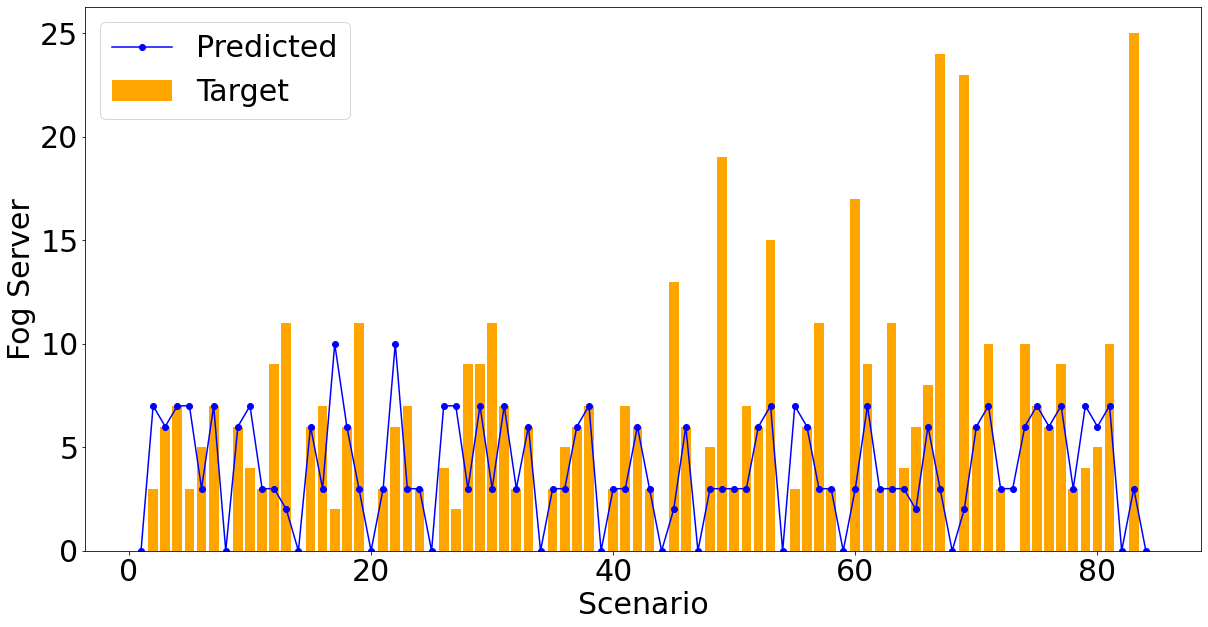

In [34]:
plot_predicted_and_target(target_iot, dec_tree_y_pred_iot, '')

srate: 64.447693%
fog_memory_mean: 14.559874%
link_SF_latency_mean: 13.658104%
avg_response_time: 7.334329%


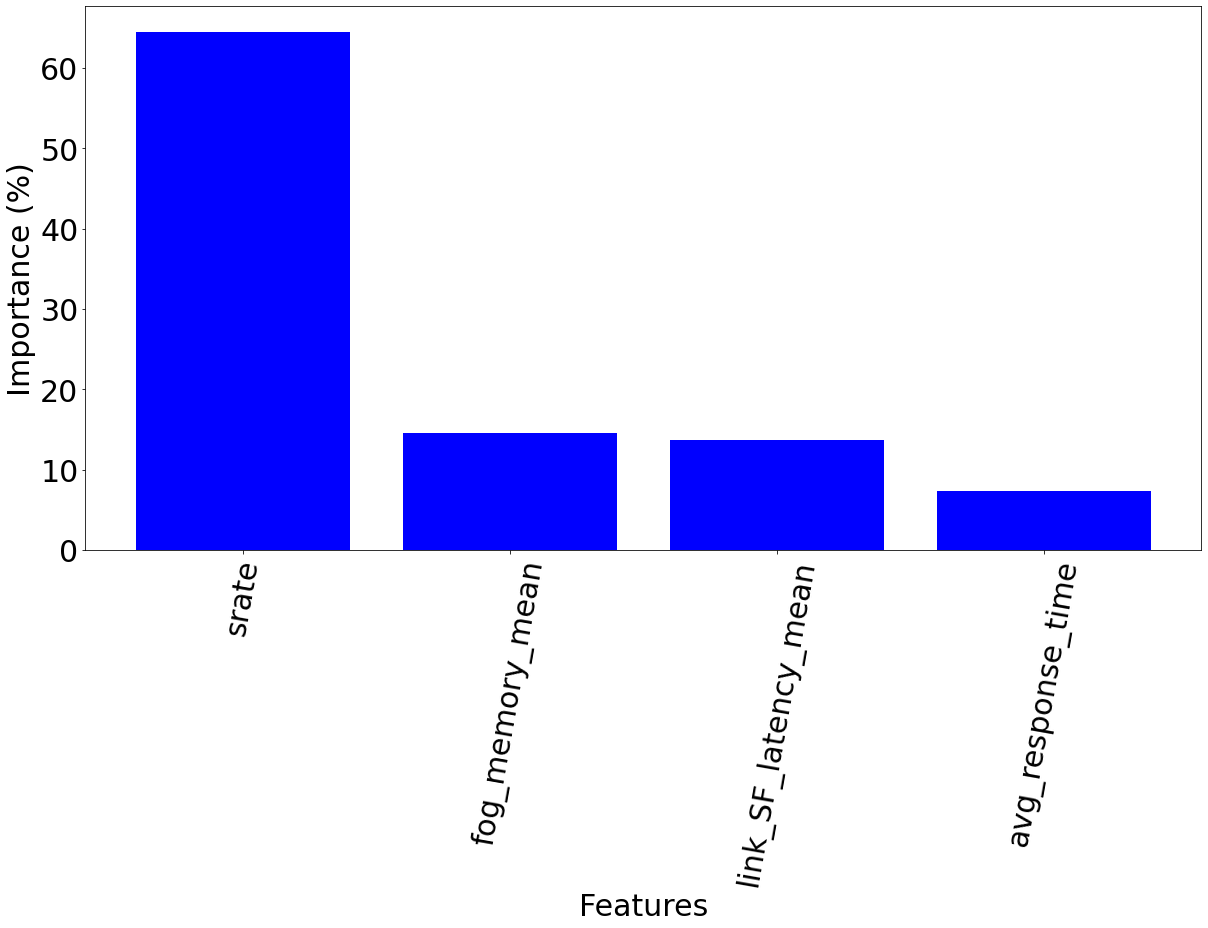

In [73]:
get_feature_importance(dec_tree_model_iot, train_n, target_iot)

###Grid Search

In [ ]:
param_grid = {
            "criterion": ['entropy', 'gini'],
            "splitter": ['best','random'],
            "max_depth": [3, 5, 10, 20, 50],
            "max_features": ['auto', 10, 30, 50, 80],
            "max_leaf_nodes": [3, 5, 10, 20]
}
grid_search = GridSearchCV(dec_tree_model_iot, param_grid, scoring="accuracy")
grid_search.fit(train, target_iot)

dec_tree_model = grid_search.best_estimator_ 
grid_search.best_params_, grid_search.best_score_

###Testing Study

In [29]:
dec_tree_model_iot =  DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = 6)
dec_tree_model_iot_fit_model = dec_tree_model_iot.fit(train, target_iot)
dec_tree_model_iot_fit_y_pred = dec_tree_model_iot_fit_model.predict(test_predict)

dec_tree_model_iot_fit_y_pred

array([0, 3, 6, 7, 2, 6, 6, 3, 3, 7, 0, 0, 3, 6, 7, 3, 7, 2, 0, 3, 3, 6,
       3, 7, 6, 6, 3, 0, 7, 2, 0, 0, 3, 7, 6, 3, 0, 6, 3, 7, 3, 7, 6, 7,
       3, 0, 0])

In [30]:
print_scores(test_target_iot, dec_tree_model_iot_fit_y_pred, "Testing", "DT")

---Testing DT---

Accuracy: 68.0850
Precision: 85.4710
Recall: 68.0850
F1-Score: 58.8889


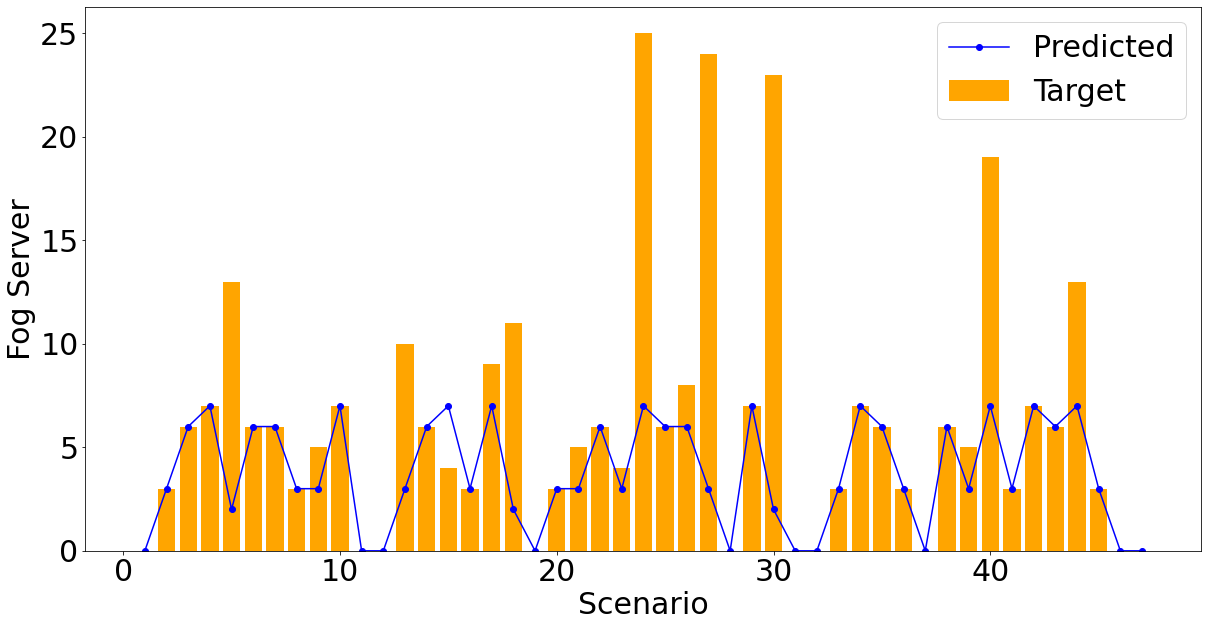

In [40]:
plot_predicted_and_target(test_target_iot, dec_tree_model_iot_fit_y_pred, '')

srate: 64.447693%
fog_power_std: 14.559874%
link_SF_latency_mean: 13.658104%
avg_response_time: 7.334329%


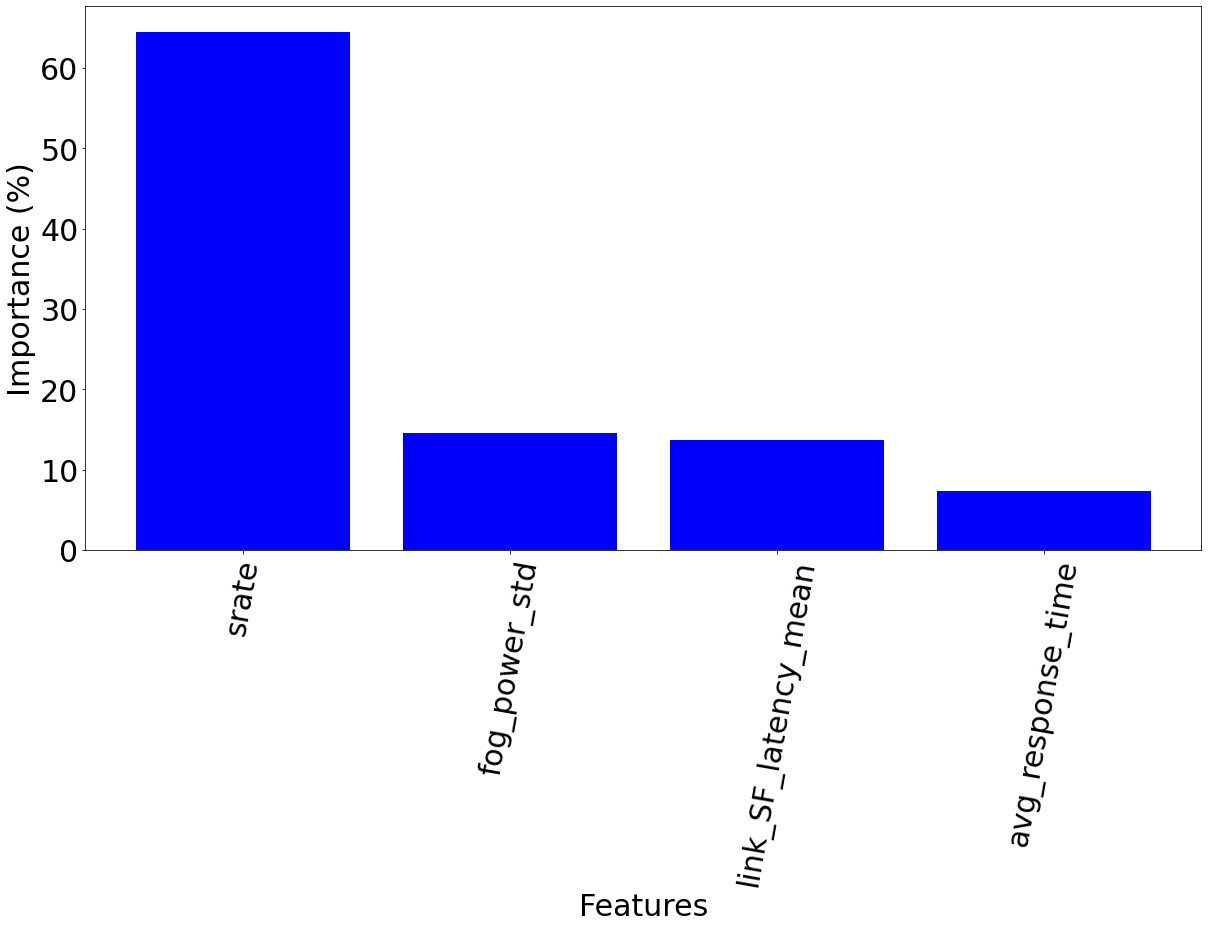

In [76]:
get_feature_importance(dec_tree_model_iot_fit_model, train_n, target_iot)

##Random Forest

###Training Study

In [42]:
rand_forest_model_iot = RandomForestClassifier(max_depth = 4, max_leaf_nodes = 6)
rand_forest_y_pred_iot = cvp(rand_forest_model_iot, train, target_iot, cv = kfold, n_jobs = 1)

rand_forest_y_pred_iot

array([0, 3, 6, 3, 3, 3, 7, 0, 6, 3, 3, 3, 6, 0, 6, 7, 6, 6, 3, 0, 3, 6,
       3, 3, 0, 3, 3, 3, 7, 3, 7, 3, 6, 0, 3, 3, 6, 7, 0, 3, 7, 6, 3, 0,
       6, 6, 0, 3, 3, 3, 3, 6, 3, 0, 7, 6, 3, 3, 0, 3, 3, 3, 3, 3, 6, 6,
       3, 0, 6, 6, 6, 3, 0, 6, 3, 6, 3, 3, 7, 6, 3, 0, 3, 0])

In [43]:
print_scores(target_iot, rand_forest_y_pred_iot, "Training", "RF")

---Training RF---

Accuracy: 57.1428
Precision: 78.4746
Recall: 57.1428
F1-Score: 46.3818


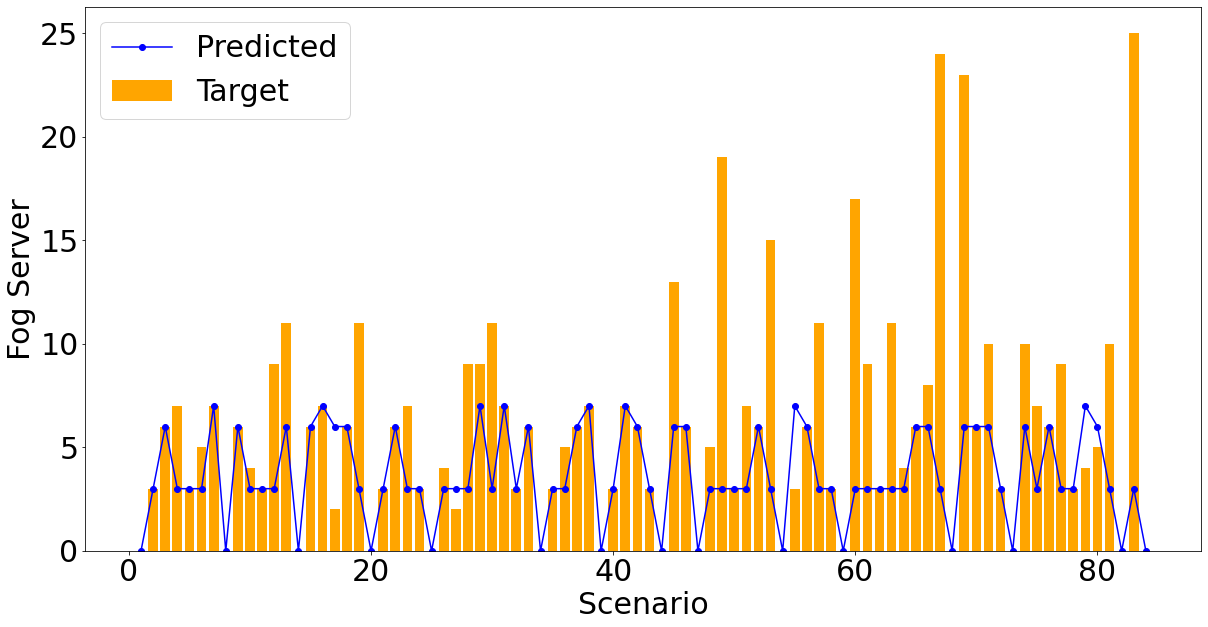

In [45]:
plot_predicted_and_target(target_iot, rand_forest_y_pred_iot, '')

srate: 17.048069%
link_IS_latency_mean: 11.079405%
std_response_time: 10.140945%
fog_memory_mean: 9.781999%
fog_power_std: 9.291797%
bytes: 7.480435%
pkts: 6.854878%
solution_resp_time: 6.205498%
att_id: 4.757674%
rate: 4.044417%
avg_response_time: 2.998781%
link_SF_latency_mean: 2.590638%
solution_accuracy: 2.330625%
link_SF_latency_std: 1.954204%
link_SF_capacity_mean: 1.487579%
fog_nodes_count: 0.579725%
vnf_cpu_consump: 0.450573%
vnf_ram_consump: 0.411065%
link_IS_capacity_mean: 0.313663%
vnf_time_deploy: 0.198032%


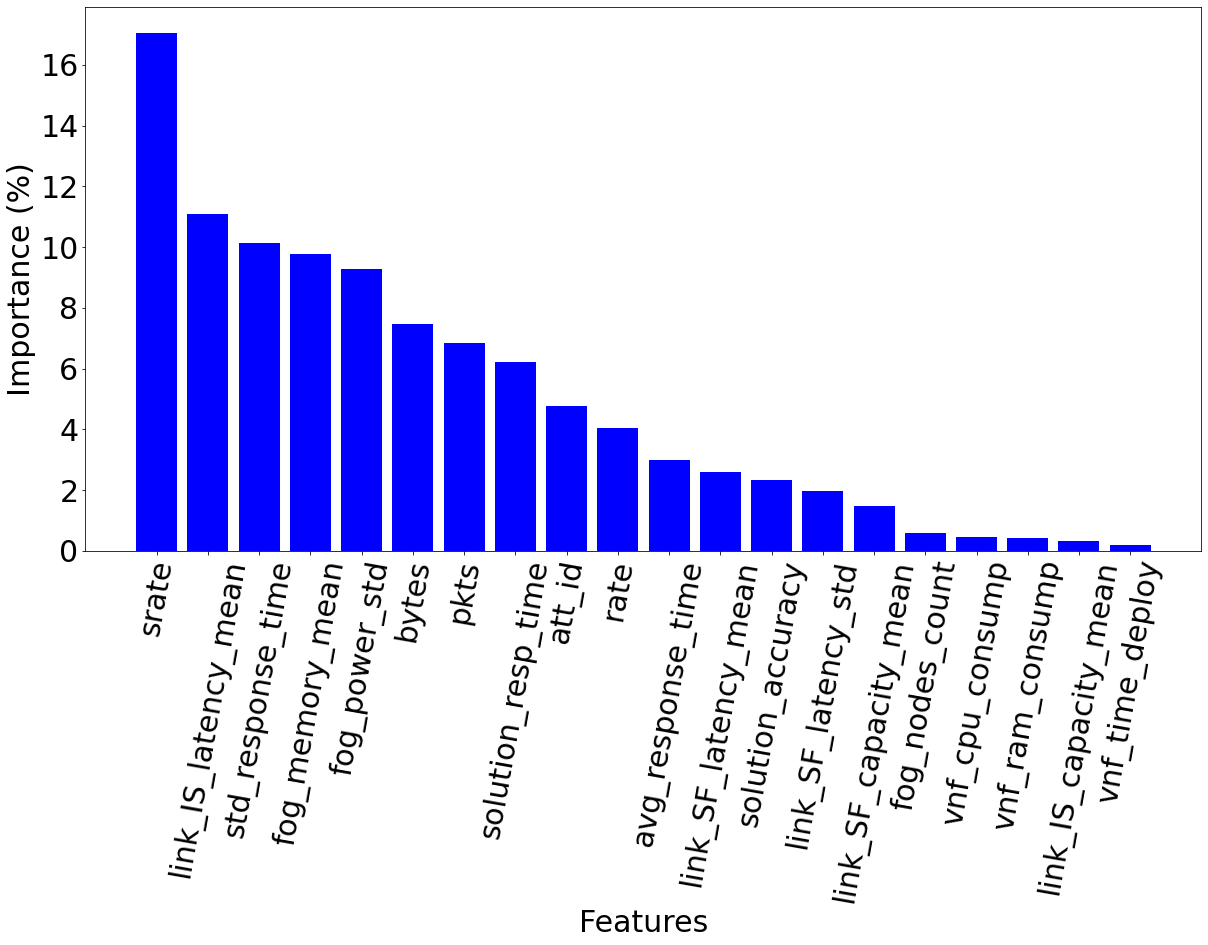

In [77]:
get_feature_importance(rand_forest_model_iot, train_n, target_iot)

###Testing Study

In [48]:
rand_forest_model_iot = RandomForestClassifier(max_depth = 4, max_leaf_nodes = 6)
rand_forest_model_iot_fit_model = rand_forest_model_iot.fit(train, target_iot)
rand_forest_model_iot_fit_y_pred = rand_forest_model_iot_fit_model.predict(test_predict)

rand_forest_model_iot_fit_y_pred

array([0, 3, 6, 7, 6, 6, 6, 3, 3, 7, 0, 0, 6, 6, 3, 3, 3, 6, 0, 3, 3, 6,
       3, 3, 6, 6, 3, 0, 7, 6, 0, 0, 3, 3, 6, 3, 0, 6, 3, 3, 3, 3, 6, 3,
       3, 0, 0])

In [49]:
print_scores(test_target_iot, rand_forest_model_iot_fit_y_pred, "Testing", "RF")

---Testing RF---

Accuracy: 63.8297
Precision: 82.9482
Recall: 63.8297
F1-Score: 53.9678


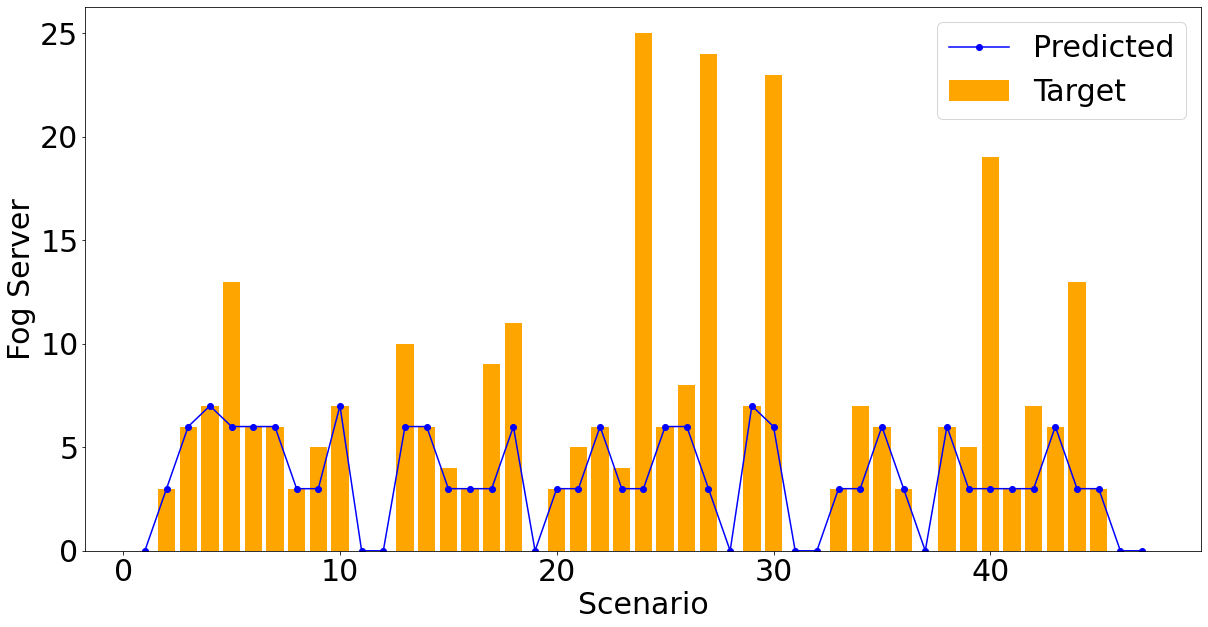

In [50]:
plot_predicted_and_target(test_target_iot, rand_forest_model_iot_fit_y_pred, '')

srate: 18.210729%
std_response_time: 12.142969%
link_IS_latency_mean: 7.765775%
fog_power_std: 7.554509%
bytes: 7.019728%
fog_memory_mean: 6.383259%
solution_resp_time: 5.819796%
att_id: 5.819189%
pkts: 5.617201%
link_SF_latency_mean: 4.638518%
link_SF_capacity_mean: 4.351552%
rate: 4.184268%
avg_response_time: 3.718036%
link_SF_latency_std: 3.006846%
solution_accuracy: 2.361436%
vnf_cpu_consump: 1.175137%
vnf_ram_consump: 0.231052%


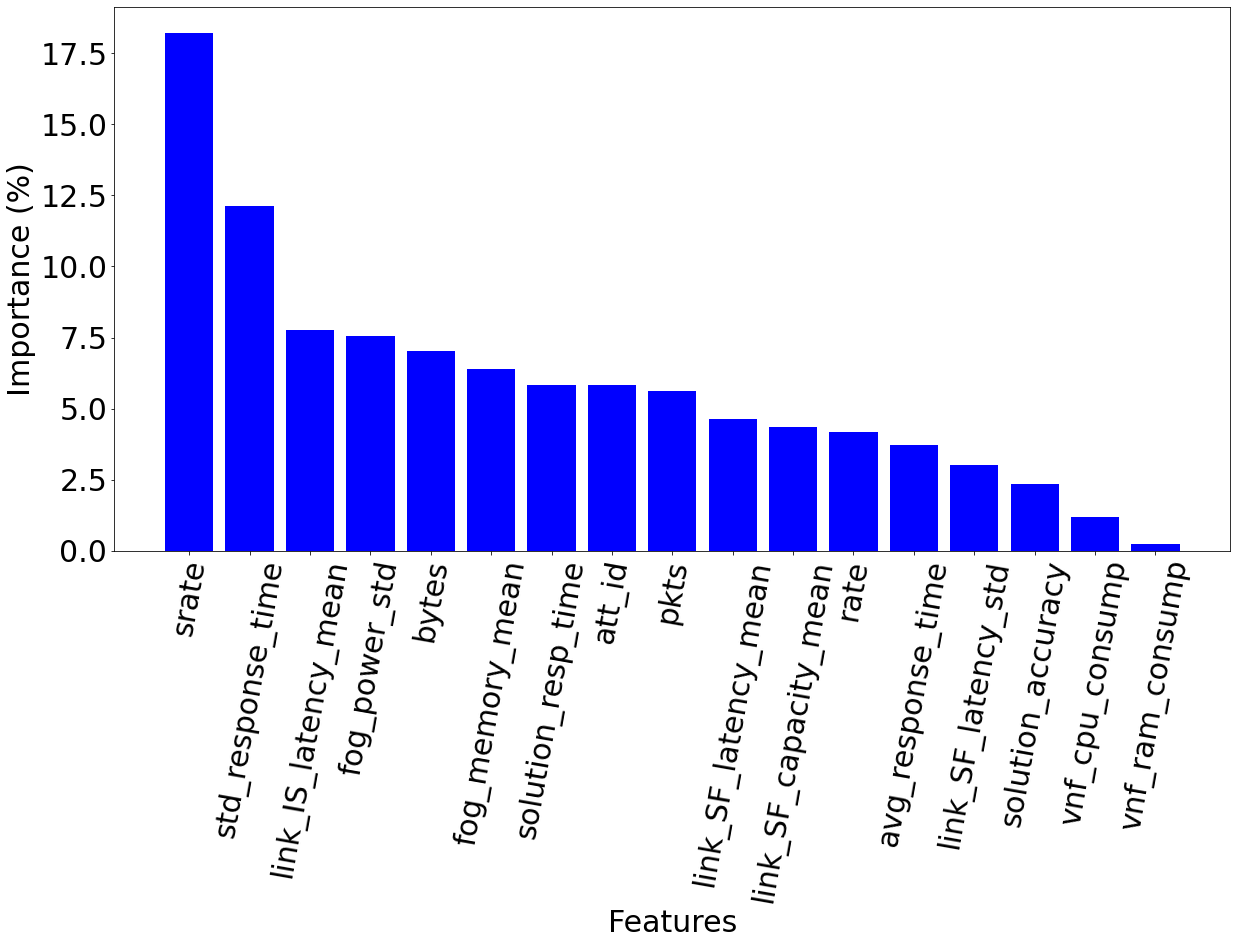

In [79]:
get_feature_importance(rand_forest_model_iot_fit_model, train_n, target_iot)

##XGBoost

###Training Study

In [88]:
xgb_model_iot = XGBClassifier(max_depth = 4, max_leaf_nodes = 6)
xgb_y_pred_iot = cvp(xgb_model_iot, train, target_iot, cv = kfold, n_jobs = 1)

xgb_y_pred_iot

array([ 0,  2,  6,  7,  3,  3,  7,  0,  6,  7,  5,  3,  2,  0,  6,  7, 11,
        6,  2,  0,  9, 11,  3,  3,  0,  3,  3,  3,  7,  3,  7,  3,  6,  0,
        3,  3,  6,  7,  0,  3,  7,  6,  3,  0, 11,  6,  0,  3,  9,  2,  4,
        6,  7,  0,  4,  6,  9,  4,  0,  3,  7,  9,  3,  3,  6,  6,  3,  0,
        6,  6,  5, 10,  5,  6,  3,  6,  7,  3,  7,  6,  9,  0,  3,  0])

In [89]:
print_scores(target_iot, xgb_y_pred_iot, "Training", "XGB")

---Training XGB---

Accuracy: 47.6189
Precision: 51.1649
Recall: 47.6189
F1-Score: 44.0990


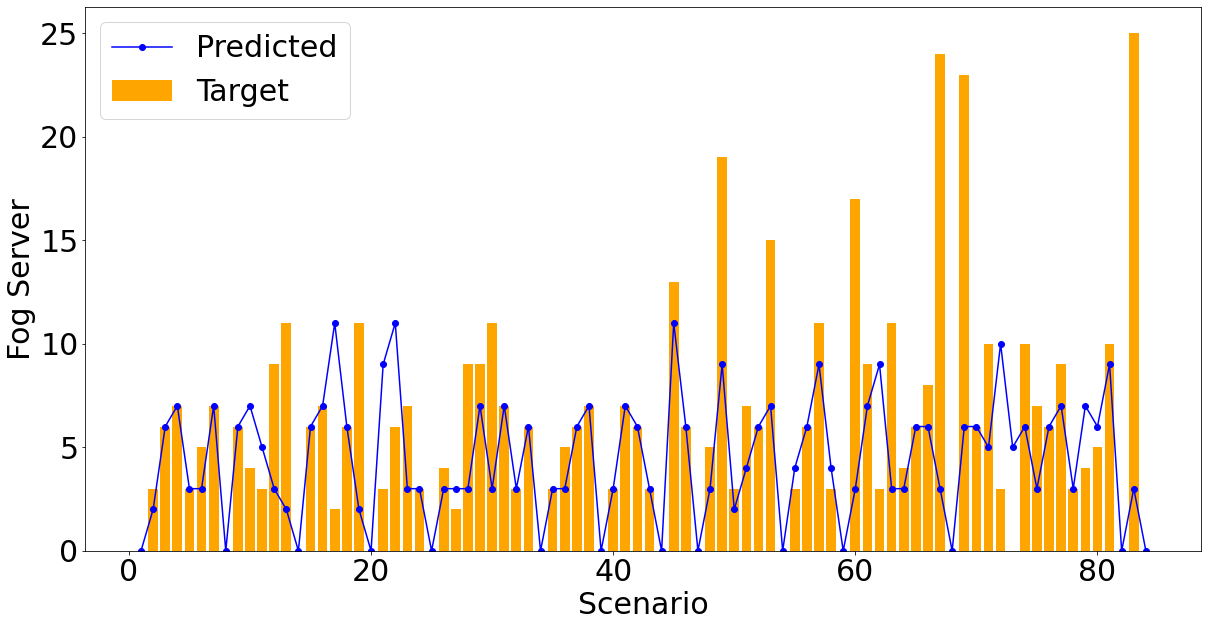

In [90]:
plot_predicted_and_target(target_iot, xgb_y_pred_iot, '')

vnf_cpu_consump: 17.192405%
bytes: 11.018144%
srate: 8.771248%
link_SF_latency_mean: 6.695434%
vnf_ram_consump: 5.872623%
fog_power_mean: 5.625496%
att_id: 4.813829%
link_SF_latency_std: 4.683617%
solution_resp_time: 4.503527%
std_response_time: 4.371549%
link_SF_capacity_std: 3.717803%
avg_response_time: 3.684743%
solution_accuracy: 3.584791%
link_SF_capacity_mean: 3.570011%
rate: 3.524611%
vnf_time_deploy: 2.544990%
pkts: 2.509616%
link_IS_capacity_std: 2.425477%
fog_memory_mean: 0.890087%


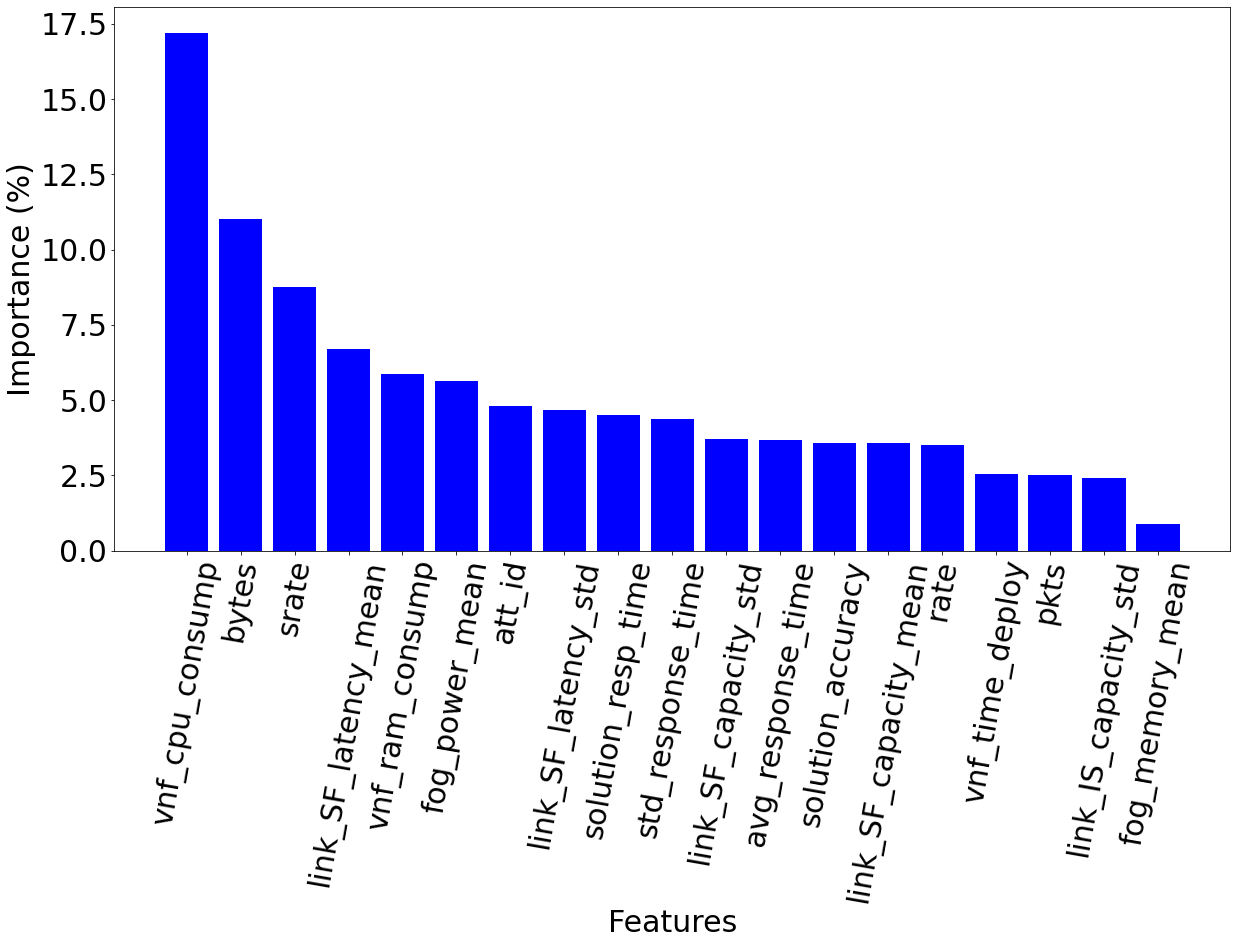

In [91]:
get_feature_importance(xgb_model_iot, train_n, target_iot)

###Testing Study

In [92]:
xgb_model_iot = XGBClassifier(max_depth = 4, max_leaf_nodes = 6)
xgb_model_iot_fit_model = xgb_model_iot.fit(train, target_iot)
xgb_model_iot_fit_y_pred = xgb_model_iot_fit_model.predict(test_predict)

xgb_model_iot_fit_y_pred

array([ 0,  3,  6,  7, 11,  6,  6,  3,  3,  7,  0,  0,  7,  6,  4,  3,  9,
        6,  0,  3,  3,  6,  3,  3,  6,  6,  9,  0,  7,  6,  0,  0,  3,  7,
        6,  3,  0,  6, 11,  9,  3,  4,  6,  4,  5,  0,  0])

In [93]:
print_scores(test_target_iot, xgb_model_iot_fit_y_pred, "Testing", "XGB")

---Testing XGB---

Accuracy: 68.0850
Precision: 74.1295
Recall: 68.0850
F1-Score: 61.5085


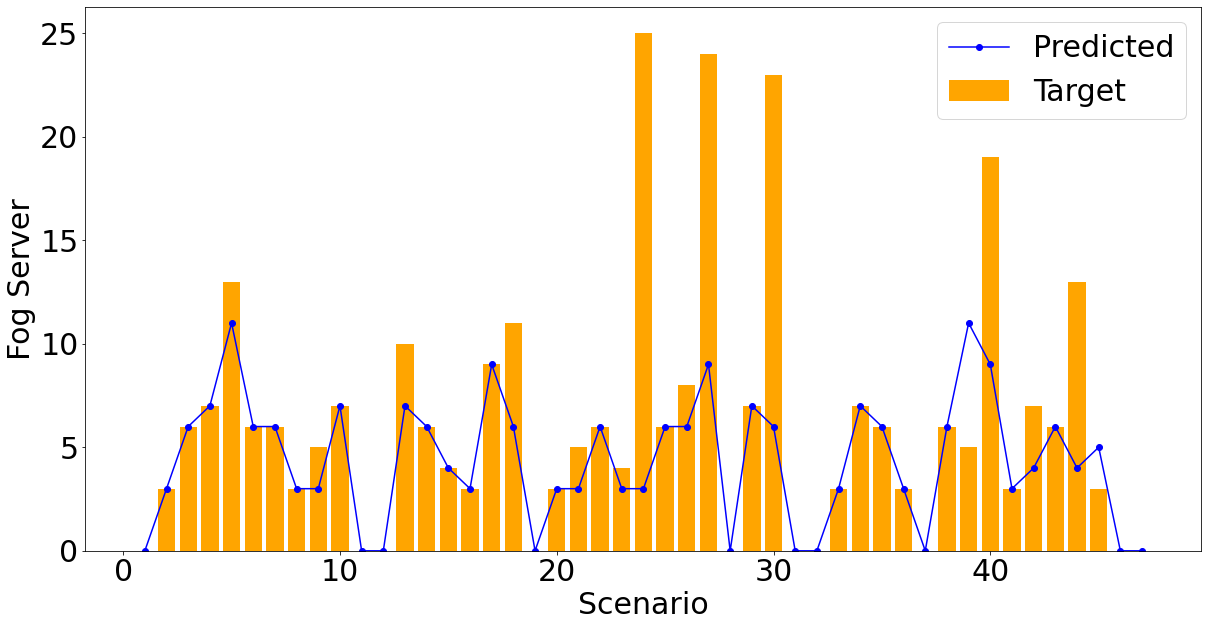

In [95]:
plot_predicted_and_target(test_target_iot, xgb_model_iot_fit_y_pred, '')

vnf_cpu_consump: 17.192405%
bytes: 11.018144%
srate: 8.771248%
link_SF_latency_mean: 6.695434%
vnf_ram_consump: 5.872623%
fog_power_mean: 5.625496%
att_id: 4.813829%
link_SF_latency_std: 4.683617%
solution_resp_time: 4.503527%
std_response_time: 4.371549%
link_SF_capacity_std: 3.717803%
avg_response_time: 3.684743%
solution_accuracy: 3.584791%
link_SF_capacity_mean: 3.570011%
rate: 3.524611%
vnf_time_deploy: 2.544990%
pkts: 2.509616%
link_IS_capacity_std: 2.425477%
fog_memory_mean: 0.890087%


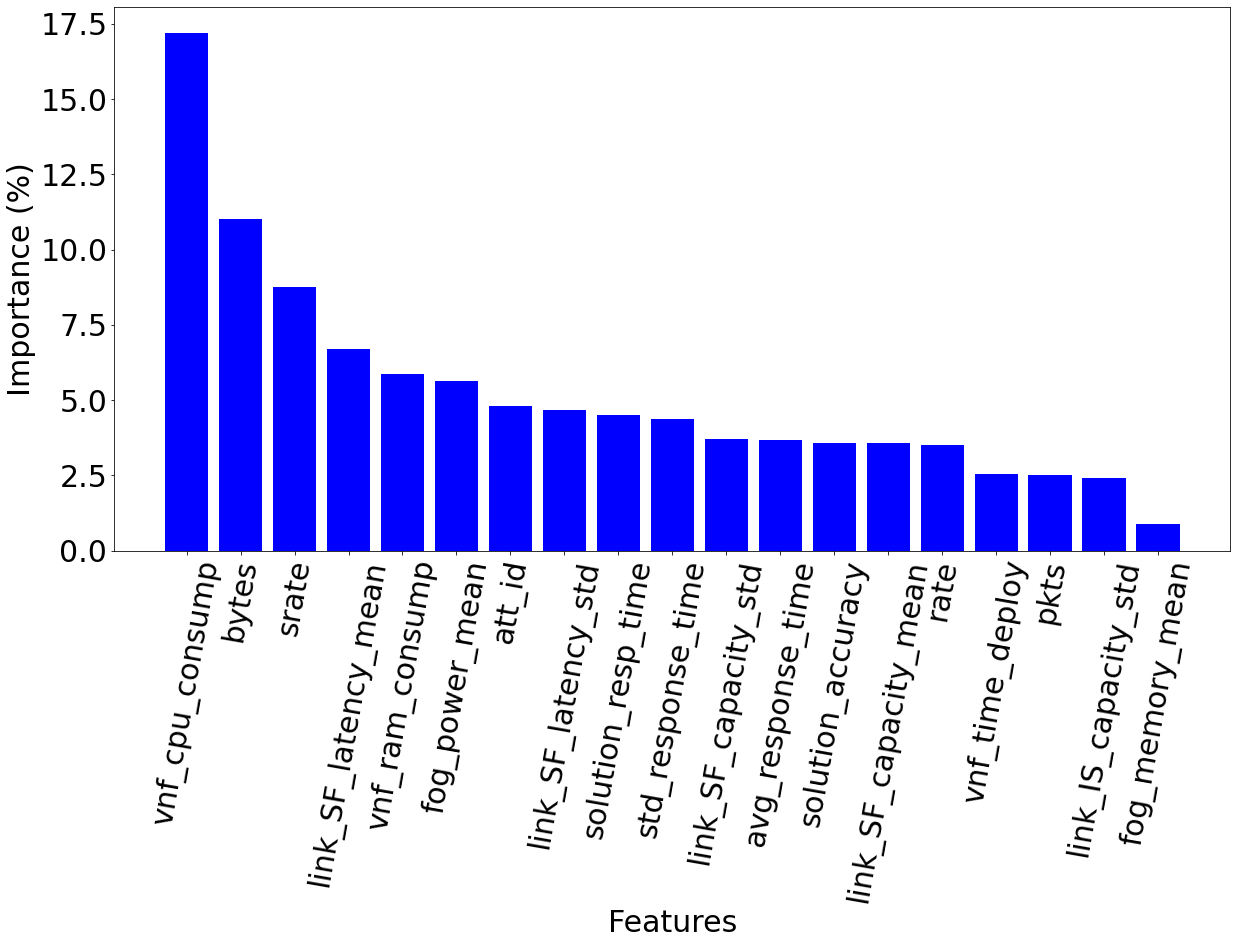

In [96]:
get_feature_importance(xgb_model_iot_fit_model, train_n, target_iot)

##Logistic Regression

###Training Study

In [97]:
log_reg_model_iot = LogisticRegression()
log_reg_y_pred_iot = cvp(log_reg_model_iot, train_z, target_iot, cv = kfold, n_jobs = 1)

log_reg_y_pred_iot

array([ 0,  6,  3,  6,  6,  3,  6,  0,  6,  6,  3,  6,  6,  0,  6,  3,  7,
        7,  3,  0,  3,  3,  3,  3,  0,  6,  3,  3,  3,  3,  6,  3,  7,  0,
        6,  6,  6,  6,  0,  8,  3,  3,  7,  0,  6,  3,  0,  3,  6,  6,  3,
        3,  3,  0,  6,  9,  6,  6,  0,  3,  6, 11,  6,  6,  3,  3,  9,  0,
        3, 10,  6,  6,  0,  3,  3, 10,  6, 10,  3,  6, 25,  0, 10,  0])

In [98]:
print_scores(target_iot, log_reg_y_pred_iot, "Training", "LR")

---Training LR---

Accuracy: 26.1904
Precision: 41.2414
Recall: 26.1904
F1-Score: 23.5603


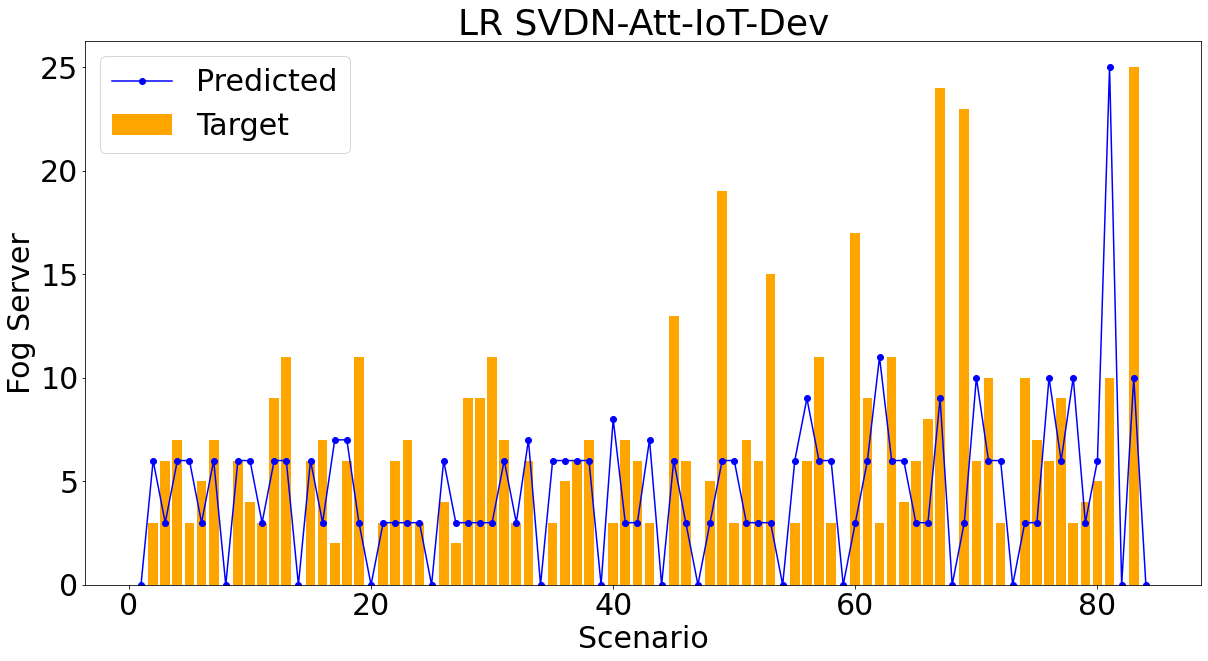

In [99]:
plot_predicted_and_target(target_iot, log_reg_y_pred_iot, 'LR SVDN-Att-IoT-Dev')

iiot_nodes_count: -0.052267
fog_nodes_count: -0.040705
link_IS_latency_mean: -0.000000
link_IS_latency_std: 0.170787
link_SF_latency_mean: -0.000000
link_SF_latency_std: -0.086287
avg_response_time: 0.090565
std_response_time: -0.115564
solution_accuracy: -0.049106
solution_resp_time: 0.226482
vnf_cpu_consump: 0.045874
vnf_ram_consump: 0.060936
vnf_time_deploy: -0.048582
att_id: -2.160811
pkts: -0.350387
bytes: 0.353176
rate: 0.479412
srate: 0.474942
drate: 0.203455


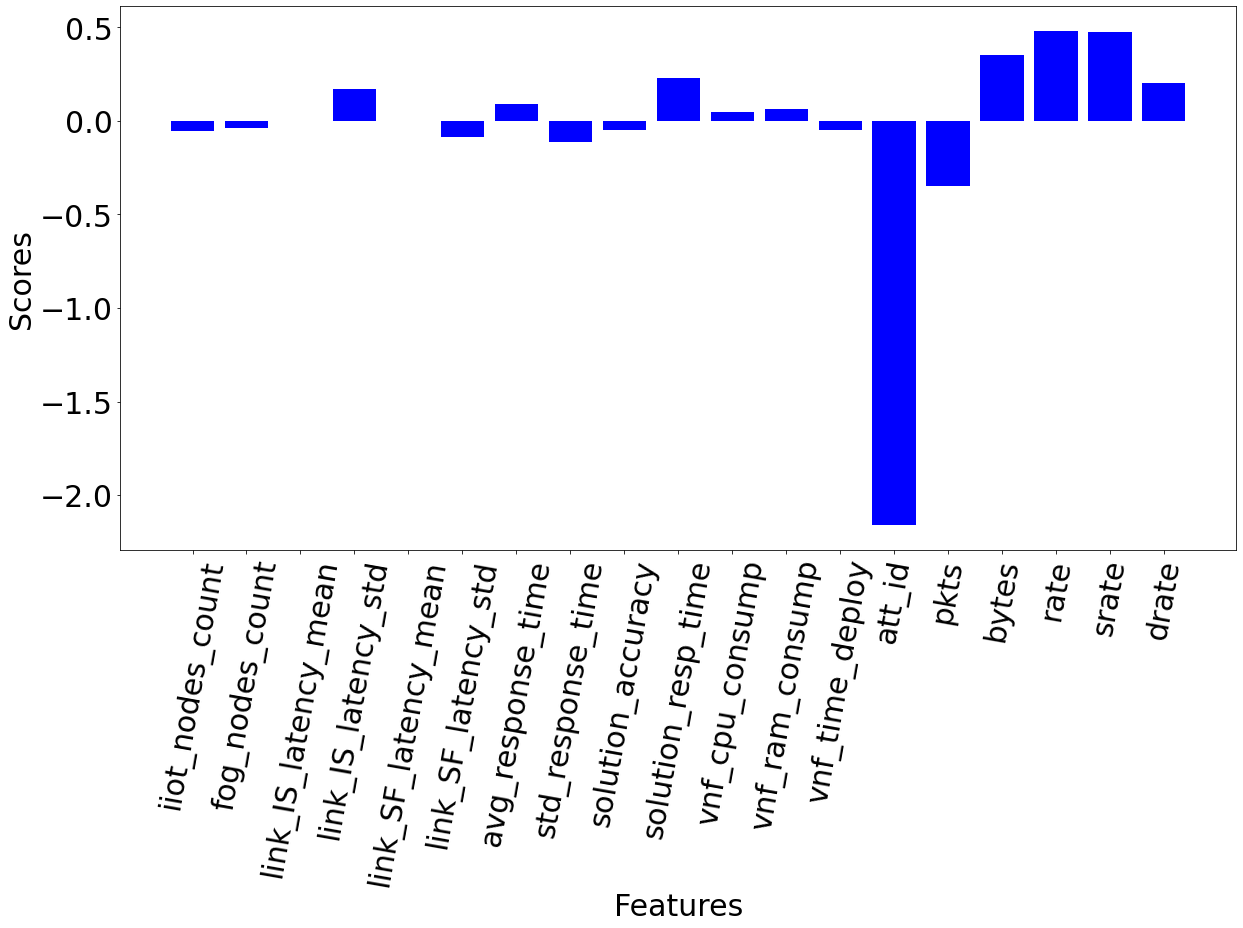

In [100]:
get_feature_importance_(log_reg_model_iot, train, train_z, target_iot)

###Testing Study

In [101]:
log_reg_model_iot = LogisticRegression()
log_reg_model_iot_fit_model = log_reg_model_iot.fit(train, target_iot)
log_reg_model_iot_fit_y_pred = log_reg_model_iot_fit_model.predict(test_predict)

log_reg_model_iot_fit_y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


array([3, 3, 3, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 6, 3, 3,
       3, 3, 3, 6, 0, 3, 3, 3, 3, 6, 3, 3, 3, 3, 0, 3, 3, 6, 3, 3, 3, 3,
       3, 6, 0])

In [102]:
print_scores(test_target_iot, log_reg_model_iot_fit_y_pred, "Testing", "LR")

---Testing LR---

Accuracy: 19.1488
Precision: 61.7831
Recall: 19.1488
F1-Score: 13.4243


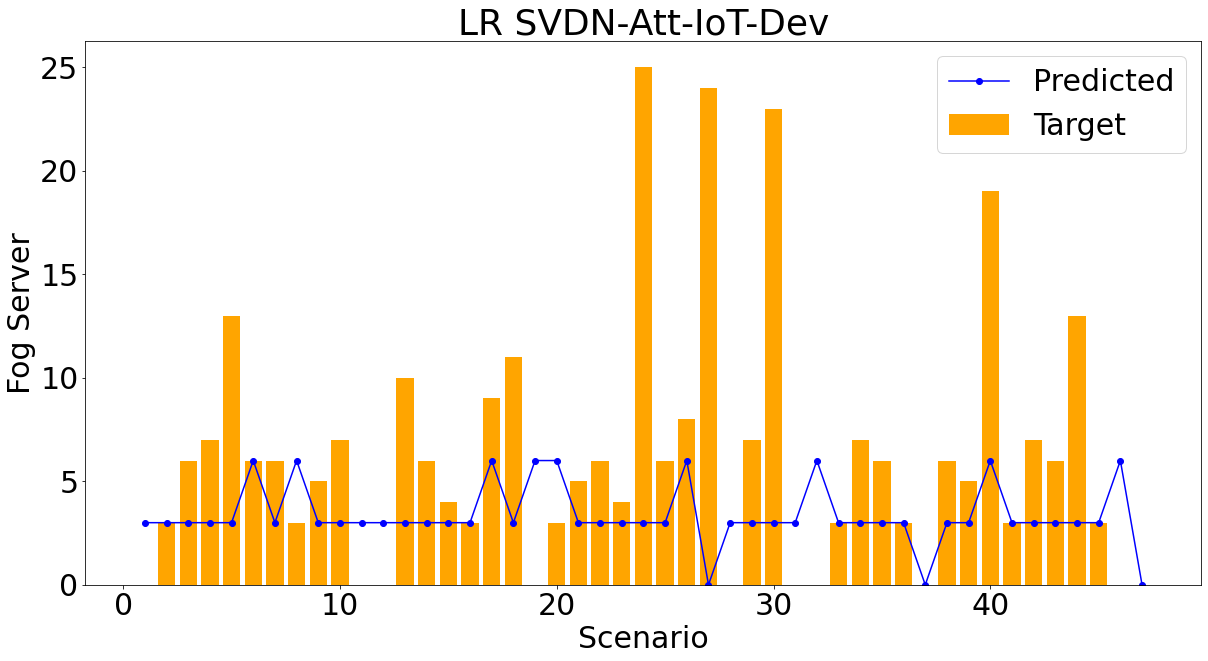

In [103]:
plot_predicted_and_target(test_target_iot, log_reg_model_iot_fit_y_pred, 'LR SVDN-Att-IoT-Dev')

iiot_nodes_count: -0.052267
fog_nodes_count: -0.040705
link_IS_latency_mean: -0.000000
link_IS_latency_std: 0.170787
link_SF_latency_mean: -0.000000
link_SF_latency_std: -0.086287
avg_response_time: 0.090565
std_response_time: -0.115564
solution_accuracy: -0.049106
solution_resp_time: 0.226482
vnf_cpu_consump: 0.045874
vnf_ram_consump: 0.060936
vnf_time_deploy: -0.048582
att_id: -2.160811
pkts: -0.350387
bytes: 0.353176
rate: 0.479412
srate: 0.474942
drate: 0.203455


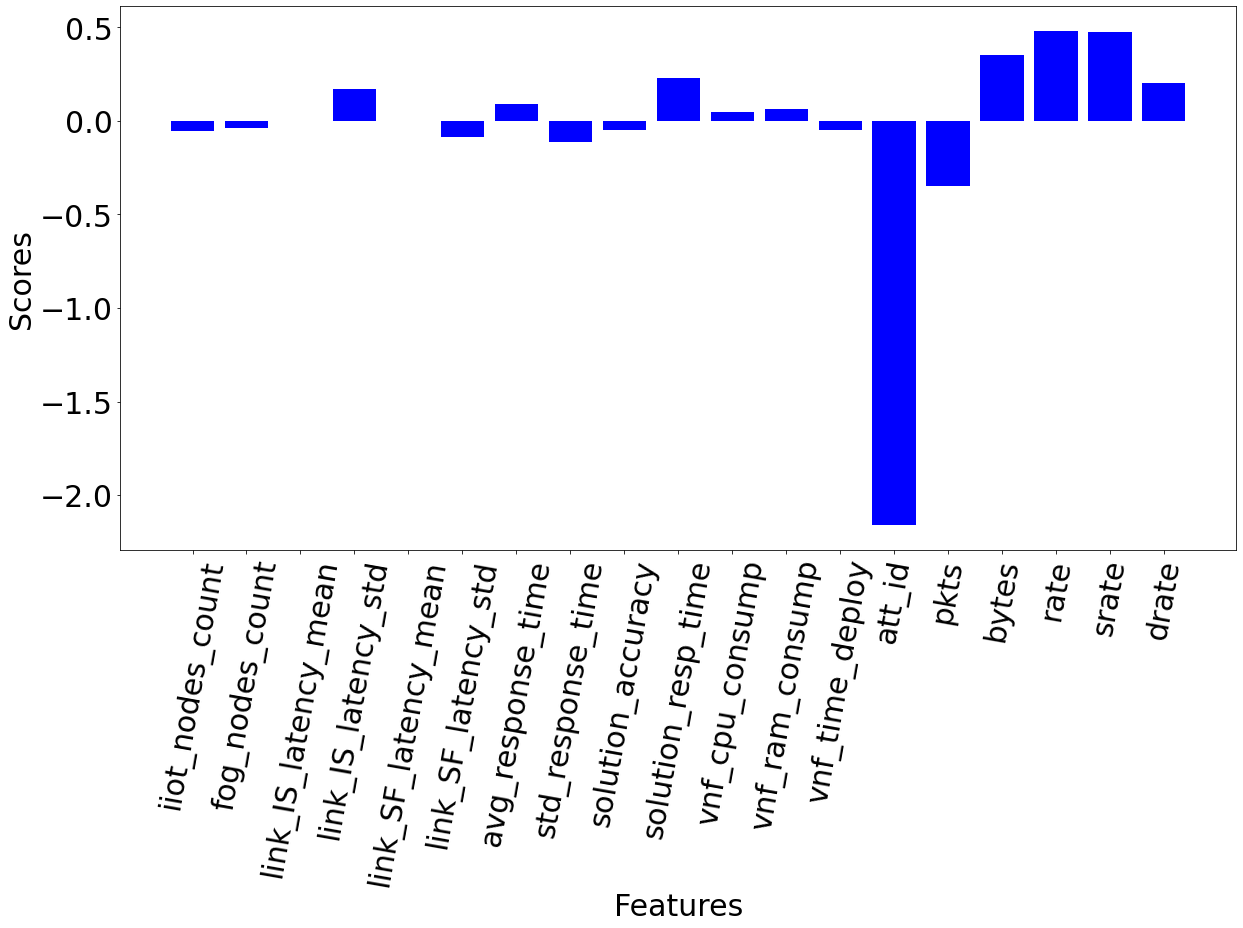

In [104]:
get_feature_importance_(log_reg_model_iot_fit_model, train, train_z, target_iot)

##Support Vector Machine

###Training Study

In [117]:
svm_model_iot = SVC(C = 1e6, kernel = "linear")
svm_y_pred_iot = cvp(svm_model_iot, train_z, target_iot, cv = kfold, n_jobs = 1)

svm_y_pred_iot

array([ 0,  5,  5,  3,  7, 11,  3,  0,  6,  3,  4,  3,  6,  0,  6,  9,  2,
        2,  3,  0,  3,  6,  3,  3,  0,  2,  3,  3, 11,  6,  3,  3,  6,  0,
        7,  3,  6,  6,  0,  8,  5,  6,  5,  0,  6, 13,  0,  3,  3,  6, 15,
        6,  7,  0,  4,  7,  6,  3,  0,  3,  6,  4,  3,  6,  4, 24,  8,  0,
        6,  3,  5, 10,  5,  3,  4, 10,  6, 10,  7,  9, 25, 10,  4, 10])

In [118]:
print_scores(target_iot, svm_y_pred_iot, "Training", "SVM")

---Training SVM---

Accuracy: 28.5713
Precision: 32.6563
Recall: 28.5713
F1-Score: 28.4338


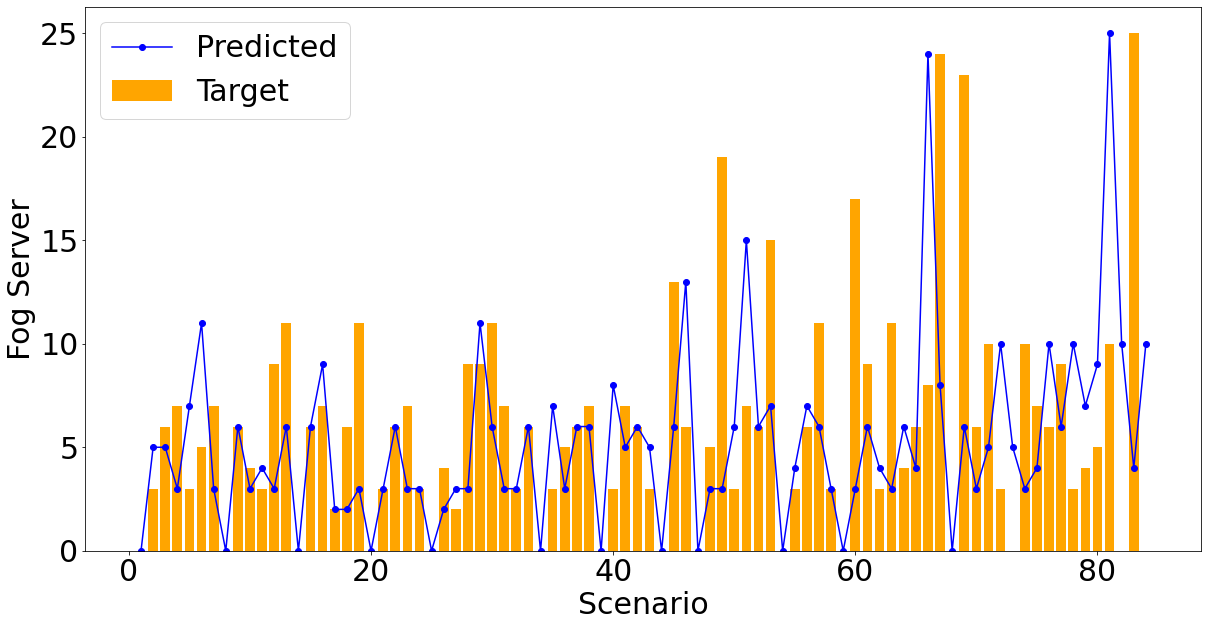

In [119]:
plot_predicted_and_target(target_iot, svm_y_pred_iot, '')

iiot_nodes_count: 0.040697
fog_nodes_count: 0.036409
link_IS_latency_std: -0.095907
link_SF_latency_std: 0.052974
avg_response_time: -0.022587
std_response_time: -0.019162
solution_accuracy: 0.003422
solution_resp_time: 0.023261
vnf_cpu_consump: -0.013786
vnf_ram_consump: 0.097784
vnf_time_deploy: 0.005175
att_id: -0.660918
pkts: -0.086061
bytes: 0.134879
rate: 0.073013
srate: 0.107160
drate: 0.012277


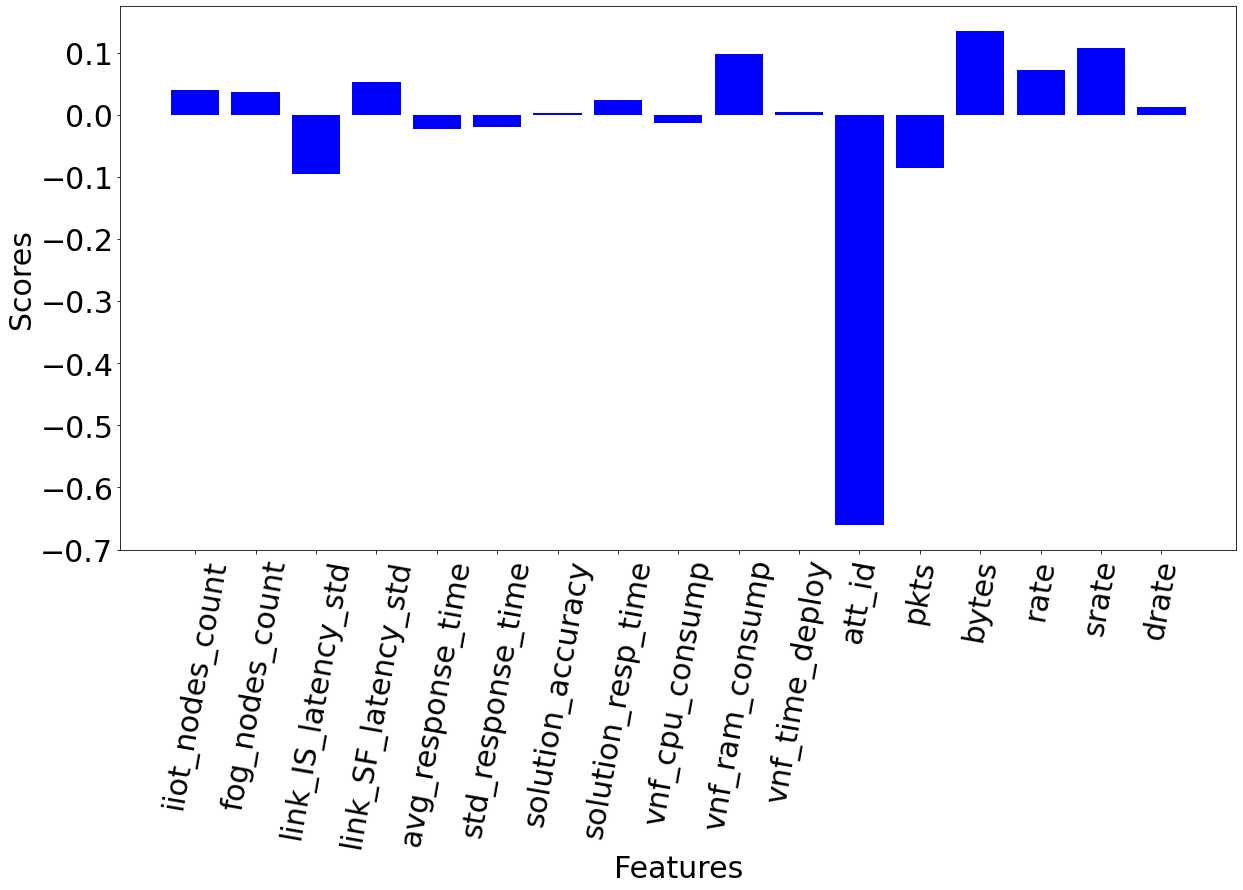

In [121]:
get_feature_importance_(svm_model_iot, train, train_z, target_iot)

###Testing Study

In [122]:
svm_model_iot = SVC(C = 1e6, kernel = 'linear')
svm_model_iot_fit_model = svm_model_iot.fit(train_n, target_iot)
svm_model_iot_fit_y_pred = svm_model_iot_fit_model.predict(test_predict)

svm_model_iot_fit_y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([10, 17, 13,  7, 13,  8, 23,  8,  5,  7, 10, 10,  7, 23, 15,  5, 19,
       23, 10,  8, 17,  8,  5, 15,  7,  8, 24,  7,  7, 23, 10, 10,  5,  7,
       23,  5, 24, 23, 15, 19, 17, 25, 23, 25,  5, 10, 24])

In [123]:
print_scores(test_target_iot, svm_model_iot_fit_y_pred, "Testing", "SVM")

---Testing SVM---

Accuracy: 21.2765
Precision: 77.7304
Recall: 21.2765
F1-Score: 14.3616


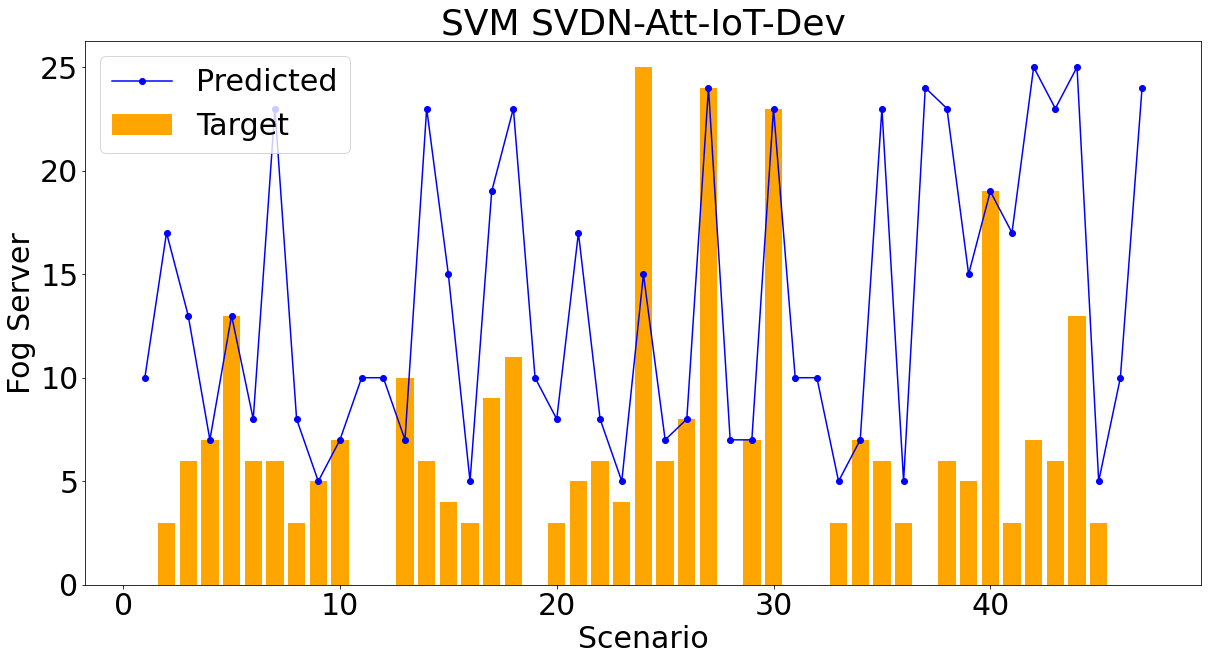

In [124]:
plot_predicted_and_target(test_target_iot, svm_model_iot_fit_y_pred, 'SVM SVDN-Att-IoT-Dev')

iiot_nodes_count: 0.040697
fog_nodes_count: 0.036409
link_IS_latency_std: -0.095907
link_SF_latency_std: 0.052974
avg_response_time: -0.022587
std_response_time: -0.019162
solution_accuracy: 0.003422
solution_resp_time: 0.023261
vnf_cpu_consump: -0.013786
vnf_ram_consump: 0.097784
vnf_time_deploy: 0.005175
att_id: -0.660918
pkts: -0.086061
bytes: 0.134879
rate: 0.073013
srate: 0.107160
drate: 0.012277


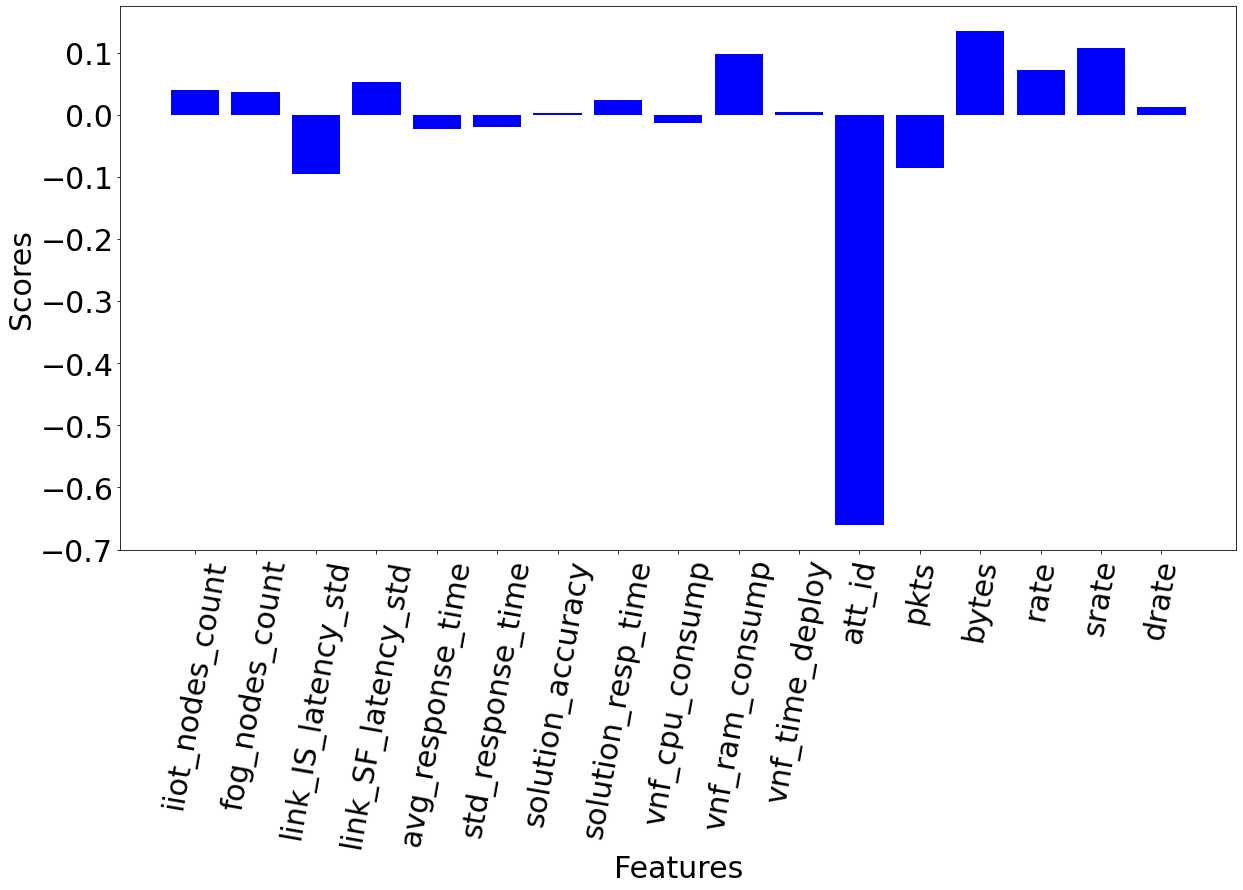

In [125]:
get_feature_importance_(svm_model_iot_fit_model, train, train_z, target_iot)

##K Nearest Neighbors

###Training Study

In [154]:
knn_model_iot = KNeighborsClassifier(n_neighbors = 2)
knn_y_pred_iot = cvp(knn_model_iot, train, target_iot, cv = kfold, n_jobs = 1)

knn_y_pred_iot

array([ 0,  6,  6,  5,  3,  3,  7,  0,  6,  3,  3, 10, 13,  0,  6,  3, 11,
        6,  4,  0,  6, 13,  3,  7,  0,  3,  3,  3,  6,  3,  6,  3,  6,  0,
        3,  3,  6,  7,  0,  5,  0,  6,  3,  0,  2,  6,  0, 11,  7,  5,  3,
        6,  3,  0,  7,  5,  9,  6,  0,  3,  7,  7, 11,  3,  0,  3,  3,  6,
        6,  3,  6,  5,  0,  6,  0,  6,  7,  2,  0,  6,  9,  3,  3,  0])

In [155]:
print_scores(target_iot, knn_y_pred_iot, "Training", "KNN")

---Training KNN---

Accuracy: 36.9047
Precision: 38.8667
Recall: 36.9047
F1-Score: 33.0211


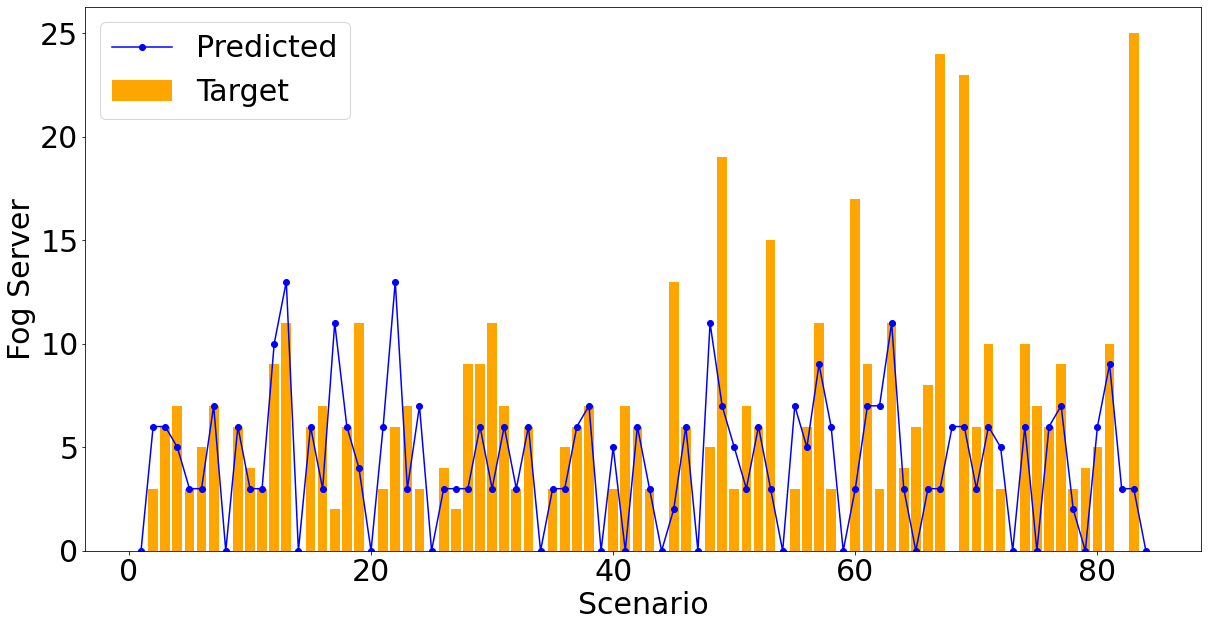

In [156]:
plot_predicted_and_target(target_iot, knn_y_pred_iot, '')

iiot_nodes_count: 0.014286
fog_nodes_count: 0.014286
link_IS_latency_std: 0.016667
link_SF_latency_std: -0.009524
avg_response_time: 0.035714
std_response_time: 0.033333
solution_resp_time: 0.028571
vnf_ram_consump: 0.104762
att_id: 0.161905
pkts: 0.178571
bytes: 0.002381
rate: 0.000000
srate: 0.000000


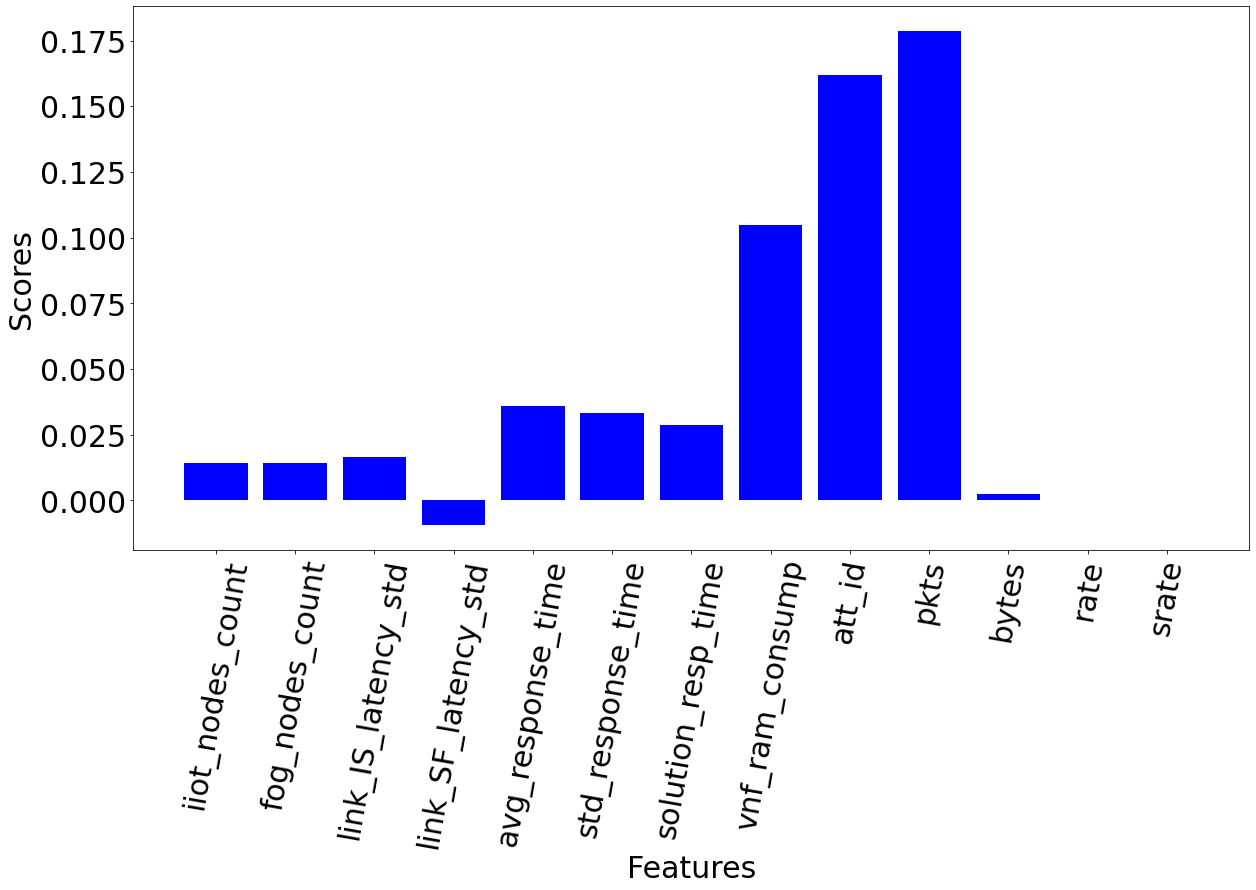

In [158]:
get_feature_importance__(knn_model_iot, train, train_z, target_iot)

###Testing Study

In [159]:
knn_model_iot = KNeighborsClassifier(n_neighbors = 2)
knn_model_iot_fit_model = knn_model_iot.fit(train, target_iot)
knn_model_iot_fit_y_pred = knn_model_iot_fit_model.predict(test_predict)

knn_model_iot_fit_y_pred

array([ 0,  3,  6,  5,  2,  3,  6,  3,  3,  7,  0,  0,  6,  6,  4,  3,  9,
       11,  0,  3,  3,  6,  2,  3,  0,  6,  3,  0,  7, 11,  0,  0,  3,  4,
        6,  3,  0,  6,  5,  9,  3,  4,  6,  4,  3,  0,  0])

In [160]:
print_scores(test_target_iot, knn_model_iot_fit_y_pred, "Training", "KNN")

---Training KNN---

Accuracy: 65.9573
Precision: 78.7531
Recall: 65.9573
F1-Score: 61.0131


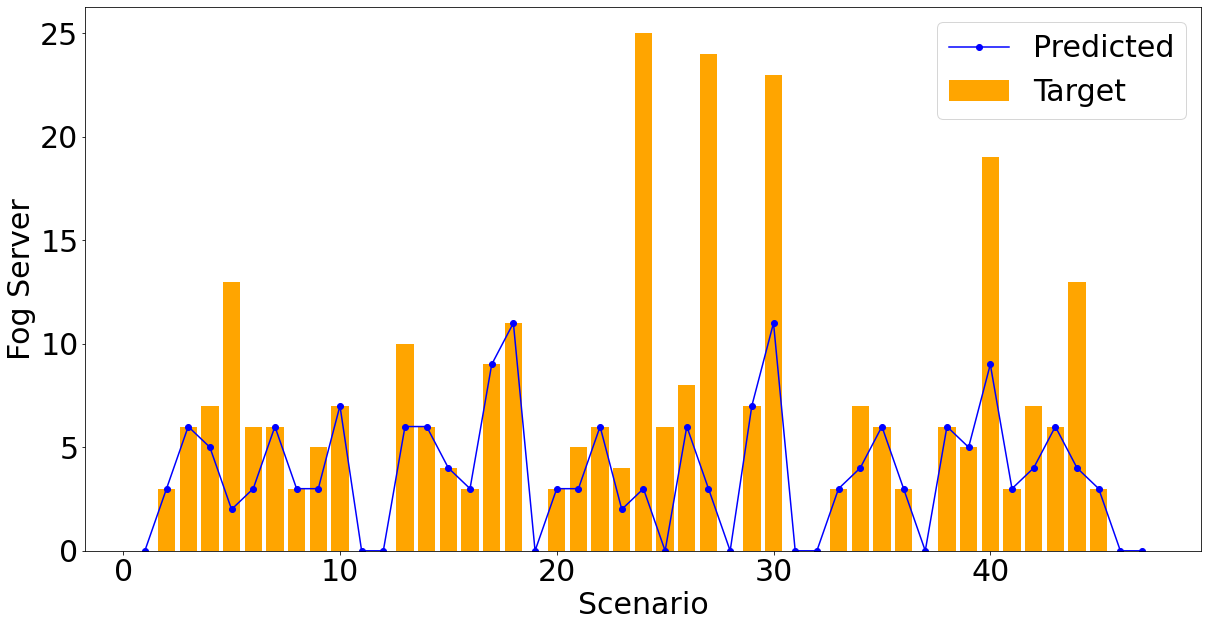

In [162]:
plot_predicted_and_target(test_target_iot, knn_model_iot_fit_y_pred, '')

iiot_nodes_count: 0.011905
fog_nodes_count: 0.011905
link_IS_latency_std: 0.050000
link_SF_latency_std: -0.004762
avg_response_time: 0.019048
std_response_time: 0.030952
solution_resp_time: 0.028571
vnf_ram_consump: 0.095238
att_id: 0.154762
pkts: 0.190476
bytes: 0.002381
rate: 0.004762
srate: 0.004762


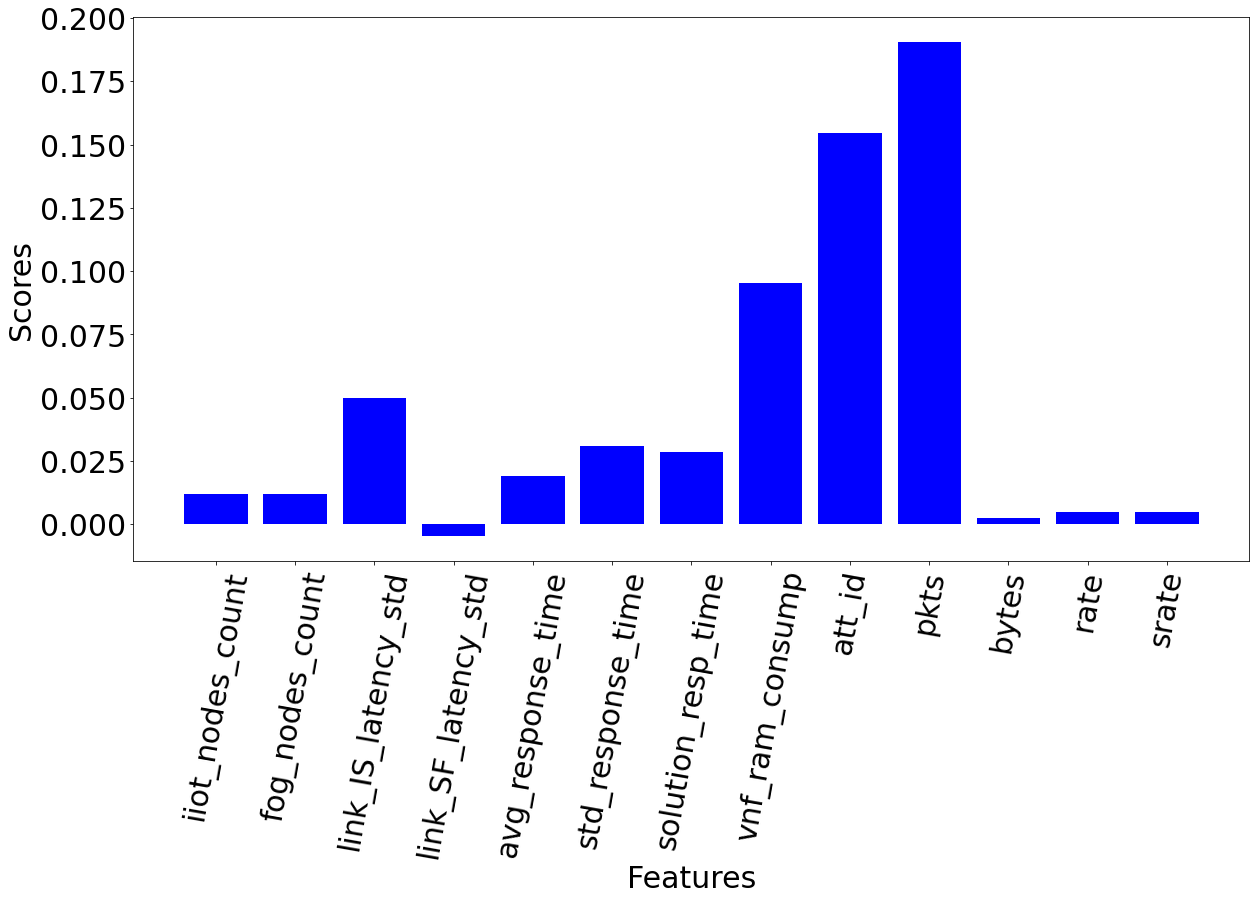

In [163]:
get_feature_importance__(knn_model_iot_fit_model, train, train_z, target_iot)

##Naive Bayes

###Training Study

In [164]:
nb_model_iot = GaussianNB()
nb_y_pred_iot = cvp(nb_model_iot, train_z, target_iot, cv = kfold, n_jobs = 1)

nb_y_pred_iot

array([ 0,  5,  6,  7, 11, 11,  7,  0,  6,  5,  5, 11,  6,  0,  6,  7,  6,
        6,  5,  0,  9,  6,  2,  5,  0,  5,  4,  3,  3,  3,  7, 11, 11,  0,
       11, 11,  6,  7,  0,  9,  7,  6,  3,  0,  6,  6,  0, 11,  9,  5,  5,
        6,  7,  0,  4,  5,  3,  4,  0,  5,  7, 11,  3,  3,  3,  3,  9,  0,
        6, 10,  5, 10,  0, 10, 10, 10, 10,  3,  9, 10,  0,  0, 10,  0])

In [165]:
print_scores(target_iot, nb_y_pred_iot, "Training", "NB")

---Training NB---

Accuracy: 39.2856
Precision: 49.8568
Recall: 39.2856
F1-Score: 39.4616


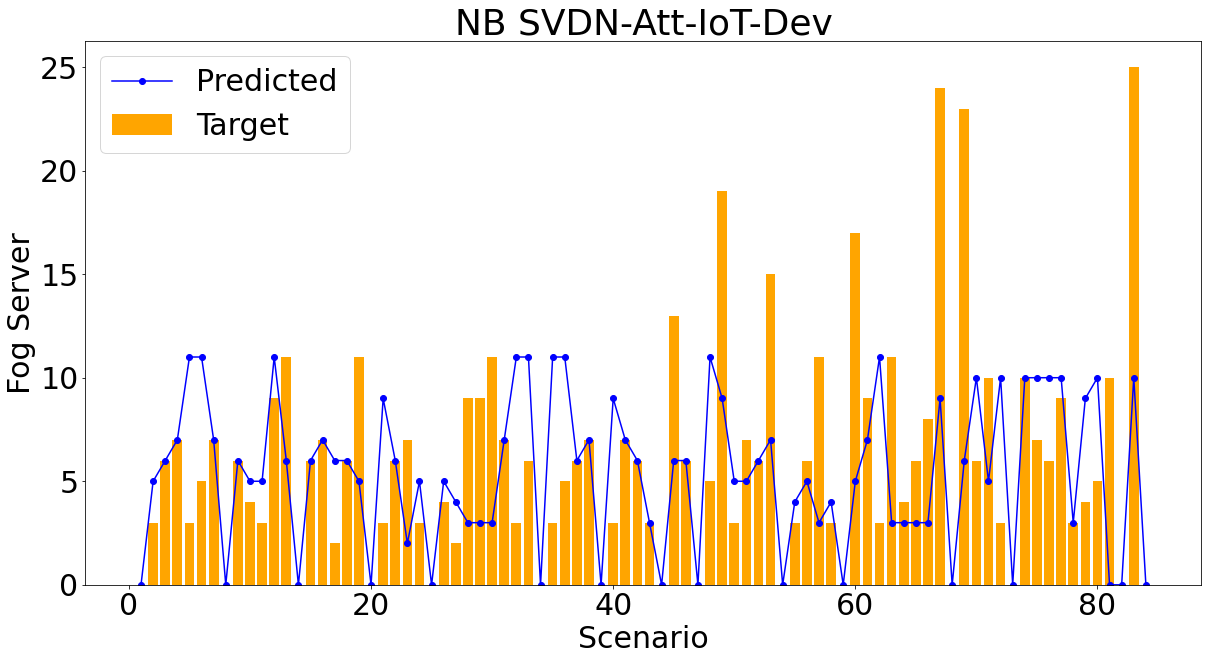

In [166]:
plot_predicted_and_target(target_iot, nb_y_pred_iot, 'NB SVDN-Att-IoT-Dev')

iiot_nodes_count: 0.069048
fog_nodes_count: 0.069048
link_IS_latency_std: 0.061905
link_SF_latency_std: 0.073810
avg_response_time: 0.085714
std_response_time: 0.100000
solution_accuracy: 0.059524
solution_resp_time: 0.111905
vnf_cpu_consump: 0.033333
vnf_ram_consump: 0.054762
vnf_time_deploy: 0.059524
att_id: 0.190476
pkts: 0.130952
bytes: 0.085714
rate: 0.211905
srate: 0.202381
drate: 0.123810


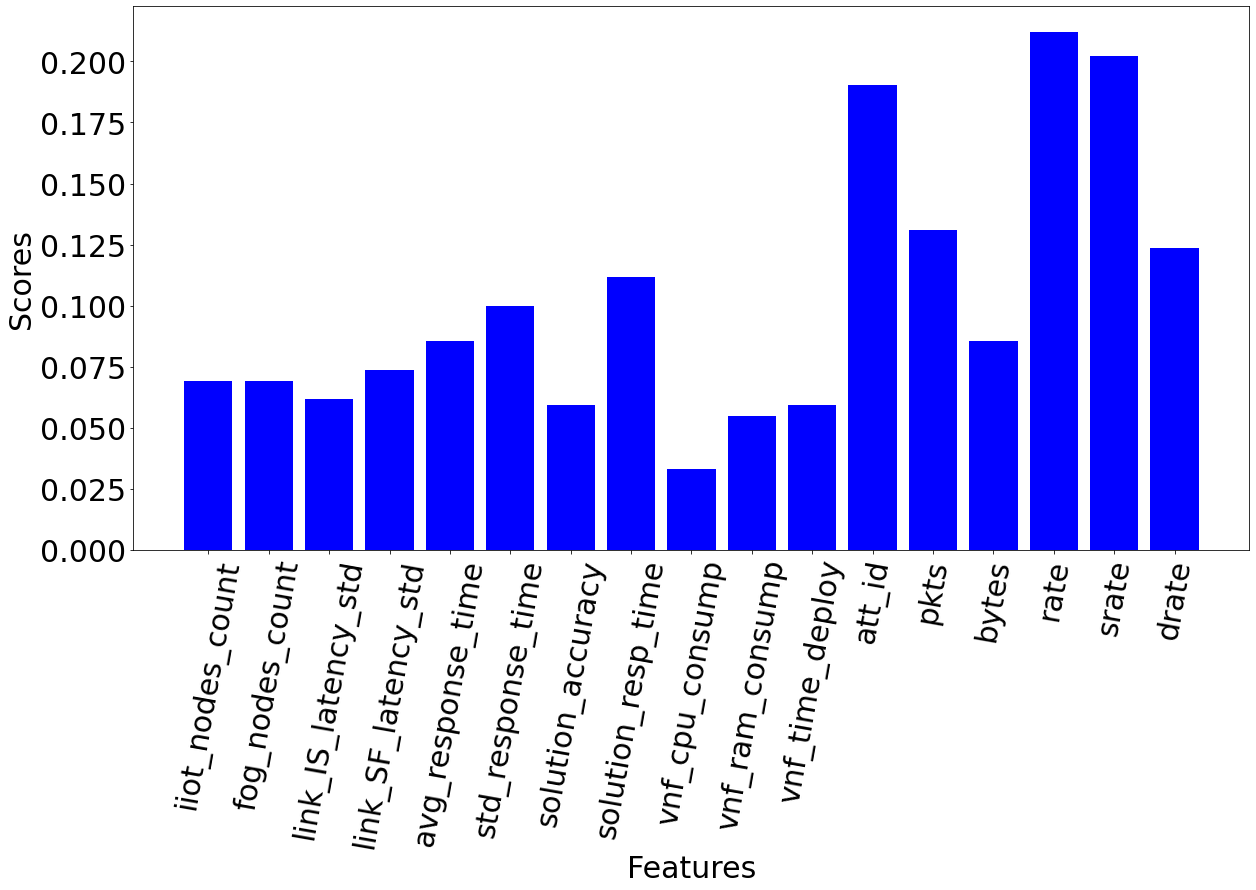

In [167]:
get_feature_importance__(nb_model_iot, train, train_z, target_iot)

###Testing Study

In [168]:
nb_model_iot = GaussianNB()
nb_model_iot_fit_model = nb_model_iot.fit(train, target_iot)
nb_model_iot_fit_y_pred = nb_model_iot_fit_model.predict(test_predict)

nb_model_iot_fit_y_pred

array([ 9,  6,  6,  9, 13,  6,  6,  9,  2,  9,  9,  9,  7,  6,  4,  3,  9,
       23,  9,  9,  6,  7,  2, 25,  7,  8, 24,  7,  9, 23,  9,  9,  2,  4,
        6,  3,  0,  6, 11, 19,  2,  4,  6, 15,  2,  9,  0])

In [169]:
print_scores(test_target_iot, nb_model_iot_fit_y_pred, "Testing", "NB")

---Testing NB---

Accuracy: 40.4254
Precision: 77.1139
Recall: 40.4254
F1-Score: 43.5663


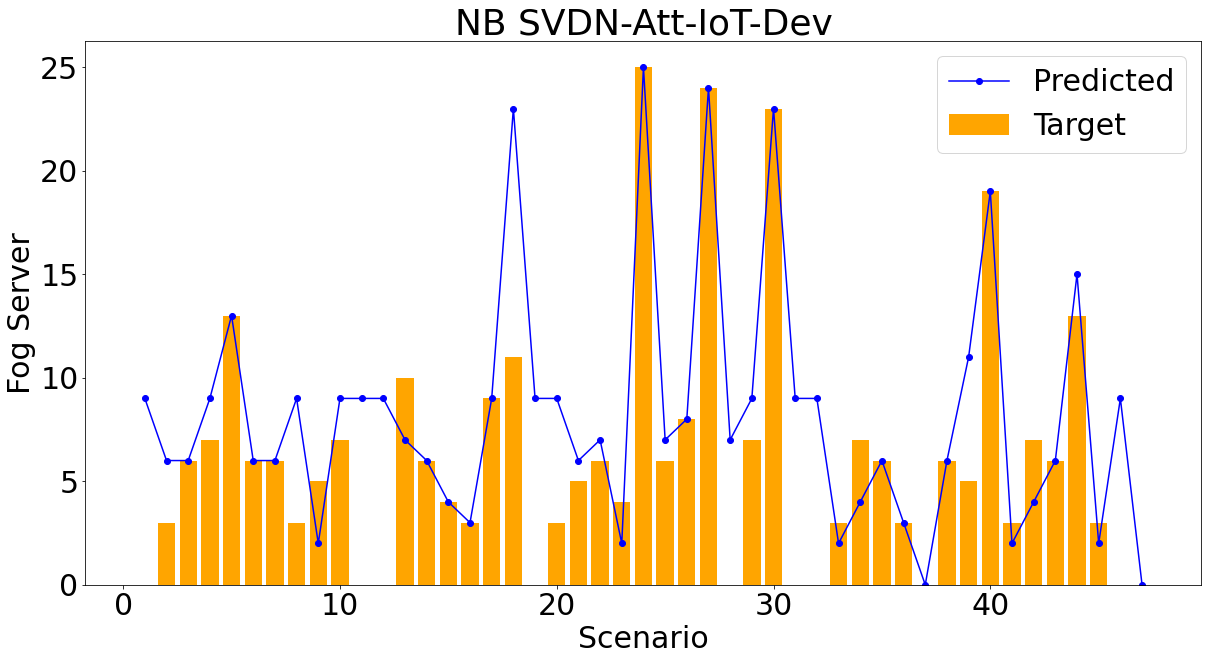

In [170]:
plot_predicted_and_target(test_target_iot, nb_model_iot_fit_y_pred, 'NB SVDN-Att-IoT-Dev')

iiot_nodes_count: 0.057143
fog_nodes_count: 0.057143
link_IS_latency_std: 0.052381
link_SF_latency_std: 0.057143
avg_response_time: 0.076190
std_response_time: 0.090476
solution_accuracy: 0.052381
solution_resp_time: 0.109524
vnf_cpu_consump: 0.030952
vnf_ram_consump: 0.059524
vnf_time_deploy: 0.052381
att_id: 0.197619
pkts: 0.130952
bytes: 0.095238
rate: 0.216667
srate: 0.207143
drate: 0.166667


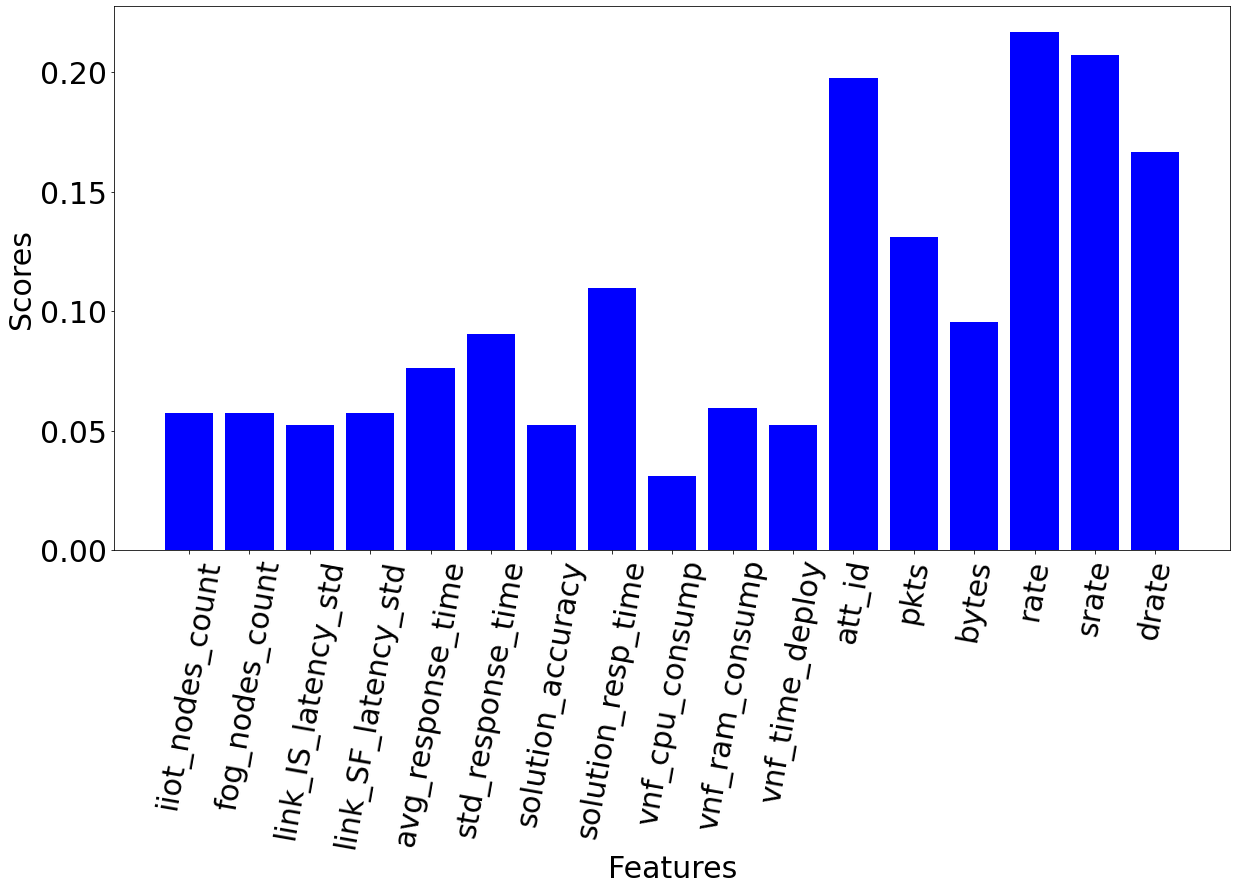

In [171]:
get_feature_importance__(nb_model_iot_fit_model, train, train_z, target_iot)

##K-Means

###Training Study

In [180]:
kmeans_model_iot = KMeans(n_clusters = 18)
kmeans_y_pred_iot = cvp(kmeans_model_iot, train, cv = kfold, n_jobs = 1)

kmeans_y_pred_iot

array([ 4, 12,  5,  6, 13,  5, 16,  4,  8,  4, 14,  4,  9,  0, 16, 16,  9,
       16, 15,  7, 10,  0, 12, 10,  3, 16, 14, 11,  7,  0, 14, 12, 16,  0,
       13,  9,  7, 16,  0,  0,  6,  8, 14,  7,  8,  8,  5, 14,  8,  0,  4,
       16, 12,  0,  4, 12,  0, 16,  4,  0,  8, 13, 14,  5, 14, 17, 13, 11,
        9,  4,  7,  5,  7,  5, 14, 14, 16,  3, 12,  3,  0,  9,  4,  3],
      dtype=int32)

In [182]:
print_scores(target_iot, kmeans_y_pred_iot, "Training", "K-Means")

---Training K-Means---

Accuracy: 8.3332
Precision: 19.4233
Recall: 8.3332
F1-Score: 9.0591


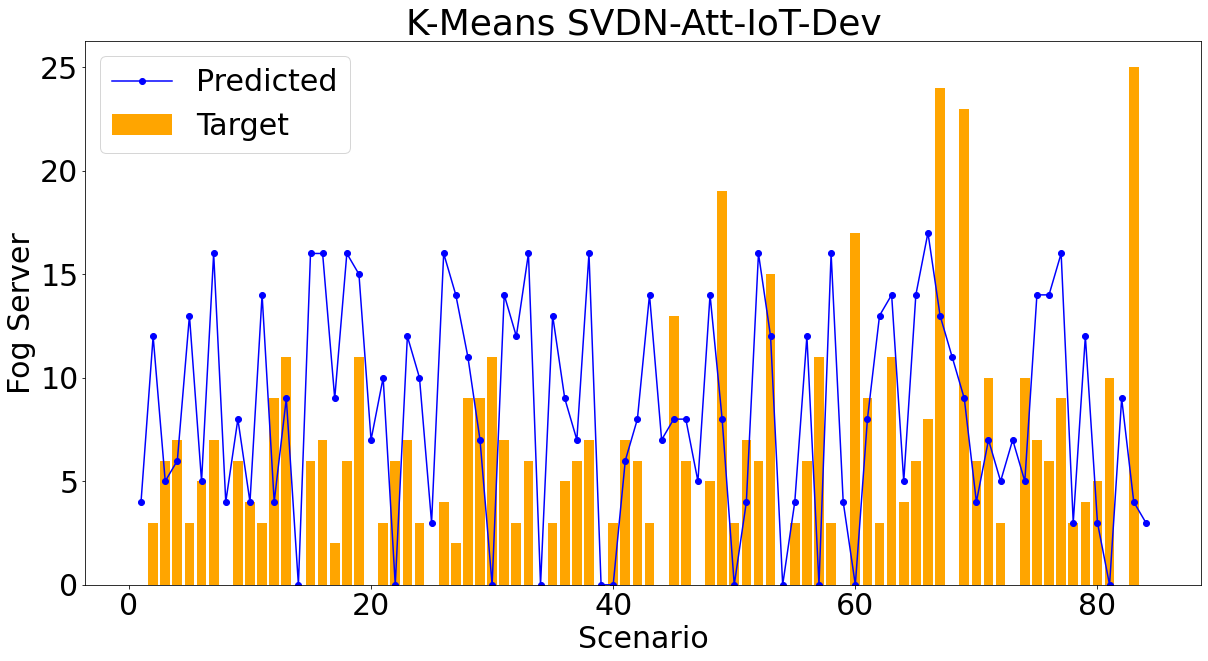

In [183]:
plot_predicted_and_target(target_iot, kmeans_y_pred_iot, 'K-Means SVDN-Att-IoT-Dev')

link_IS_capacity_mean: -0.004762
link_SF_capacity_mean: -0.004762
vnf_cpu_consump: 0.007143
vnf_ram_consump: -0.011905
pkts: -0.007143
bytes: 0.009524


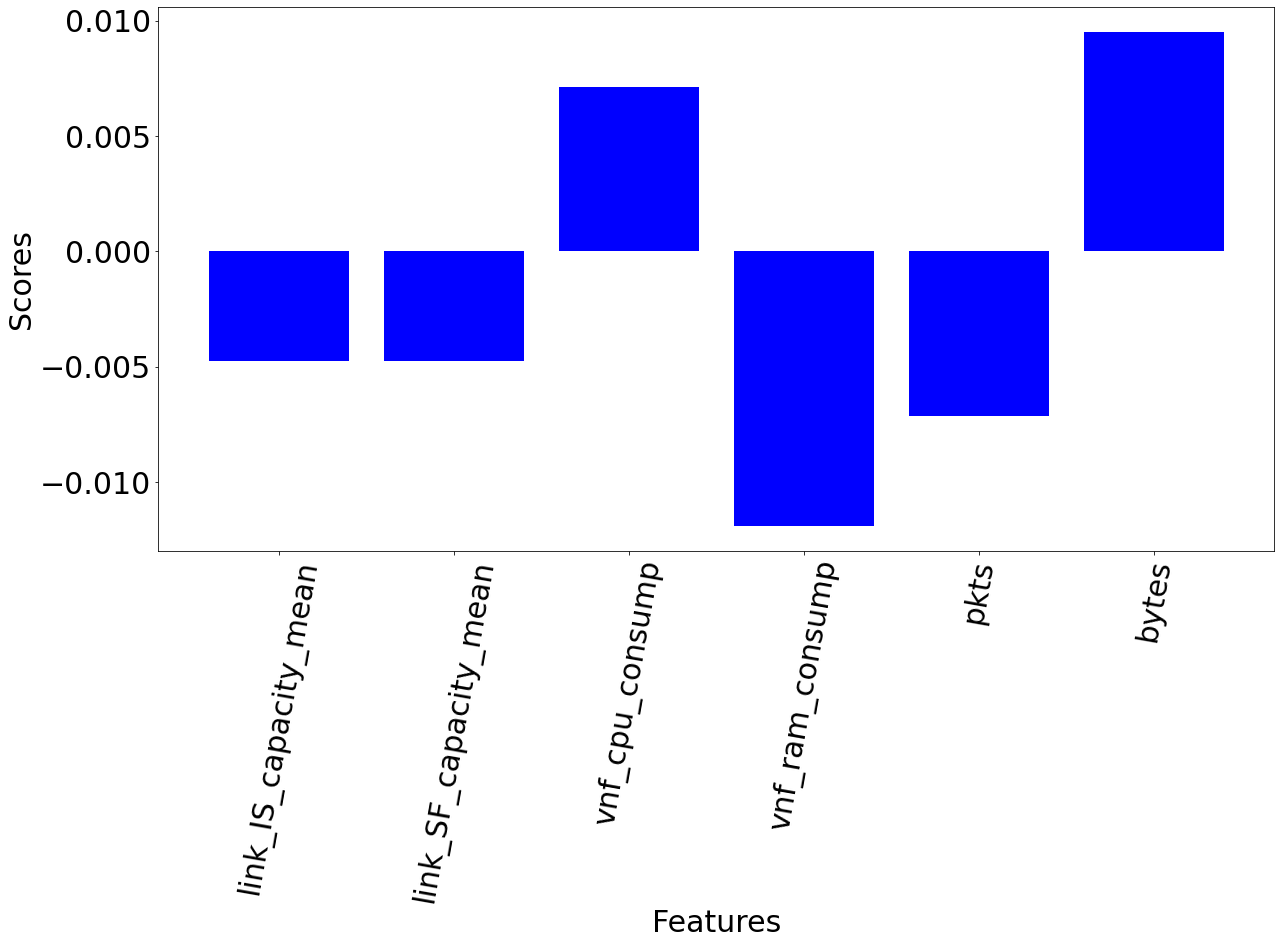

In [188]:
get_feature_importance__(kmeans_model_iot, train, train_n, target_iot)

###Testing Study

In [189]:
kmeans_model_iot = KMeans(n_clusters = 18)
kmeans_model_iot_fit_model = kmeans_model_iot.fit(train)
kmeans_model_iot_fit_y_pred = kmeans_model_iot_fit_model.predict(test_predict)

kmeans_model_iot_fit_y_pred

array([ 0, 12, 13, 14,  4, 12, 13, 15, 10,  7,  0,  0,  5, 13,  8,  9,  0,
        4,  0, 15,  4,  5, 10,  8, 16, 12,  3, 16,  7,  4,  0,  0, 10, 16,
       13,  9,  1, 13,  6,  7, 17,  8, 13, 12, 10,  0,  1], dtype=int32)

In [190]:
print_scores(test_target_iot, kmeans_model_iot_fit_y_pred, "Testing", "K-Means")

---Testing K-Means---

Accuracy: 19.1488
Precision: 36.3474
Recall: 19.1488
F1-Score: 21.8675


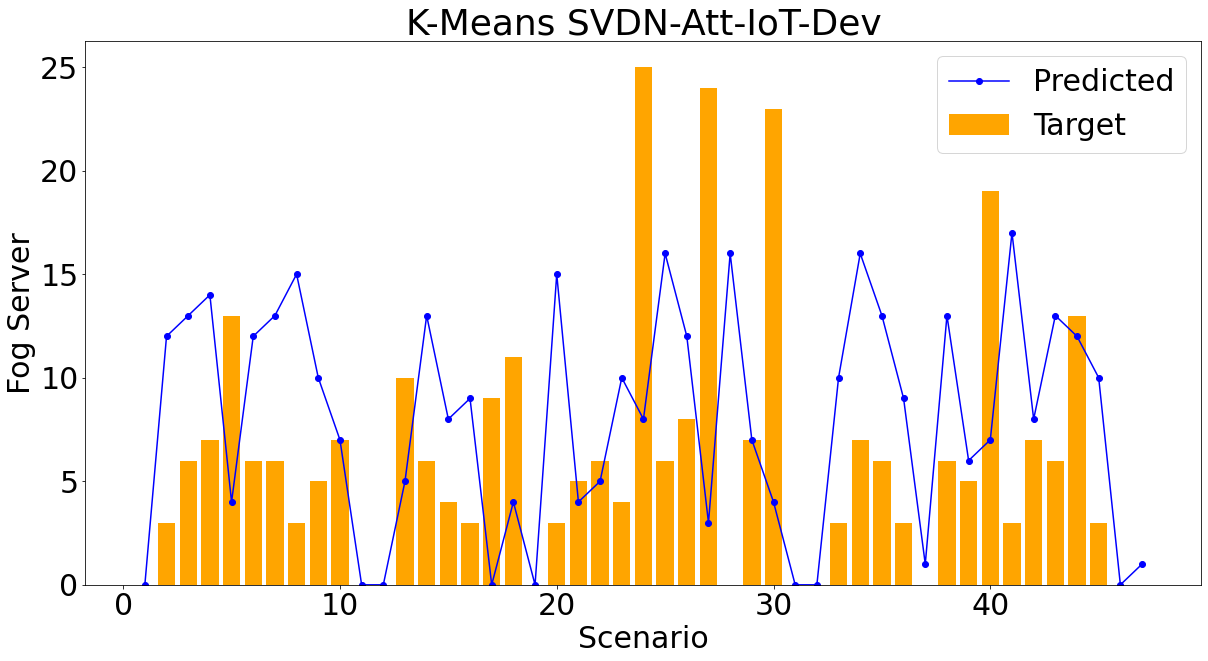

In [191]:
plot_predicted_and_target(test_target_iot, kmeans_model_iot_fit_y_pred, 'K-Means SVDN-Att-IoT-Dev')

iiot_nodes_count: 0.019048
fog_nodes_count: 0.021429
link_IS_latency_std: -0.002381
link_SF_latency_std: 0.007143
std_response_time: 0.002381
solution_resp_time: -0.011905
vnf_ram_consump: -0.023810
att_id: -0.019048


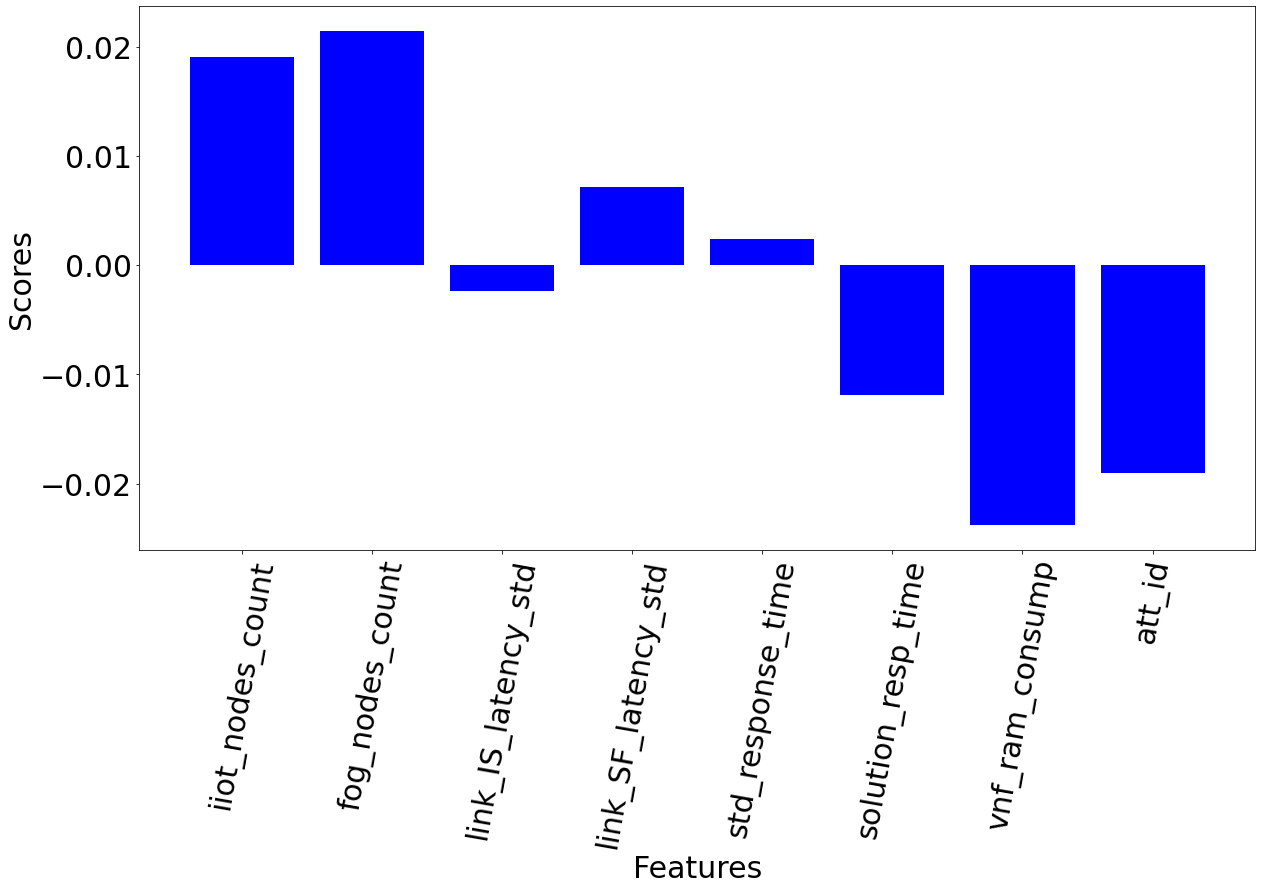

In [192]:
get_feature_importance__(kmeans_model_iot_fit_model, train, train_z, target_iot)

##Hierarchical Cluster

In [193]:
hc_model_iot = AgglomerativeClustering(n_clusters = 18)
hc_y_pred_iot = hc_model_iot.fit_predict(train_z)

hc_y_pred_iot

array([ 6,  9,  9,  9,  9,  9,  9,  6,  9,  9,  9,  9,  9,  6,  9,  4,  4,
        4,  4, 15,  4,  4,  4,  4,  6,  4,  4,  4,  2,  8,  8,  8,  8,  5,
        8,  8,  8,  8,  5,  2, 16, 16, 16, 11,  7,  7,  1,  7,  7,  7,  7,
        7,  7,  1, 14, 14, 14, 14,  1, 14, 14, 10, 10, 10, 10,  2,  2, 12,
       10,  0,  0,  0, 13,  0,  0,  0,  0,  0,  0,  0, 17,  3, 17,  3])

In [194]:
print_scores(target_iot, hc_y_pred_iot, "Training and Testing", "HC")

---Training and Testing HC---

Accuracy: 3.5713
Precision: 7.0300
Recall: 3.5713
F1-Score: 2.5956


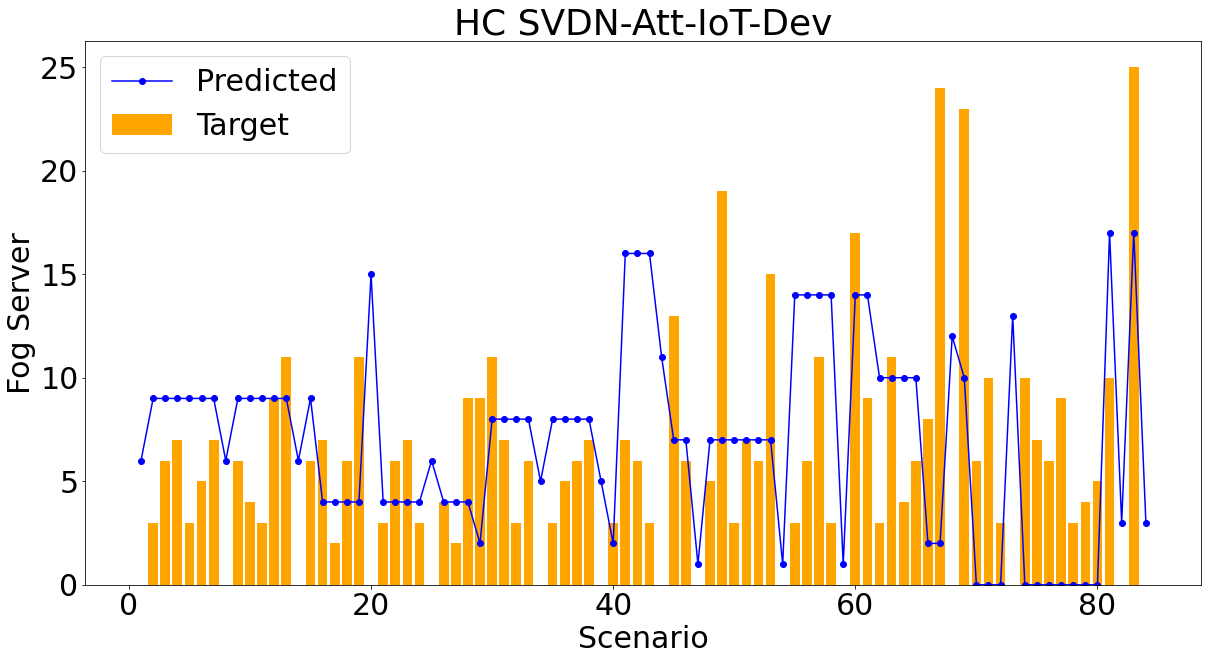

In [195]:
plot_predicted_and_target(target_iot, hc_y_pred_iot, 'HC SVDN-Att-IoT-Dev')

##Gaussian Mixture Model

In [198]:
gmm_model_iot = GaussianMixture(n_components = 18)
gmm_y_pred_iot = gmm_model_iot.fit_predict(train_z)

gmm_y_pred_iot

array([ 4, 13, 13, 13, 13, 13, 13,  4, 13, 13, 13, 13, 13,  4, 13,  8,  8,
        8,  8, 17,  8,  8,  8,  8,  4,  8,  8,  8, 14, 14, 14, 14, 14, 12,
       14, 14, 14, 14, 12,  7,  0,  0,  0,  5, 10, 10, 16, 10, 10, 10, 10,
       10, 10, 16,  1,  1,  1,  1,  1,  1,  1,  9,  9,  9,  9, 11, 11, 15,
        9,  6,  6,  6,  2,  6,  6,  6,  6,  6,  6,  6,  3, 15,  3, 15])

In [199]:
print_scores(target_iot, gmm_y_pred_iot, "Training and Testing", "GMM")

---Training and Testing GMM---

Accuracy: 2.3809
Precision: 8.0951
Recall: 2.3809
F1-Score: 2.7777


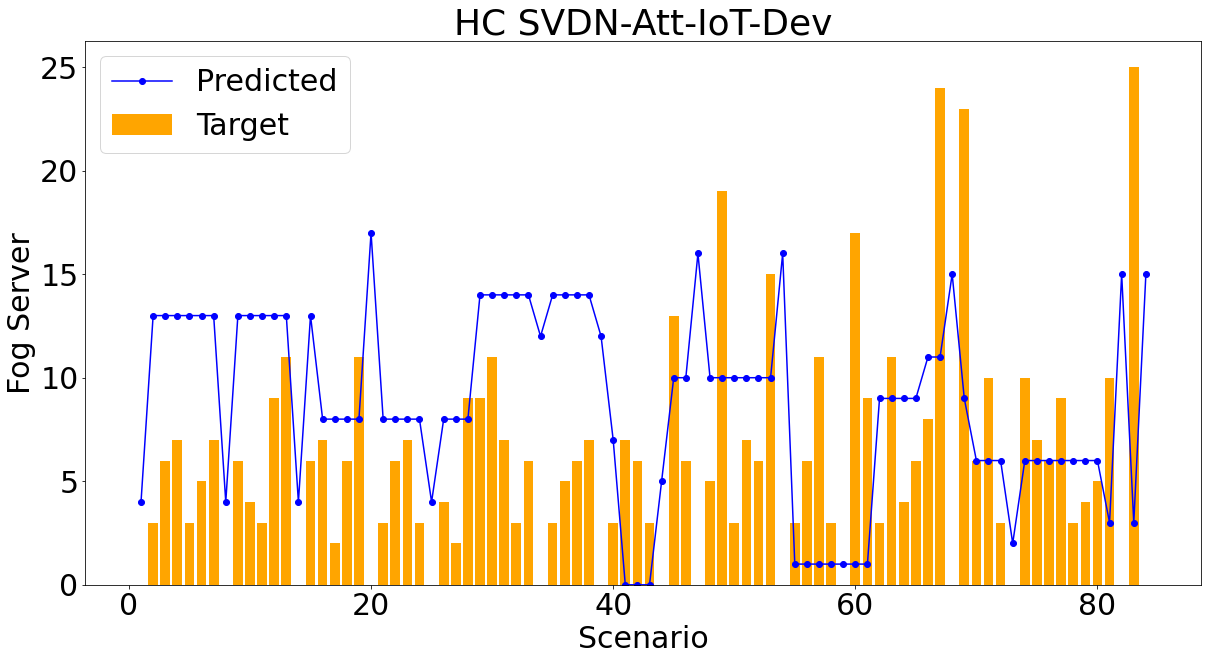

In [200]:
plot_predicted_and_target(target_iot, gmm_y_pred_iot, 'HC SVDN-Att-IoT-Dev')

#Security VNF Deployed Near Attacker Device (SVDN-Att-Dev)

##Decision Tree

###Training Study

In [201]:
dec_tree_model_att =  DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = 6)
dec_tree_y_pred_att = cvp(dec_tree_model_att, train, target_att, cv = kfold, n_jobs = 1)

dec_tree_y_pred_att

array([0, 1, 1, 1, 2, 2, 4, 0, 3, 1, 4, 4, 1, 0, 4, 1, 2, 2, 1, 0, 2, 3,
       2, 3, 0, 4, 3, 1, 3, 2, 4, 2, 1, 0, 2, 1, 4, 4, 0, 2, 3, 4, 4, 0,
       2, 2, 0, 1, 3, 4, 1, 2, 2, 0, 4, 3, 1, 3, 0, 3, 3, 1, 2, 3, 1, 2,
       1, 0, 4, 1, 2, 2, 1, 1, 4, 3, 4, 3, 3, 4, 1, 0, 4, 0])

In [202]:
print_scores(target_att, dec_tree_y_pred_att, "Training", "DT")

---Training DT---

Accuracy: 98.8094
Precision: 98.8689
Recall: 98.8094
F1-Score: 98.8042


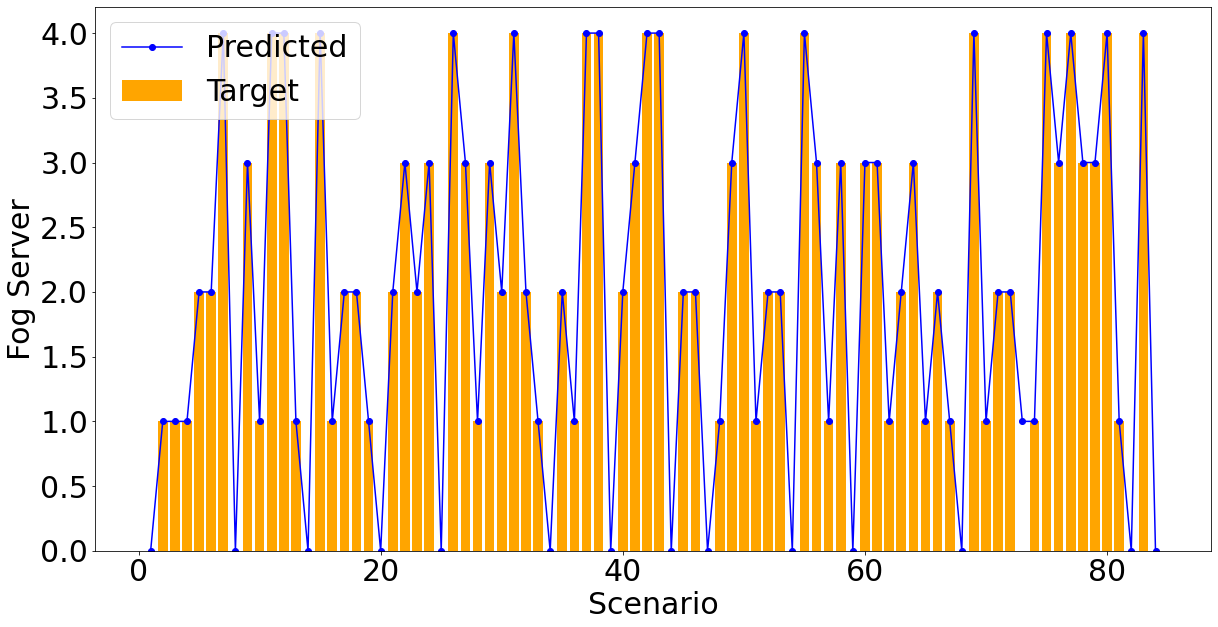

In [211]:
plot_predicted_and_target(target_att, dec_tree_y_pred_att, '')

srate: 57.838033%
link_IS_latency_mean: 11.953657%
bytes: 10.621720%
rate: 10.587346%
pkts: 8.999244%


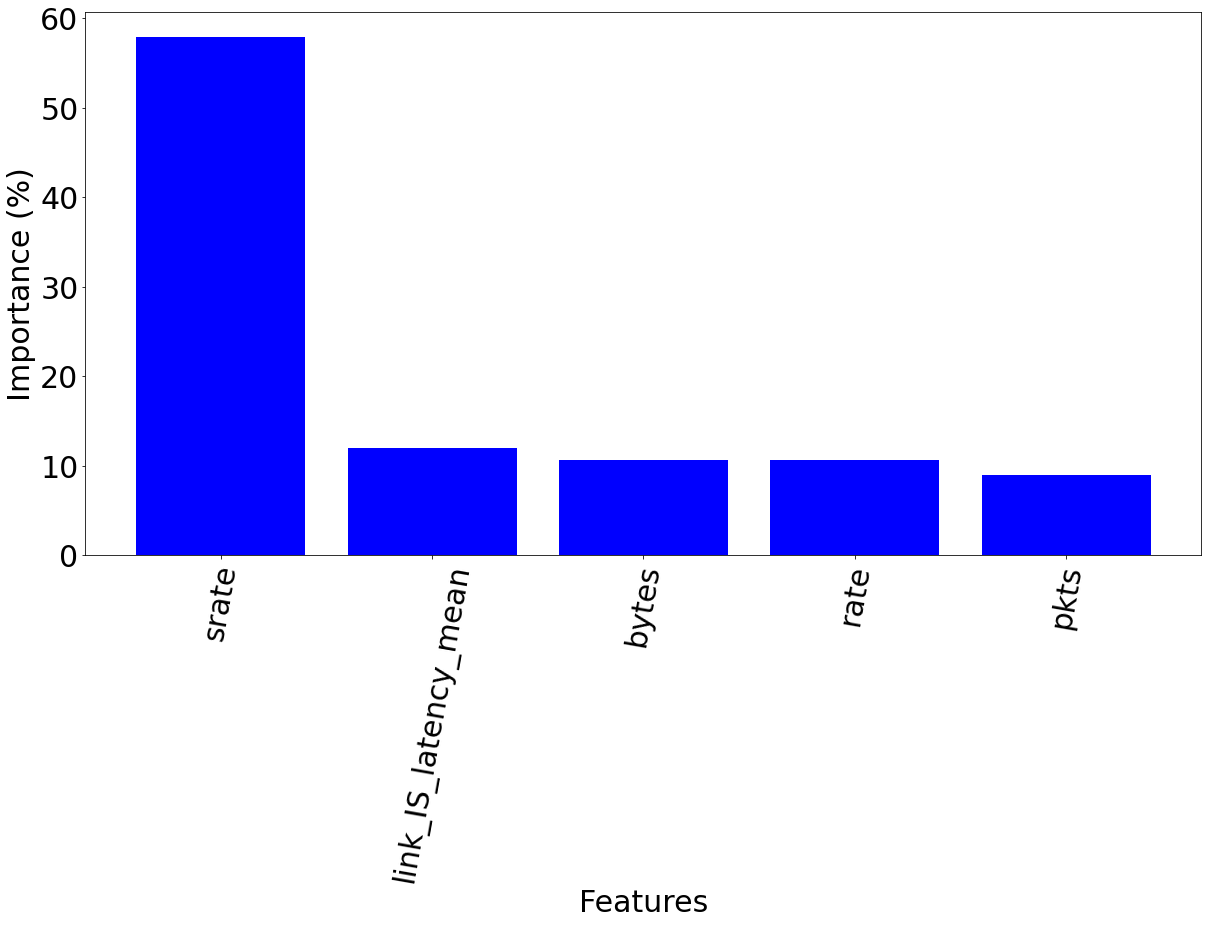

In [206]:
get_feature_importance(dec_tree_model_att, train_n, target_att)

###Testing Study

In [207]:
dec_tree_model_att =  DecisionTreeClassifier(max_depth = 4, max_leaf_nodes = 4)
dec_tree_model_att_fit_model = dec_tree_model_att.fit(train, target_att)
dec_tree_model_att_fit_y_pred = dec_tree_model_att_fit_model.predict(test_predict)

dec_tree_model_att_fit_y_pred

array([0, 1, 1, 1, 2, 1, 2, 2, 2, 4, 0, 0, 2, 4, 1, 4, 4, 1, 0, 2, 1, 4,
       4, 4, 1, 2, 1, 0, 4, 4, 0, 0, 2, 4, 4, 4, 0, 4, 1, 4, 4, 1, 2, 4,
       2, 0, 0])

In [208]:
print_scores(test_target_att, dec_tree_model_att_fit_y_pred, "Testing", "DT")

---Testing DT---

Accuracy: 89.3616
Precision: 92.6861
Recall: 89.3616
F1-Score: 85.0275


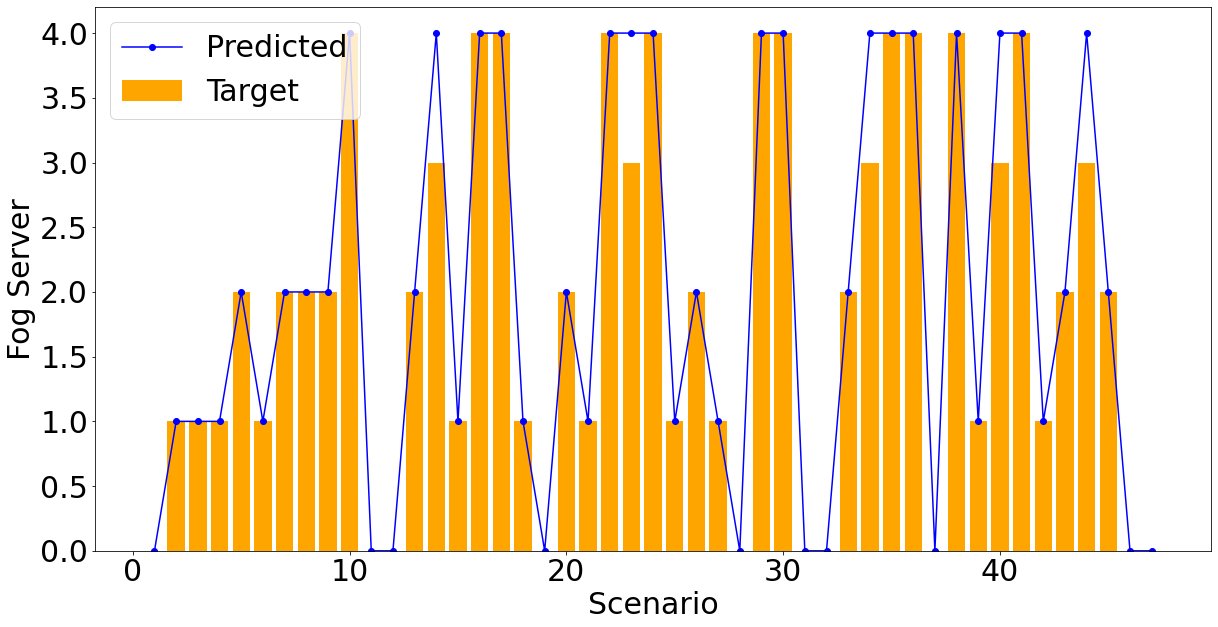

In [209]:
plot_predicted_and_target(test_target_att, dec_tree_model_att_fit_y_pred, '')

srate: 71.925855%
link_IS_latency_mean: 14.865253%
fog_power_std: 13.208891%


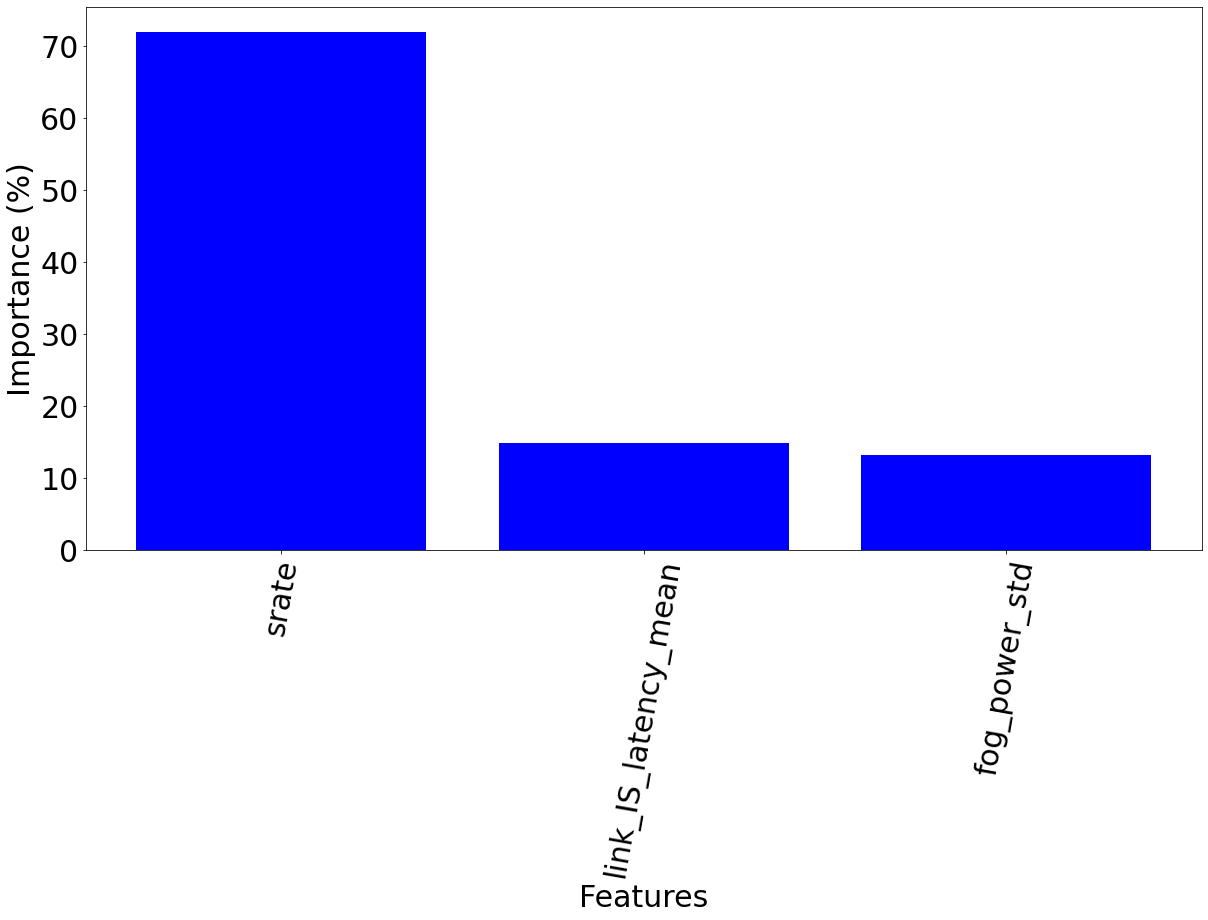

In [223]:
get_feature_importance(dec_tree_model_att_fit_model, train_n, target_att)

##Random Forest

###Training Study

In [224]:
rand_forest_model_att = RandomForestClassifier(max_depth = 4, max_leaf_nodes = 6)
rand_forest_y_pred_att = cvp(rand_forest_model_att, train, target_att, cv = kfold, n_jobs = 1)

rand_forest_y_pred_att

array([0, 1, 1, 1, 2, 2, 4, 0, 2, 1, 4, 4, 1, 0, 4, 1, 2, 2, 1, 1, 2, 2,
       1, 2, 0, 4, 2, 1, 3, 2, 4, 1, 1, 0, 2, 1, 4, 4, 0, 2, 4, 4, 4, 0,
       2, 2, 0, 1, 4, 4, 1, 2, 2, 0, 4, 3, 1, 1, 0, 2, 3, 1, 2, 2, 1, 2,
       1, 0, 4, 1, 2, 2, 0, 3, 4, 3, 4, 2, 3, 4, 1, 1, 4, 0])

In [225]:
print_scores(target_att, rand_forest_y_pred_att, "Training", "RF")

---Training RF---

Accuracy: 82.1428
Precision: 83.4545
Recall: 82.1428
F1-Score: 80.3112


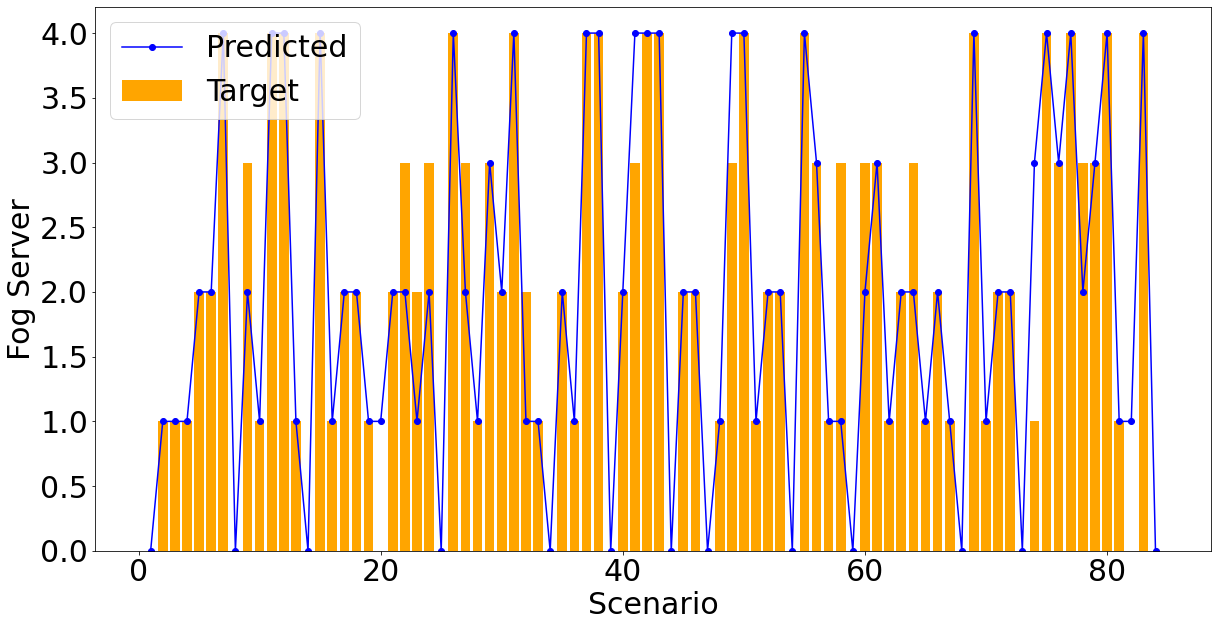

In [227]:
plot_predicted_and_target(target_att, rand_forest_y_pred_att, '')

fog_power_std: 11.439815%
srate: 10.950728%
link_IS_latency_mean: 10.523560%
solution_resp_time: 8.540915%
rate: 7.834140%
bytes: 7.771232%
fog_memory_mean: 7.310222%
std_response_time: 6.504428%
link_SF_latency_mean: 5.663143%
link_SF_capacity_mean: 4.201105%
avg_response_time: 4.180398%
pkts: 3.655992%
att_id: 3.454661%
link_SF_latency_std: 2.528104%
solution_accuracy: 2.467299%
vnf_cpu_consump: 2.255750%
vnf_ram_consump: 0.718509%


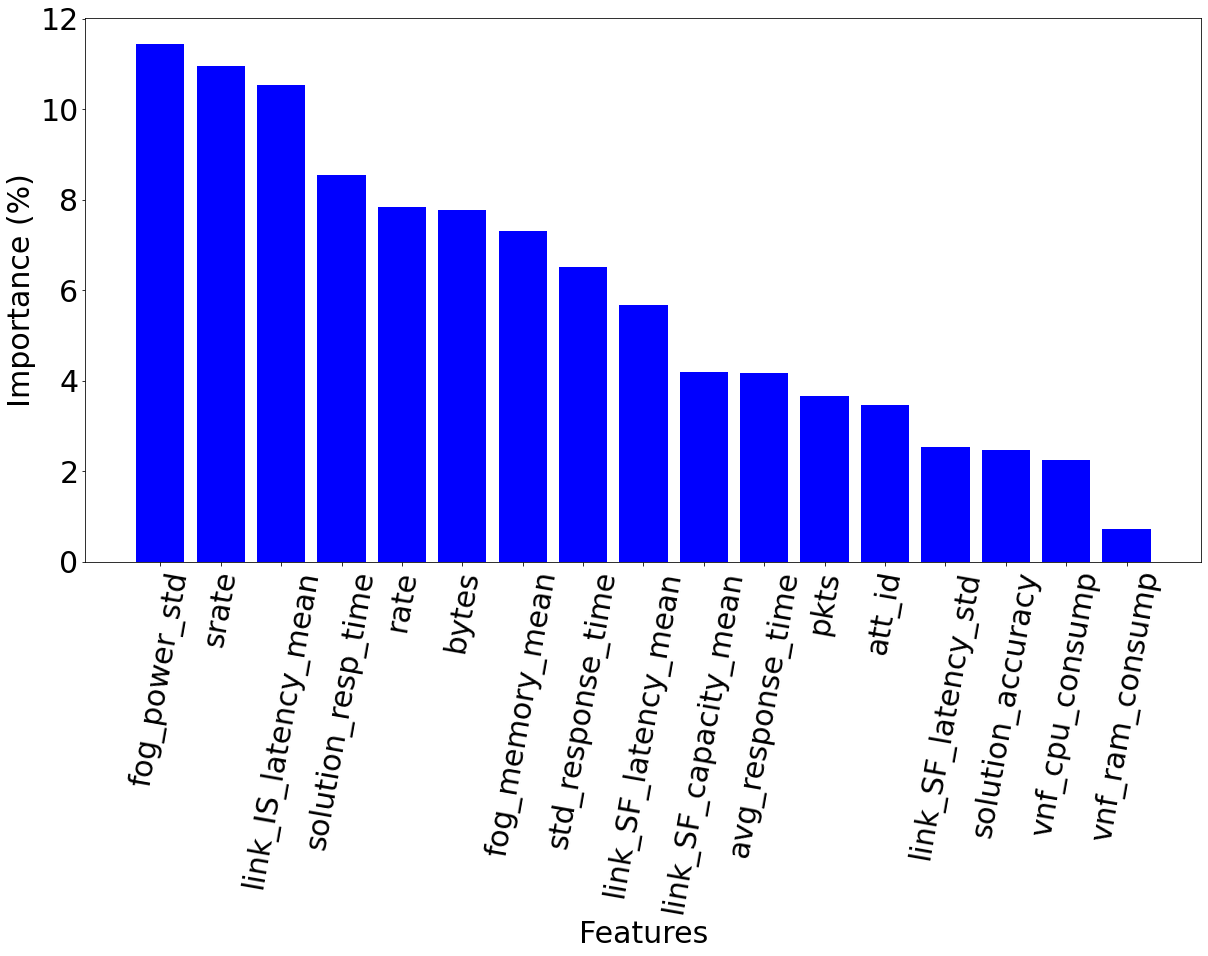

In [229]:
get_feature_importance(rand_forest_model_att, train_n, target_att)

###Testing Study

In [230]:
rand_forest_model_att = RandomForestClassifier(max_depth = 4, max_leaf_nodes = 6)
rand_forest_model_att_fit_model = rand_forest_model_att.fit(train, target_att)
rand_forest_model_att_fit_y_pred = rand_forest_model_att_fit_model.predict(test_predict)

rand_forest_model_att_fit_y_pred

array([0, 1, 1, 1, 2, 1, 2, 2, 2, 4, 0, 0, 2, 2, 1, 4, 4, 1, 0, 2, 1, 4,
       3, 4, 1, 2, 1, 0, 4, 4, 0, 0, 2, 3, 4, 4, 0, 4, 1, 3, 4, 1, 2, 4,
       2, 0, 0])

In [231]:
print_scores(test_target_att, rand_forest_model_att_fit_y_pred, "Testing", "RF")

---Testing RF---

Accuracy: 95.7446
Precision: 96.1153
Recall: 95.7446
F1-Score: 95.3096


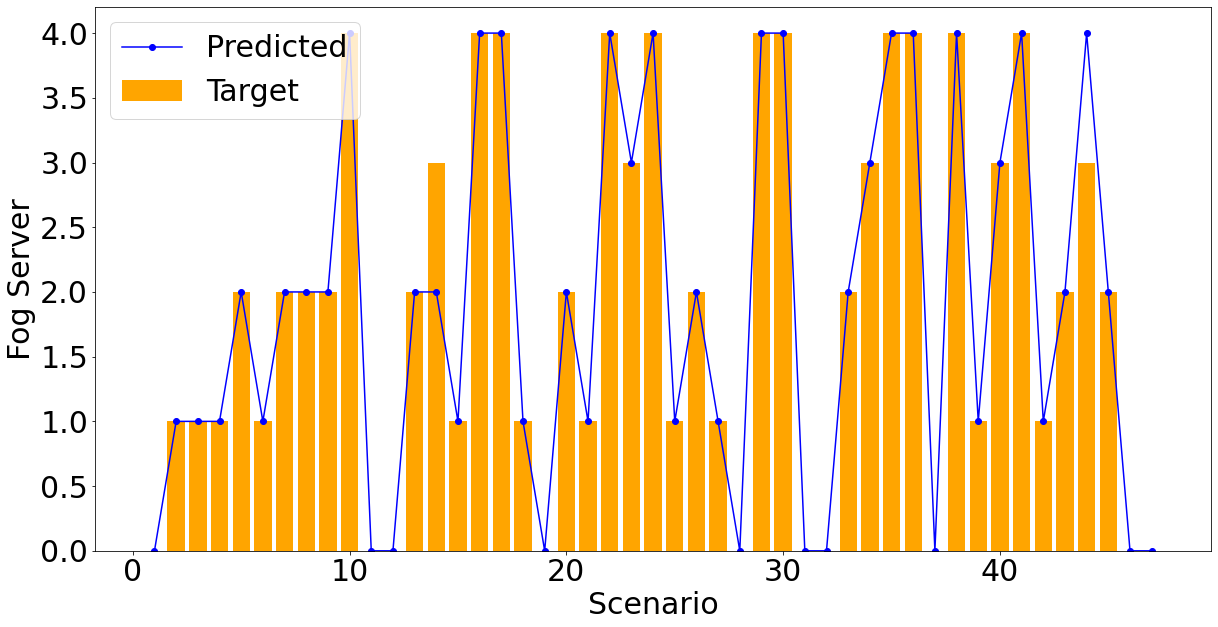

In [234]:
plot_predicted_and_target(test_target_att, rand_forest_model_att_fit_y_pred, '')

srate: 13.308736%
fog_memory_mean: 10.917961%
link_IS_latency_mean: 9.897589%
fog_power_std: 9.472527%
solution_resp_time: 7.369749%
bytes: 7.296951%
avg_response_time: 6.343731%
pkts: 5.831927%
rate: 5.522443%
link_SF_latency_mean: 5.398503%
std_response_time: 4.233180%
solution_accuracy: 3.896673%
att_id: 3.698108%
link_SF_latency_std: 2.655545%
link_SF_capacity_mean: 1.906098%
vnf_cpu_consump: 0.838281%
link_SF_capacity_std: 0.732209%
link_IS_capacity_mean: 0.427552%
vnf_ram_consump: 0.252236%


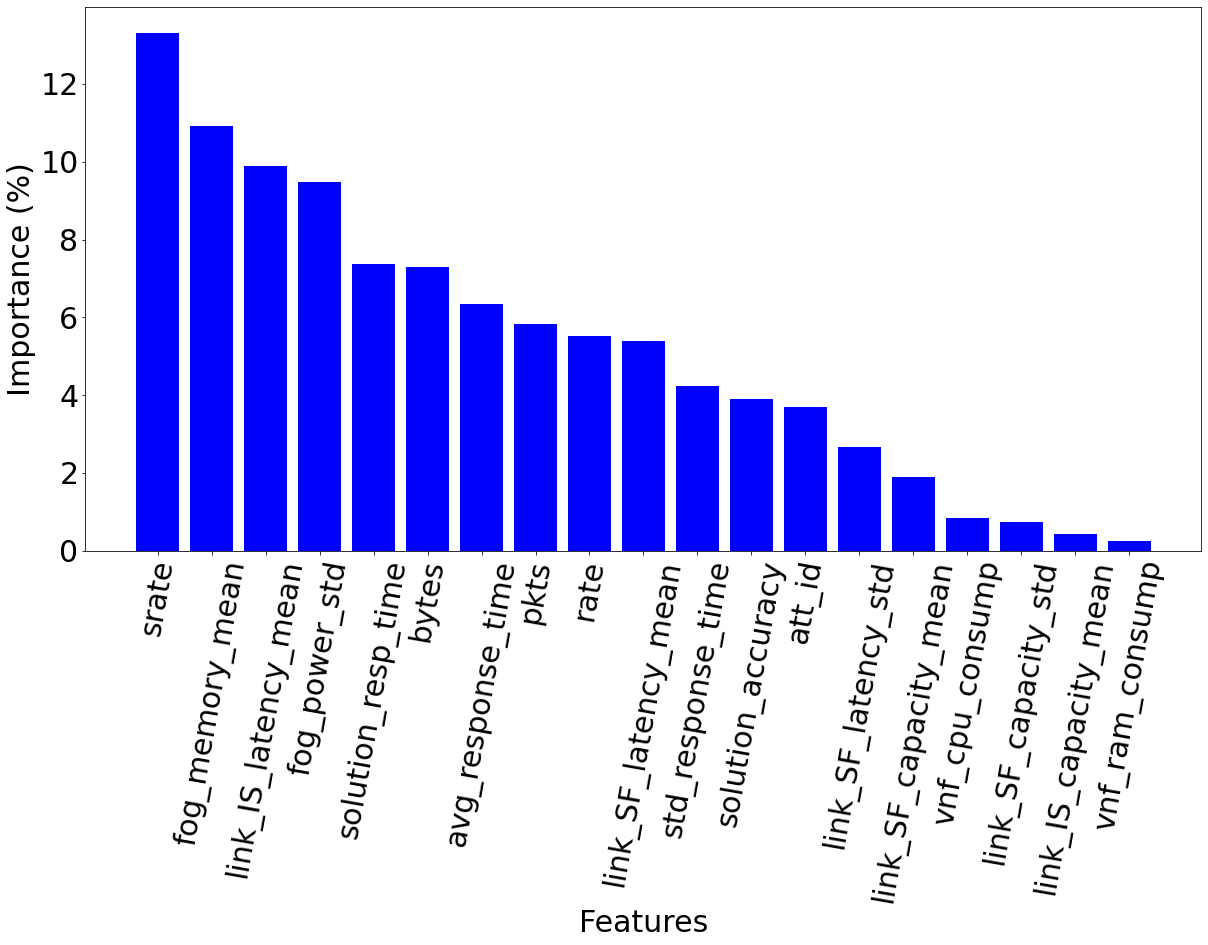

In [235]:
get_feature_importance(rand_forest_model_att_fit_model, train_n, target_att)

##XGBoost

###Training Study

In [236]:
xgb_model_att = XGBClassifier(max_depth = 4, max_leaf_nodes = 6)
xgb_y_pred_att = cvp(xgb_model_att, train, target_att, cv = kfold, n_jobs = 1)

xgb_y_pred_att

array([0, 1, 1, 1, 2, 2, 4, 0, 3, 1, 4, 4, 1, 0, 4, 1, 2, 2, 1, 0, 2, 3,
       2, 3, 0, 4, 3, 1, 3, 2, 4, 2, 1, 0, 2, 1, 4, 4, 0, 2, 3, 4, 4, 0,
       2, 2, 0, 1, 3, 4, 1, 2, 2, 0, 4, 3, 1, 3, 0, 3, 3, 1, 2, 3, 1, 2,
       1, 0, 4, 1, 2, 2, 1, 1, 4, 3, 4, 3, 3, 4, 1, 0, 4, 0])

In [237]:
print_scores(target_att, xgb_y_pred_att, "Training", "XGB")

---Training XGB---

Accuracy: 98.8094
Precision: 98.8689
Recall: 98.8094
F1-Score: 98.8042


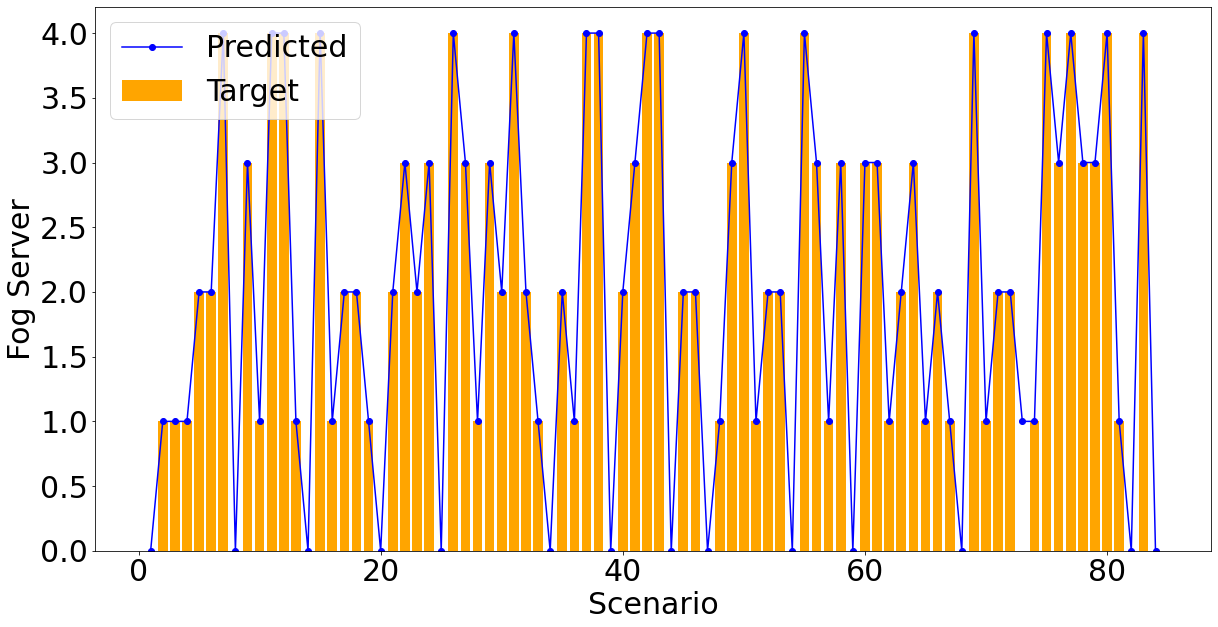

In [244]:
plot_predicted_and_target(target_att, xgb_y_pred_att, '')

vnf_cpu_consump: 15.046471%
vnf_time_deploy: 7.200146%
srate: 6.806457%
link_SF_capacity_mean: 6.597041%
link_SF_capacity_std: 6.327362%
std_response_time: 6.148738%
link_SF_latency_std: 5.955348%
solution_resp_time: 5.891816%
link_SF_latency_mean: 5.764103%
avg_response_time: 5.127767%
link_IS_capacity_std: 4.944800%
bytes: 4.880577%
att_id: 4.000299%
solution_accuracy: 3.994035%
rate: 3.564595%
vnf_ram_consump: 3.470613%
pkts: 2.832708%
fog_memory_mean: 0.994705%
fog_power_mean: 0.452411%


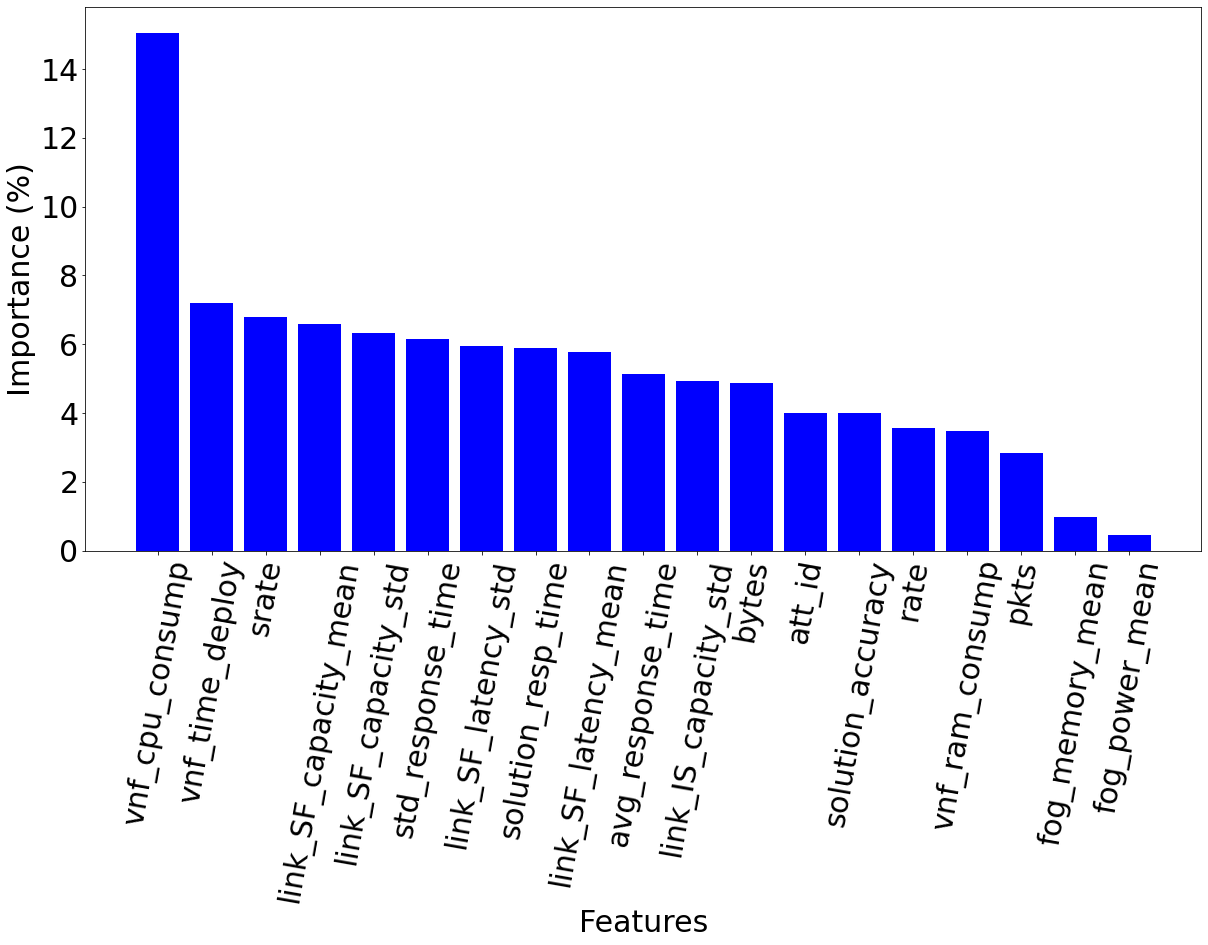

In [239]:
get_feature_importance(xgb_model_att, train_n, target_att)

###Testing Study

In [240]:
xgb_model_att = XGBClassifier(max_depth = 4, max_leaf_nodes = 4)
xgb_model_att_fit_model = xgb_model_att.fit(train, target_att)
xgb_model_att_fit_y_pred = xgb_model_att_fit_model.predict(test_predict)

xgb_model_att_fit_y_pred

array([0, 1, 1, 1, 2, 1, 2, 2, 2, 4, 0, 0, 2, 3, 1, 4, 4, 1, 0, 2, 1, 4,
       3, 4, 1, 2, 1, 0, 4, 4, 0, 0, 2, 3, 4, 4, 0, 4, 1, 3, 4, 1, 2, 3,
       2, 0, 0])

In [241]:
print_scores(test_target_att, xgb_model_att_fit_y_pred, "Testing", "XGB")

---Testing XGB---

Accuracy: 99.9999
Precision: 99.9999
Recall: 99.9999
F1-Score: 99.9999


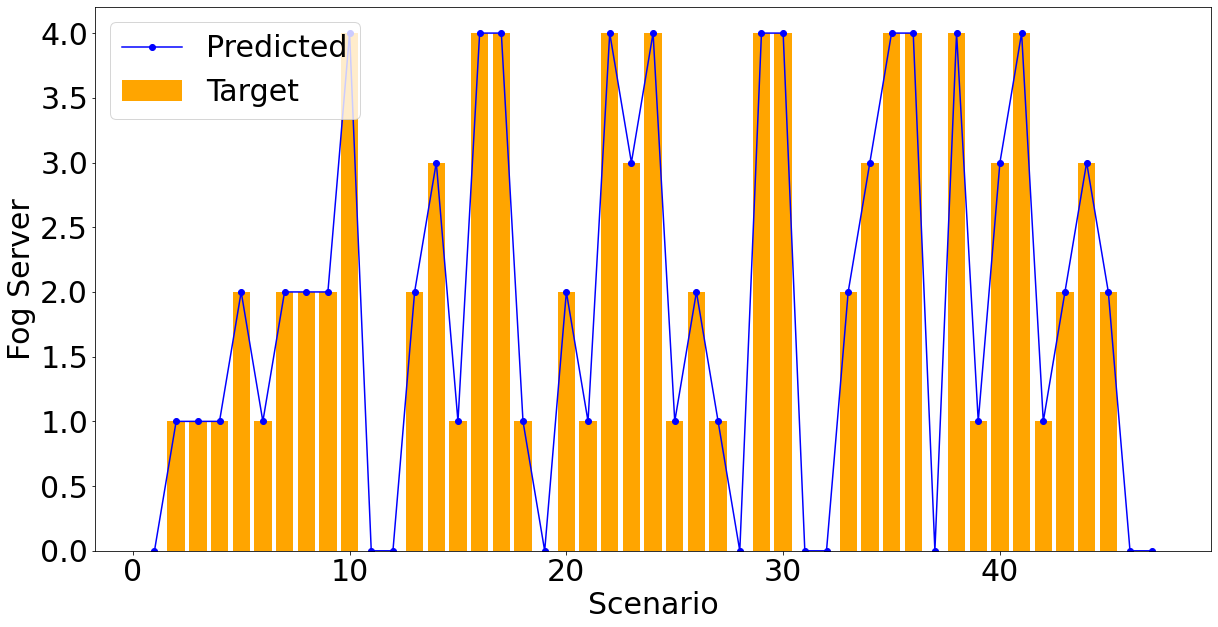

In [243]:
plot_predicted_and_target(test_target_att, xgb_model_att_fit_y_pred, '')

vnf_cpu_consump: 15.046471%
vnf_time_deploy: 7.200146%
srate: 6.806457%
link_SF_capacity_mean: 6.597041%
link_SF_capacity_std: 6.327362%
std_response_time: 6.148738%
link_SF_latency_std: 5.955348%
solution_resp_time: 5.891816%
link_SF_latency_mean: 5.764103%
avg_response_time: 5.127767%
link_IS_capacity_std: 4.944800%
bytes: 4.880577%
att_id: 4.000299%
solution_accuracy: 3.994035%
rate: 3.564595%
vnf_ram_consump: 3.470613%
pkts: 2.832708%
fog_memory_mean: 0.994705%
fog_power_mean: 0.452411%


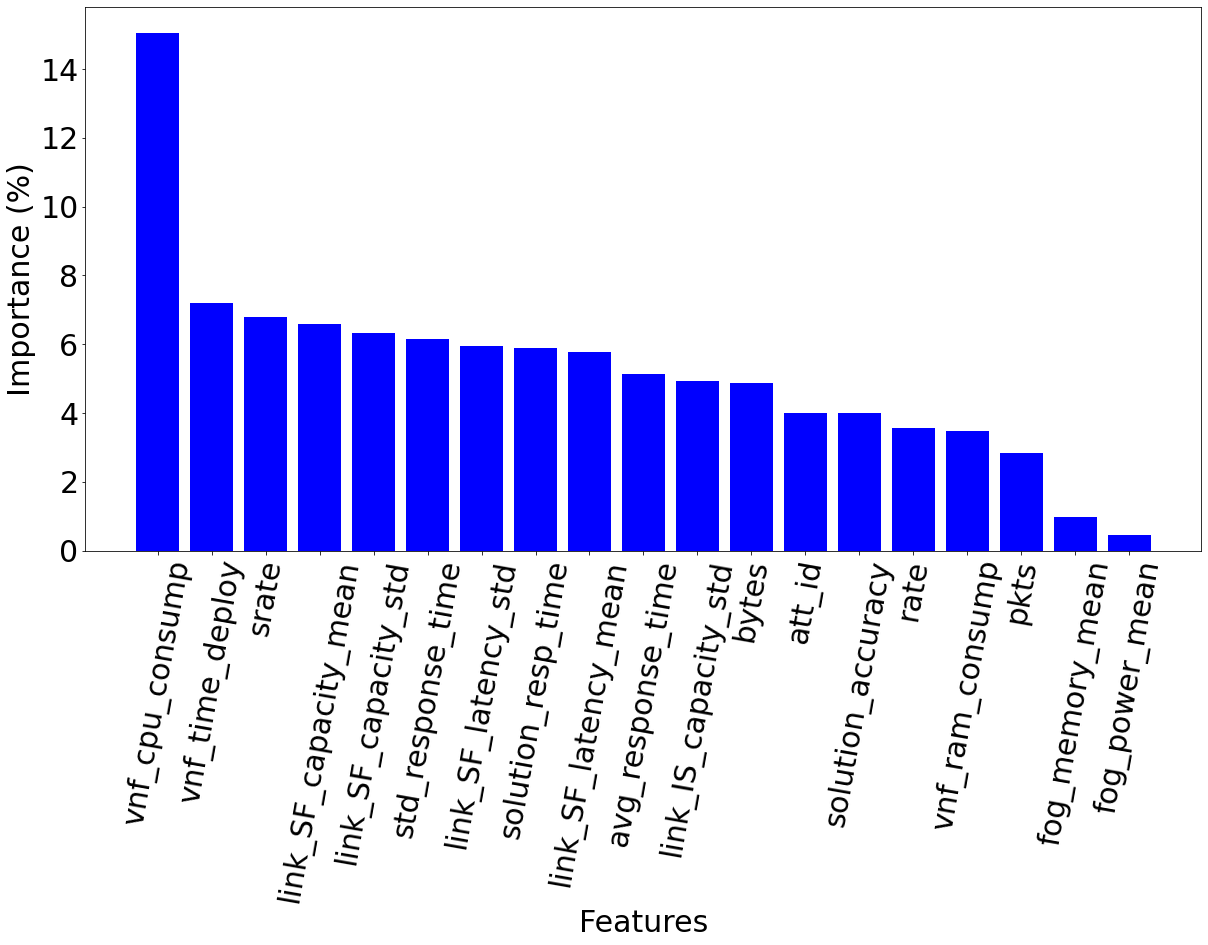

In [245]:
get_feature_importance(xgb_model_att_fit_model, train_n, target_att)

##Logistic Regression

###Training Study

In [246]:
log_reg_model_att = LogisticRegression()
log_reg_y_pred_att = cvp(log_reg_model_att, train_z, target_att, cv = kfold, n_jobs = 1)

log_reg_y_pred_att

array([0, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 4, 1, 0, 2, 3, 3, 3, 1, 0, 1, 3,
       3, 1, 0, 3, 3, 4, 2, 2, 2, 1, 2, 0, 4, 2, 4, 4, 0, 2, 4, 3, 3, 0,
       1, 2, 0, 2, 2, 2, 2, 2, 1, 0, 3, 3, 3, 3, 0, 3, 3, 2, 1, 4, 2, 1,
       2, 0, 3, 2, 4, 2, 0, 3, 3, 3, 3, 4, 3, 3, 4, 0, 1, 0])

In [247]:
print_scores(target_att, log_reg_y_pred_att, "Training", "LR")

---Training LR---

Accuracy: 40.4761
Precision: 39.8159
Recall: 40.4761
F1-Score: 39.4251


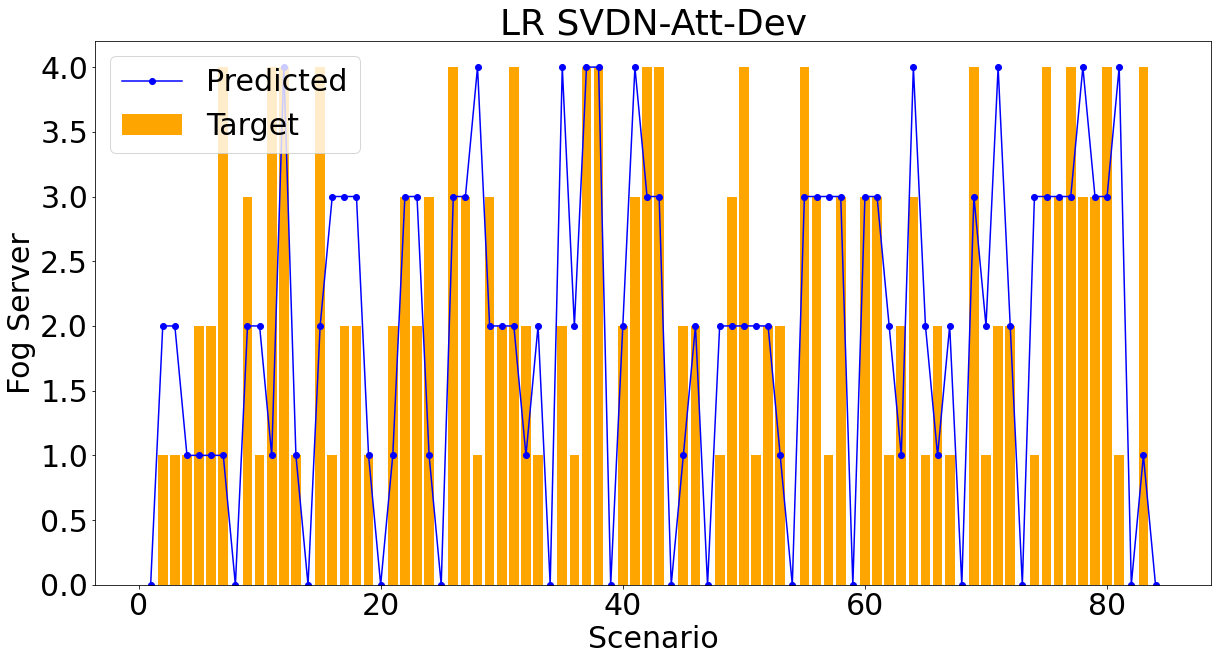

In [248]:
plot_predicted_and_target(target_att, log_reg_y_pred_att, 'LR SVDN-Att-Dev')

iiot_nodes_count: -0.031735
fog_nodes_count: -0.032089
link_IS_latency_mean: 0.000000
link_IS_latency_std: 0.055647
link_SF_latency_mean: 0.000000
link_SF_latency_std: -0.030158
avg_response_time: 0.008331
std_response_time: -0.033347
solution_accuracy: -0.048762
solution_resp_time: 0.176636
vnf_cpu_consump: 0.045403
vnf_ram_consump: 0.061947
vnf_time_deploy: -0.048216
att_id: -2.043853
pkts: -0.370667
bytes: 0.252138
rate: 0.418804
srate: 0.441370
drate: 0.144955


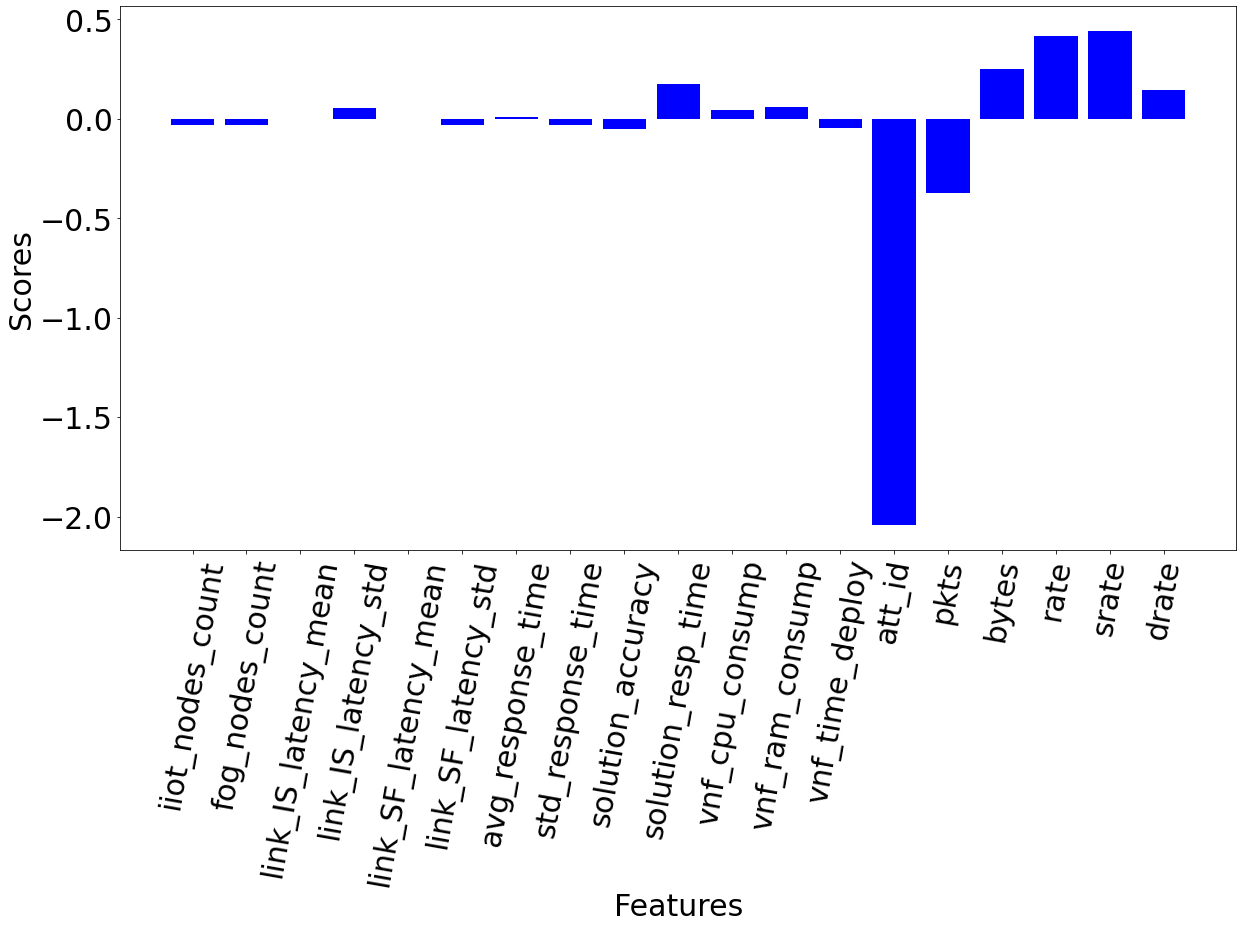

In [249]:
get_feature_importance_(log_reg_model_att, train, train_z, target_att)

###Testing Study

In [250]:
log_reg_model_att = LogisticRegression()
log_reg_model_att_fit_model = log_reg_model_att.fit(train, target_att)
log_reg_model_att_fit_y_pred = log_reg_model_att_fit_model.predict(test_predict)

log_reg_model_att_fit_y_pred

array([0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 2, 2,
       2, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 1, 2, 2, 1, 2, 1,
       2, 0, 0])

In [251]:
print_scores(test_target_att, log_reg_model_att_fit_y_pred, "Testing", "LR")

---Testing LR---

Accuracy: 48.9361
Precision: 70.6027
Recall: 48.9361
F1-Score: 40.2668


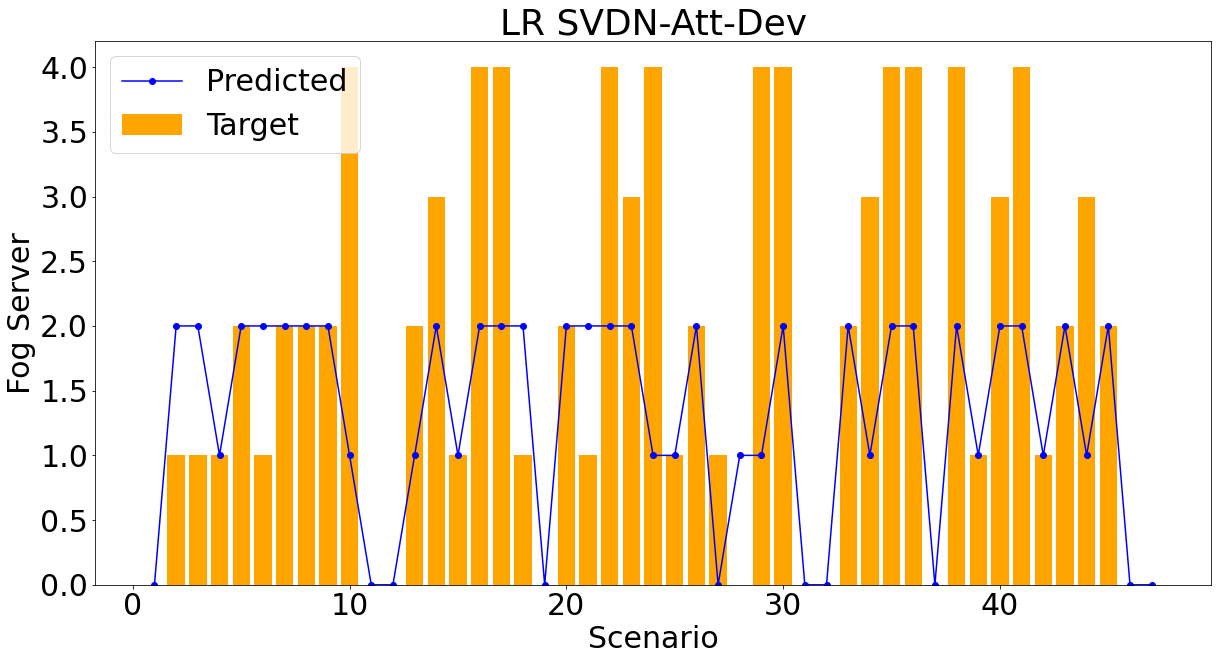

In [252]:
plot_predicted_and_target(test_target_att, log_reg_model_att_fit_y_pred, 'LR SVDN-Att-Dev')

iiot_nodes_count: -0.031735
fog_nodes_count: -0.032089
link_IS_latency_mean: 0.000000
link_IS_latency_std: 0.055647
link_SF_latency_mean: 0.000000
link_SF_latency_std: -0.030158
avg_response_time: 0.008331
std_response_time: -0.033347
solution_accuracy: -0.048762
solution_resp_time: 0.176636
vnf_cpu_consump: 0.045403
vnf_ram_consump: 0.061947
vnf_time_deploy: -0.048216
att_id: -2.043853
pkts: -0.370667
bytes: 0.252138
rate: 0.418804
srate: 0.441370
drate: 0.144955


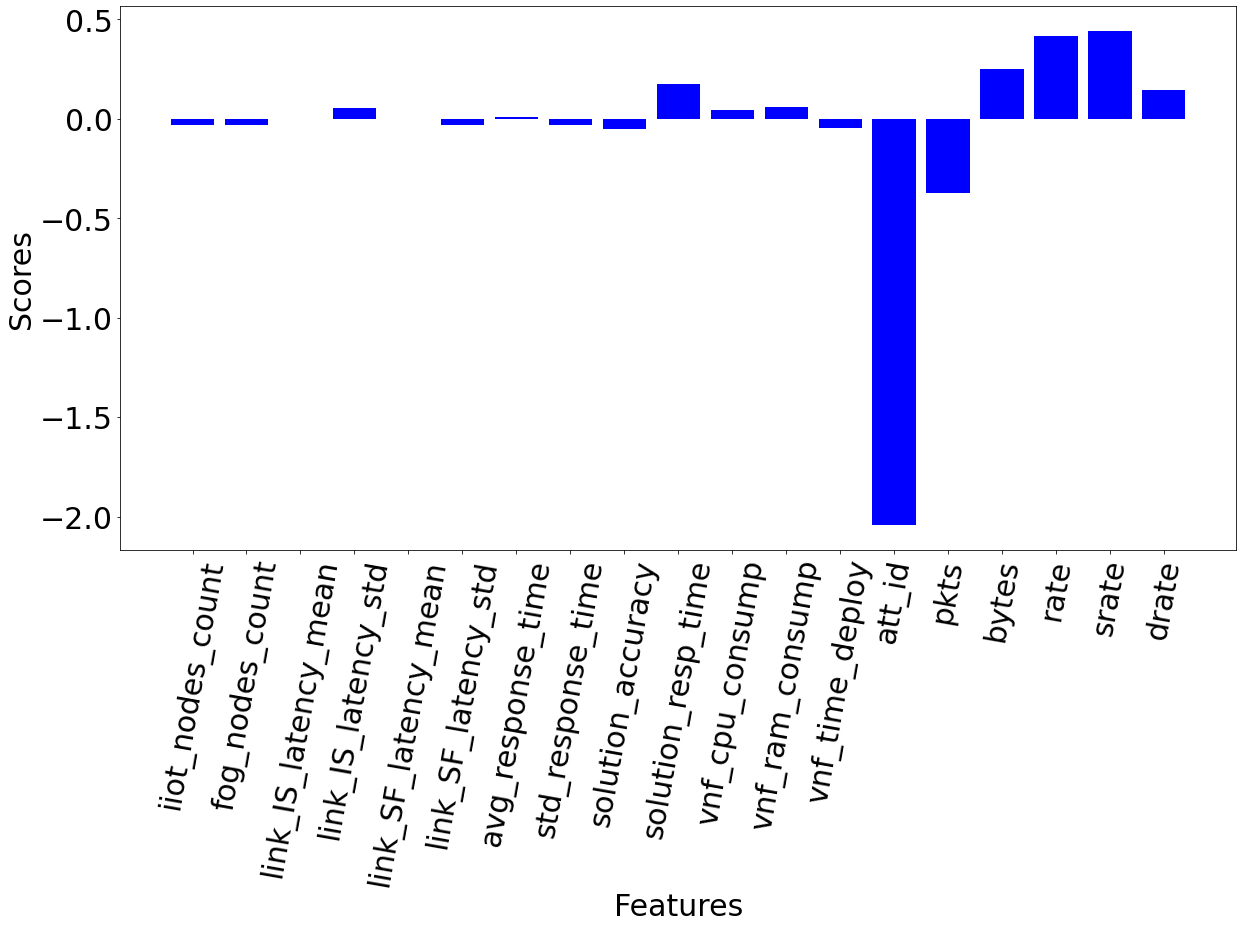

In [253]:
get_feature_importance_(log_reg_model_att_fit_model, train, train_z, target_att)

##Support Vector Machine

###Training Study

In [284]:
svm_model_att = SVC(C = 1e6, kernel = 'linear')
svm_y_pred_att = cvp(svm_model_att, train_n, target_att, cv = kfold, n_jobs = 1)

svm_y_pred_att

array([0, 2, 2, 1, 2, 2, 1, 0, 2, 4, 2, 1, 2, 1, 2, 4, 2, 2, 4, 0, 1, 2,
       4, 4, 0, 1, 2, 1, 4, 2, 1, 4, 2, 0, 2, 2, 2, 4, 0, 2, 1, 2, 2, 0,
       2, 2, 0, 4, 2, 2, 4, 2, 4, 0, 1, 4, 4, 1, 0, 2, 4, 1, 2, 2, 4, 2,
       0, 4, 2, 2, 4, 2, 0, 2, 4, 2, 1, 2, 4, 4, 4, 0, 1, 0])

In [285]:
print_scores(target_att, svm_y_pred_att, "Training", "SVM")

---Training SVM---

Accuracy: 38.0951
Precision: 50.1360
Recall: 38.0951
F1-Score: 33.8299


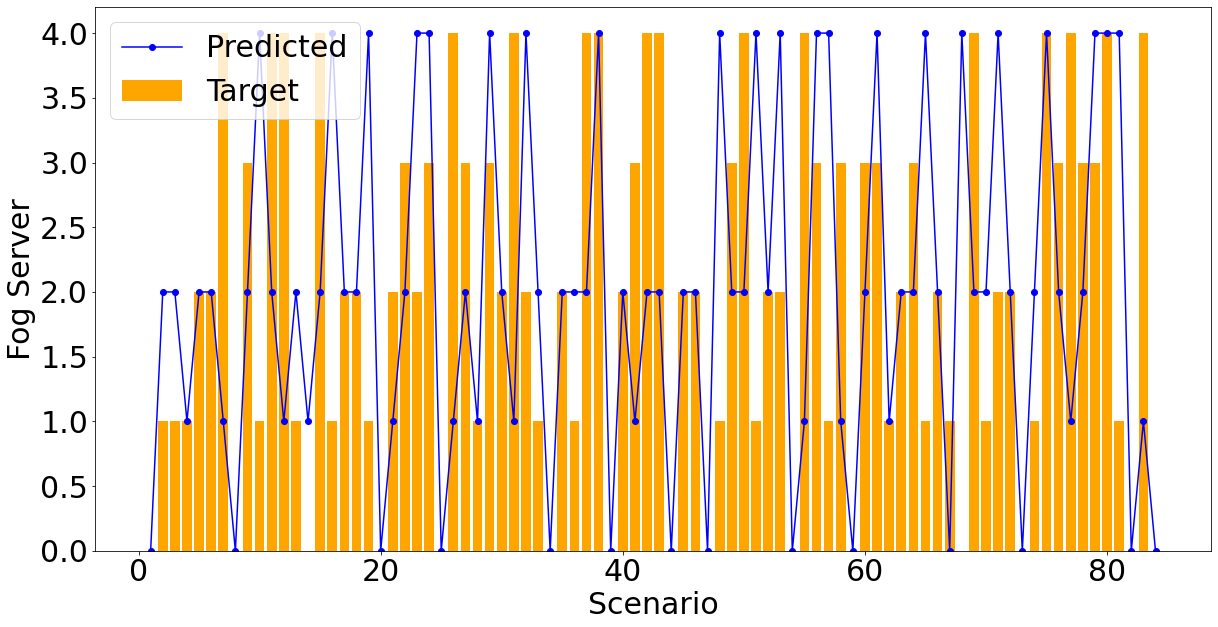

In [286]:
plot_predicted_and_target(target_att, svm_y_pred_att, '')

iiot_nodes_count: -11.084969
fog_nodes_count: -3.972877
fog_power_mean: -9.943480
fog_memory_mean: -12.429350
link_IS_latency_mean: -0.000025
link_IS_latency_std: -0.000000
link_IS_capacity_mean: -99.434796
link_SF_latency_mean: -0.000025
link_SF_latency_std: -0.000000
link_SF_capacity_mean: -99.434796
avg_response_time: -0.335003
std_response_time: -0.006576
solution_accuracy: -1.918031
solution_resp_time: -17.887705
vnf_cpu_consump: 254.993817
vnf_ram_consump: 145.715949
vnf_time_deploy: -1.106652
att_id: -22.366616
pkts: -317.740753
bytes: -659.240344
rate: 0.111586
srate: 0.272514
drate: -0.141522


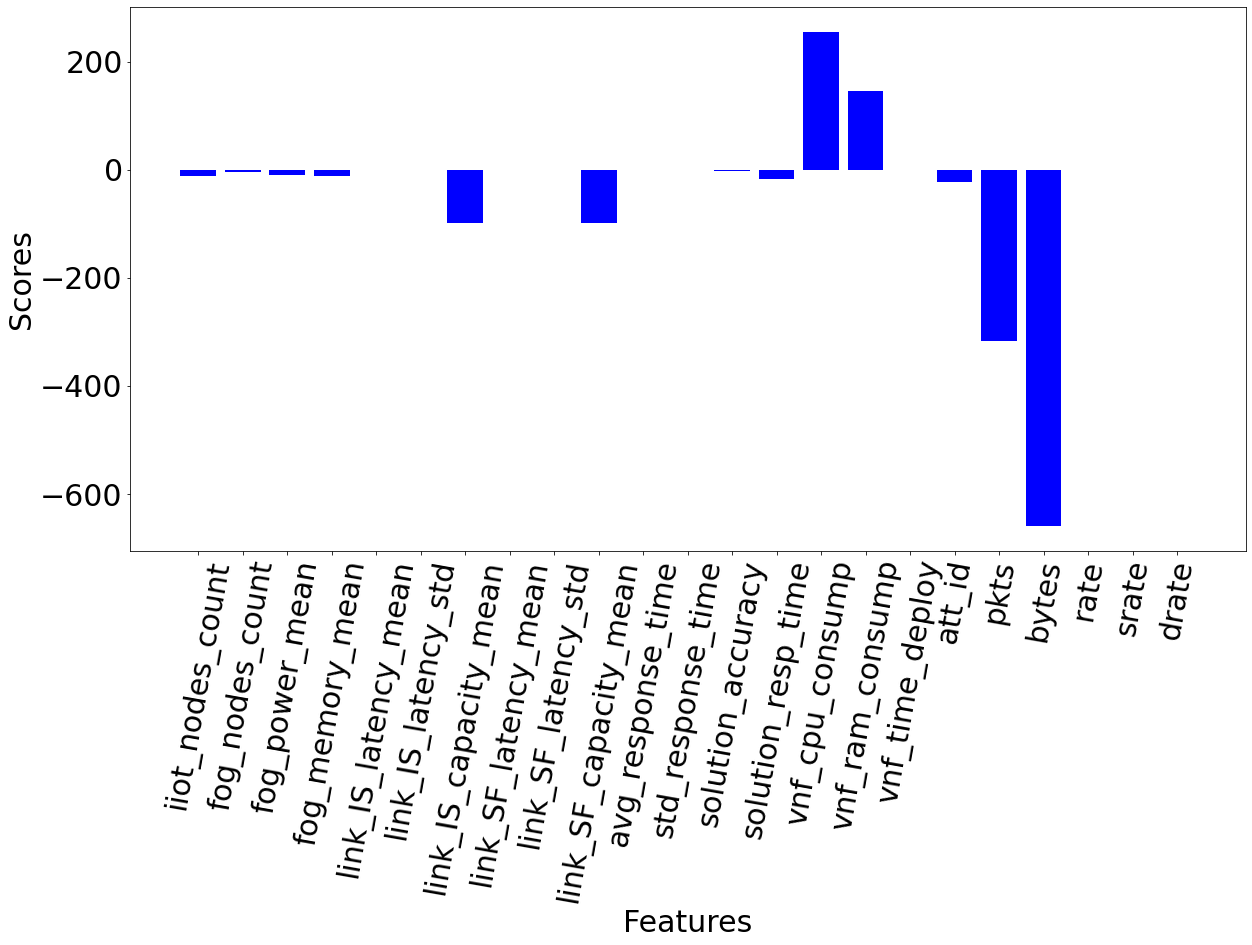

In [258]:
get_feature_importance_(svm_model_att, train, train_n, target_att)

###Testing Study

In [297]:
svm_model_att = SVC(C = 1e-3, kernel = 'linear')
svm_model_att_fit_model = svm_model_att.fit(train_n, target_att)
svm_model_att_fit_y_pred = svm_model_att_fit_model.predict(test_predict)

svm_model_att_fit_y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([0, 2, 2, 4, 2, 2, 2, 2, 2, 4, 1, 0, 4, 2, 4, 2, 1, 2, 1, 2, 2, 2,
       2, 4, 4, 2, 2, 4, 4, 2, 0, 0, 2, 4, 2, 2, 2, 2, 3, 2, 2, 4, 2, 4,
       2, 0, 2])

In [298]:
print_scores(test_target_att, svm_model_att_fit_y_pred, "Testing", "SVM")

---Testing SVM---

Accuracy: 36.1701
Precision: 34.7517
Recall: 36.1701
F1-Score: 30.9181


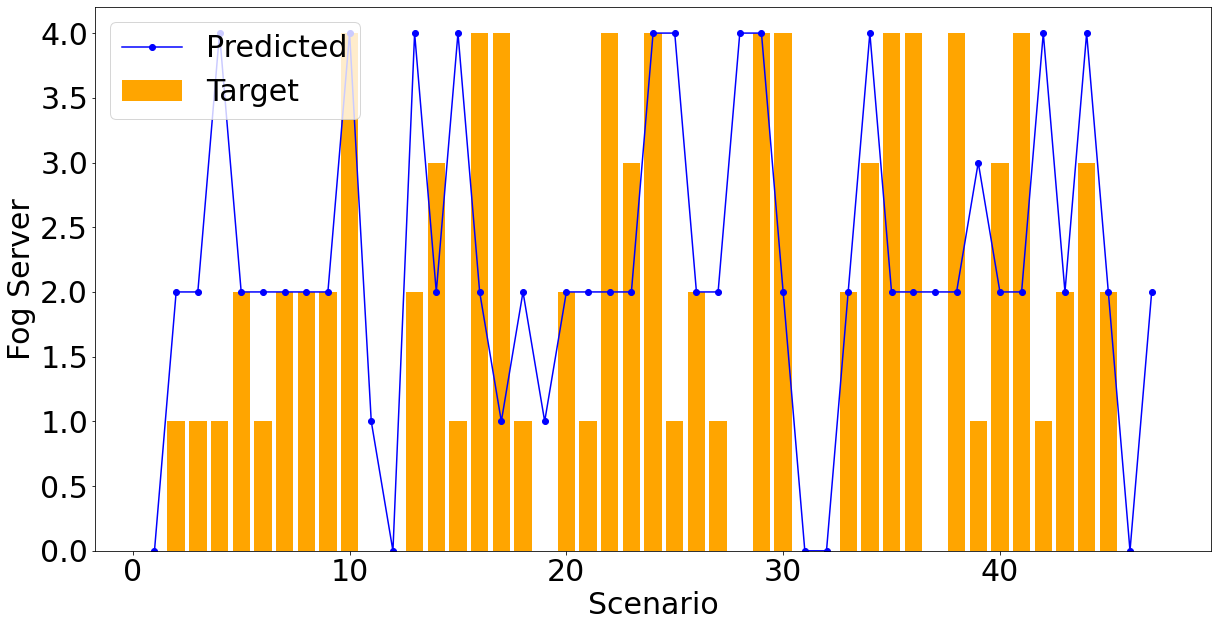

In [299]:
plot_predicted_and_target(test_target_att, svm_model_att_fit_y_pred, '')

iiot_nodes_count: 0.000013
fog_nodes_count: 0.000009
fog_power_mean: 0.000537
fog_memory_mean: 0.000671
link_IS_latency_mean: 0.000000
link_IS_latency_std: 0.000000
link_IS_capacity_mean: 0.005368
link_SF_latency_mean: 0.000000
link_SF_latency_std: 0.000000
link_SF_capacity_mean: 0.005368
avg_response_time: 0.000001
std_response_time: 0.000000
solution_accuracy: 0.000064
solution_resp_time: 0.000016
vnf_cpu_consump: 0.001556
vnf_ram_consump: 0.000151
vnf_time_deploy: 0.000003
att_id: 0.000003
pkts: -0.000121
bytes: -0.005535
rate: 0.000010
srate: 0.000000
drate: 0.000000


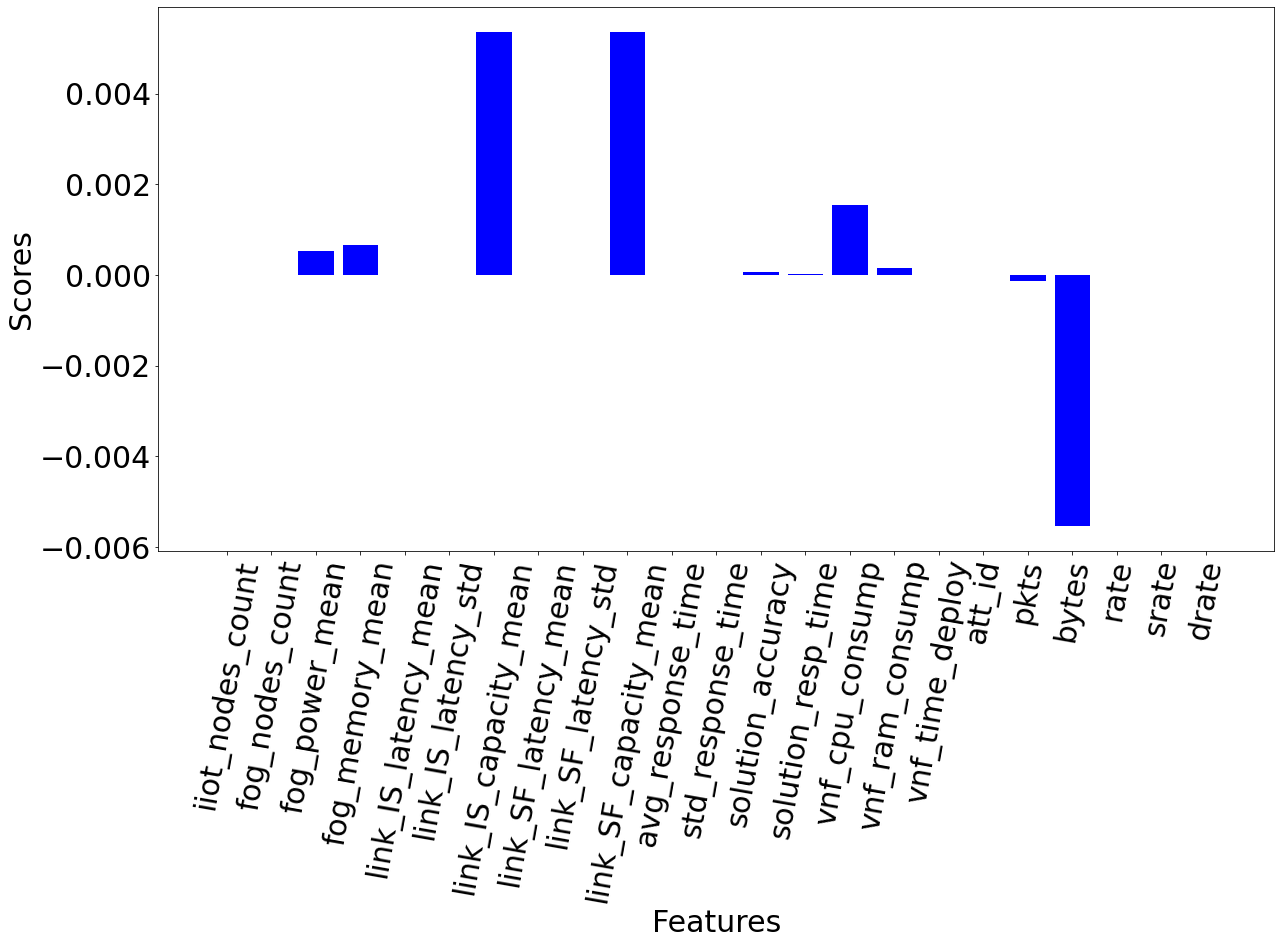

In [300]:
get_feature_importance_(svm_model_att_fit_model, train, train_n, target_att)

##K Nearest Neighbors

###Training Study

In [309]:
knn_model_att = KNeighborsClassifier(n_neighbors = 2)
knn_y_pred_att = cvp(knn_model_att, train, target_att, cv = kfold, n_jobs = 1)

knn_y_pred_att

array([0, 1, 1, 3, 2, 2, 3, 0, 4, 1, 1, 1, 3, 0, 2, 1, 1, 2, 1, 0, 1, 1,
       1, 1, 0, 1, 2, 1, 4, 2, 3, 1, 1, 0, 2, 3, 3, 4, 0, 2, 3, 2, 1, 0,
       2, 2, 0, 1, 4, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 2, 4, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 3, 2, 0, 1, 3, 4, 3, 2, 3, 3, 1, 4, 1, 0])

In [310]:
print_scores(target_att, knn_y_pred_att, "Training", "KNN")

---Training KNN---

Accuracy: 48.8094
Precision: 45.5356
Recall: 48.8094
F1-Score: 45.5129


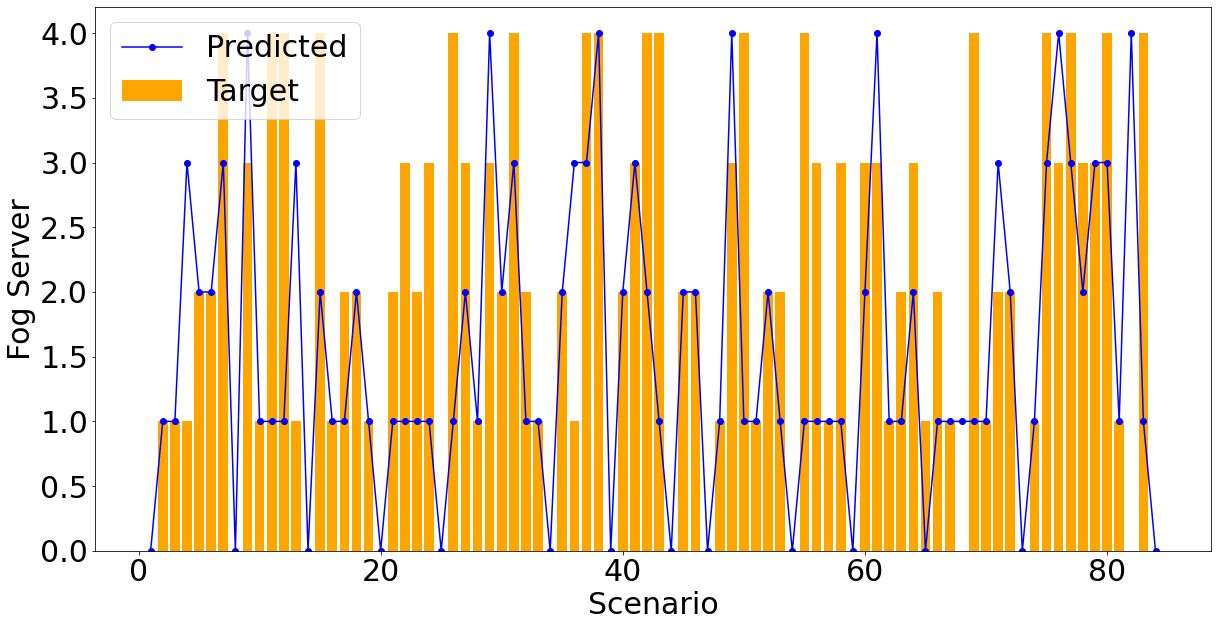

In [311]:
plot_predicted_and_target(target_att, knn_y_pred_att, '')

iiot_nodes_count: 0.007143
fog_nodes_count: 0.007143
link_IS_latency_std: 0.047619
link_SF_latency_std: 0.004762
avg_response_time: 0.033333
std_response_time: 0.030952
solution_resp_time: 0.002381
vnf_ram_consump: 0.121429
att_id: 0.188095
pkts: 0.114286
bytes: 0.009524
rate: 0.002381
srate: -0.002381


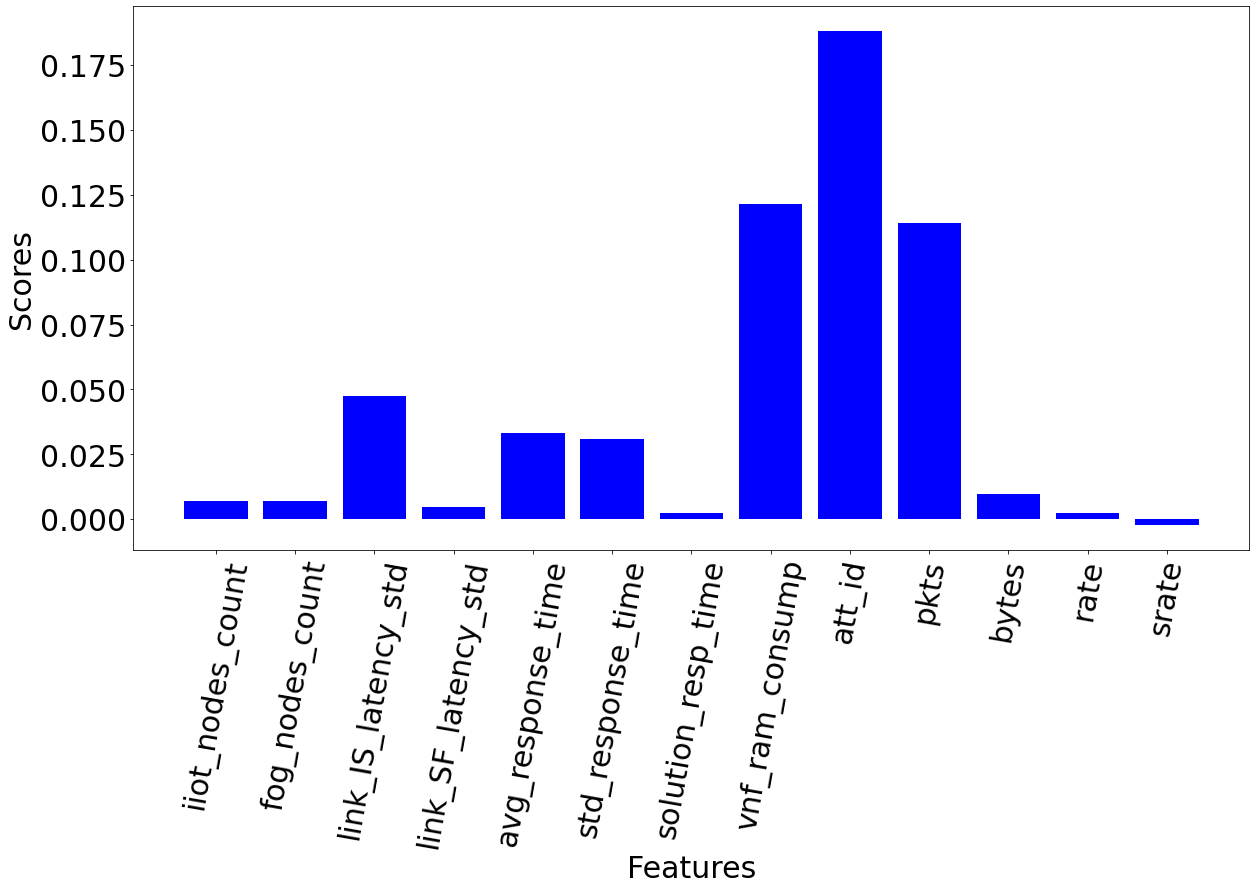

In [312]:
get_feature_importance__(knn_model_att, train, train_z, target_att)

###Testing Study

In [313]:
knn_model_att = KNeighborsClassifier(n_neighbors = 2)
knn_model_att_fit_model = knn_model_att.fit(train, target_att)
knn_model_att_fit_y_pred = knn_model_att_fit_model.predict(test_predict)

knn_model_att_fit_y_pred

array([0, 1, 1, 1, 2, 1, 2, 2, 2, 4, 0, 0, 2, 3, 1, 4, 1, 1, 0, 2, 1, 3,
       3, 4, 0, 1, 1, 0, 4, 1, 0, 0, 2, 3, 4, 4, 0, 4, 1, 3, 1, 1, 2, 2,
       2, 0, 0])

In [314]:
print_scores(test_target_att, knn_model_att_fit_y_pred, "Training", "KNN")

---Training KNN---

Accuracy: 85.1063
Precision: 87.1234
Recall: 85.1063
F1-Score: 84.8496


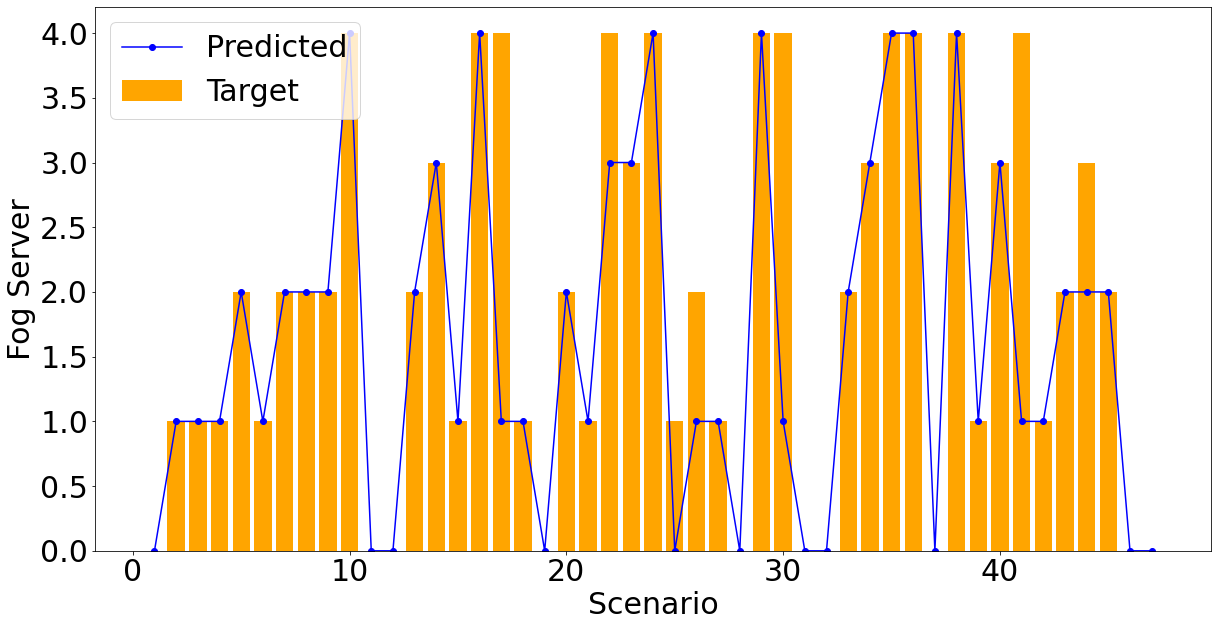

In [316]:
plot_predicted_and_target(test_target_att, knn_model_att_fit_y_pred, '')

iiot_nodes_count: 0.026190
fog_nodes_count: 0.026190
link_IS_latency_std: 0.061905
link_SF_latency_std: -0.000000
avg_response_time: 0.026190
std_response_time: 0.023810
solution_resp_time: -0.014286
vnf_ram_consump: 0.135714
att_id: 0.183333
pkts: 0.142857
bytes: 0.011905
rate: 0.004762
srate: 0.004762
drate: 0.002381


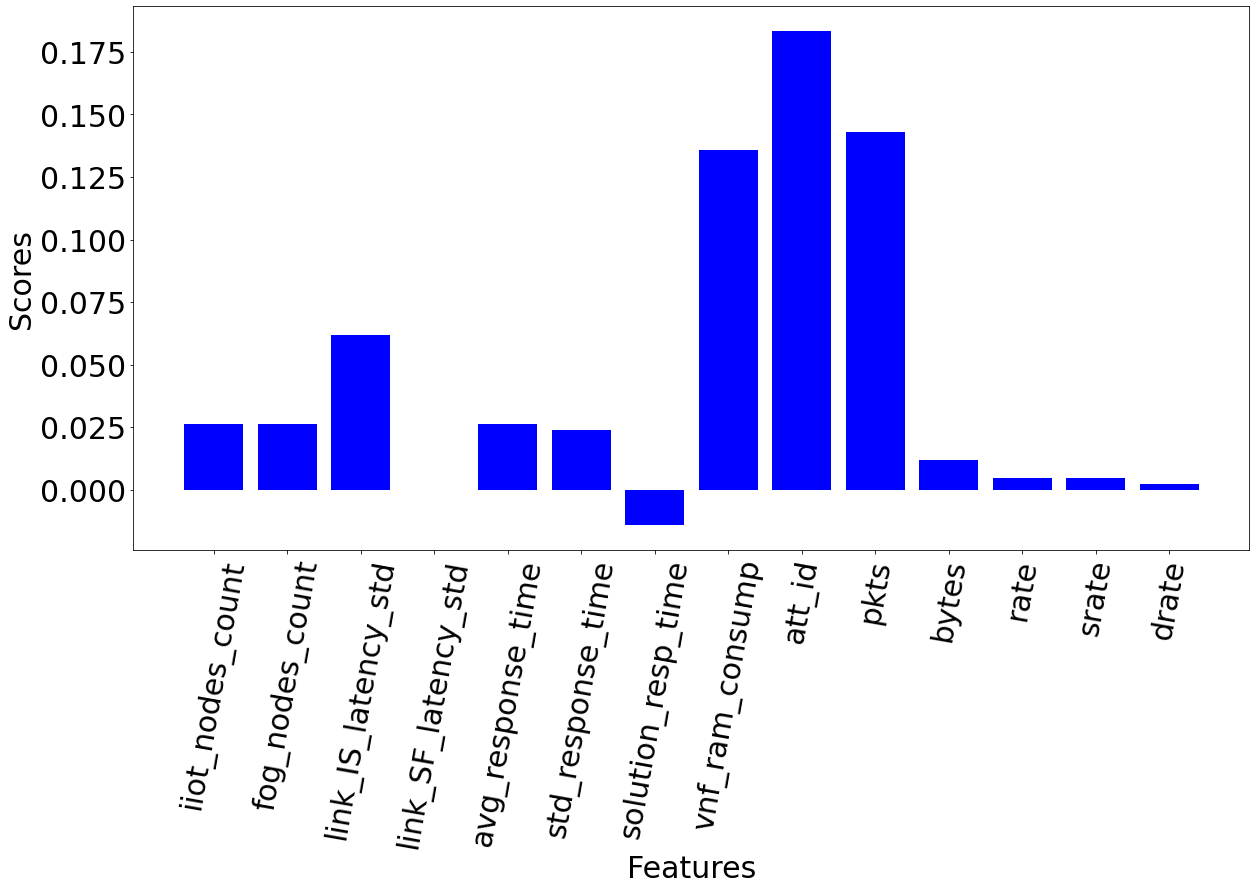

In [317]:
get_feature_importance__(knn_model_att_fit_model, train, train_z, target_att)

##Naive Bayes

###Training Study

In [318]:
nb_model_att = GaussianNB()
nb_y_pred_att = cvp(nb_model_att, train_z, target_att, cv = kfold, n_jobs = 1)

nb_y_pred_att

array([0, 1, 1, 1, 2, 2, 4, 0, 3, 1, 4, 0, 1, 0, 4, 1, 2, 2, 1, 0, 0, 3,
       2, 3, 0, 4, 3, 1, 0, 2, 4, 2, 1, 0, 2, 1, 4, 4, 0, 2, 3, 4, 4, 0,
       2, 2, 0, 1, 0, 4, 1, 2, 2, 0, 4, 3, 1, 3, 0, 3, 3, 1, 2, 3, 1, 2,
       0, 0, 4, 1, 2, 2, 0, 1, 4, 3, 4, 3, 3, 4, 1, 0, 0, 0])

In [319]:
print_scores(target_att, nb_y_pred_att, "Training", "NB")

---Training NB---

Accuracy: 92.8570
Precision: 94.8979
Recall: 92.8570
F1-Score: 93.2597


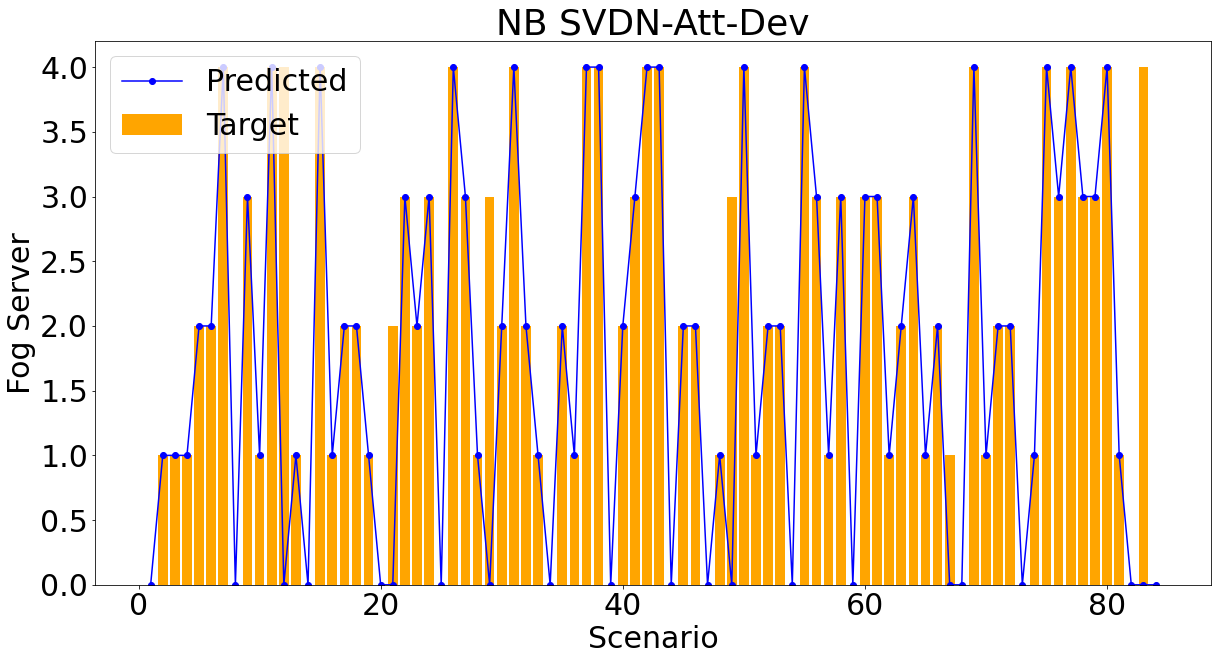

In [320]:
plot_predicted_and_target(target_att, nb_y_pred_att, 'NB SVDN-Att-Dev')

std_response_time: 0.016667
att_id: 0.702381
pkts: 0.007143
bytes: 0.028571
rate: 0.085714
srate: 0.050000
drate: 0.033333


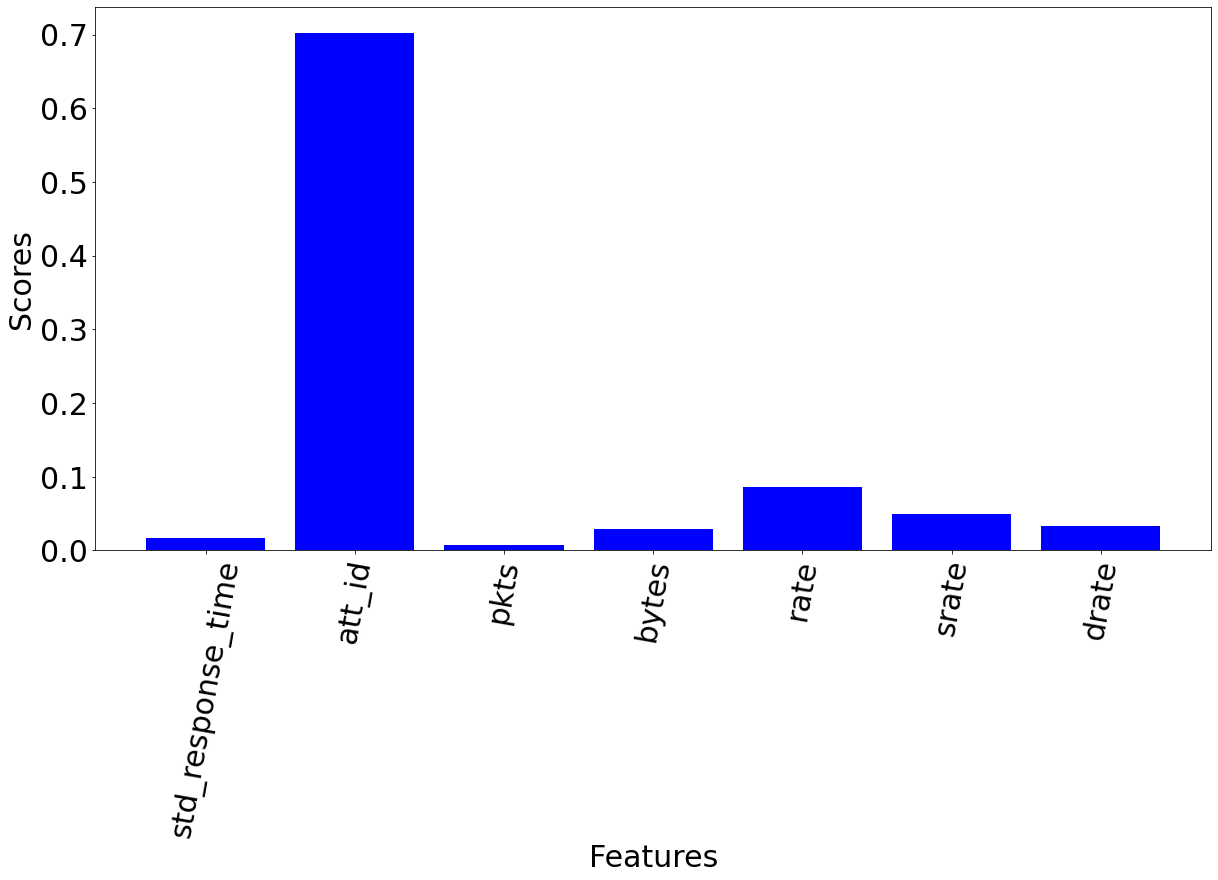

In [321]:
get_feature_importance__(nb_model_att, train, train_z, target_att)

###Testing Study

In [322]:
nb_model_att = GaussianNB()
nb_model_att_fit_model = nb_model_att.fit(train, target_att)
nb_model_att_fit_y_pred = nb_model_att_fit_model.predict(test_predict)

nb_model_att_fit_y_pred

array([4, 3, 2, 4, 2, 3, 2, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 2, 4,
       2, 2, 3, 3, 1, 3, 4, 2, 4, 4, 2, 3, 2, 2, 0, 2, 1, 4, 2, 2, 2, 2,
       2, 4, 0])

In [323]:
print_scores(test_target_att, nb_model_att_fit_y_pred, "Testing", "NB")

---Testing NB---

Accuracy: 31.9148
Precision: 58.5207
Recall: 31.9148
F1-Score: 31.5039


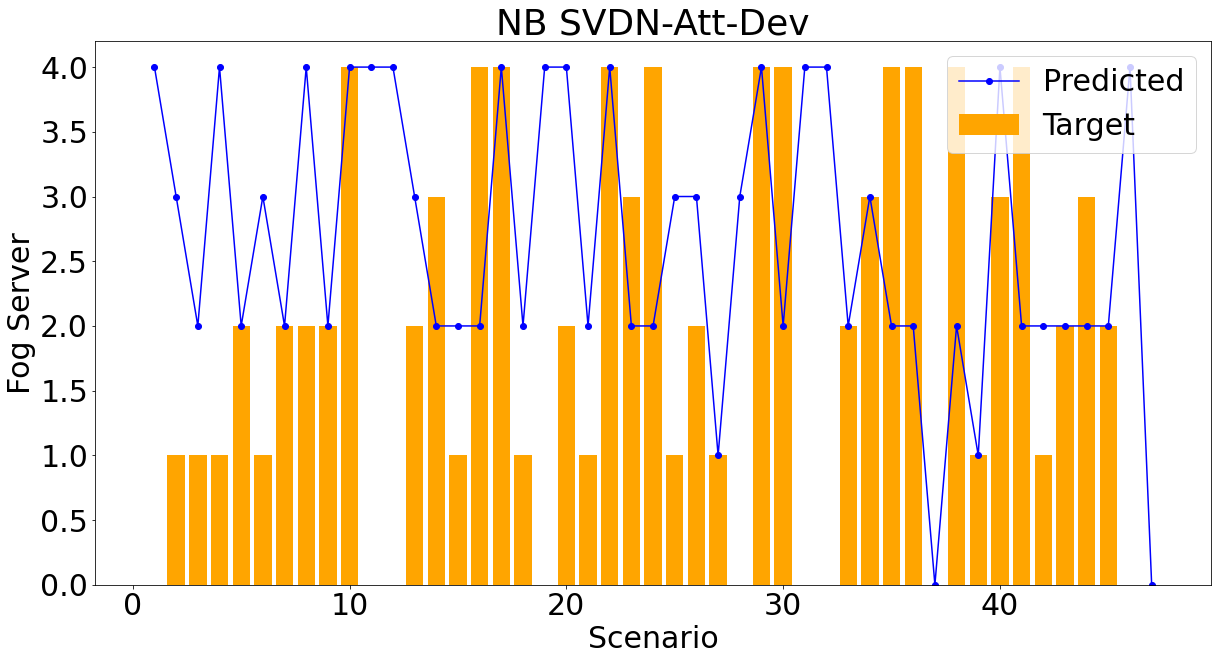

In [324]:
plot_predicted_and_target(test_target_att, nb_model_att_fit_y_pred, 'NB SVDN-Att-Dev')

std_response_time: 0.009524
att_id: 0.661905
pkts: 0.011905
bytes: 0.023810
rate: 0.092857
srate: 0.052381
drate: 0.042857


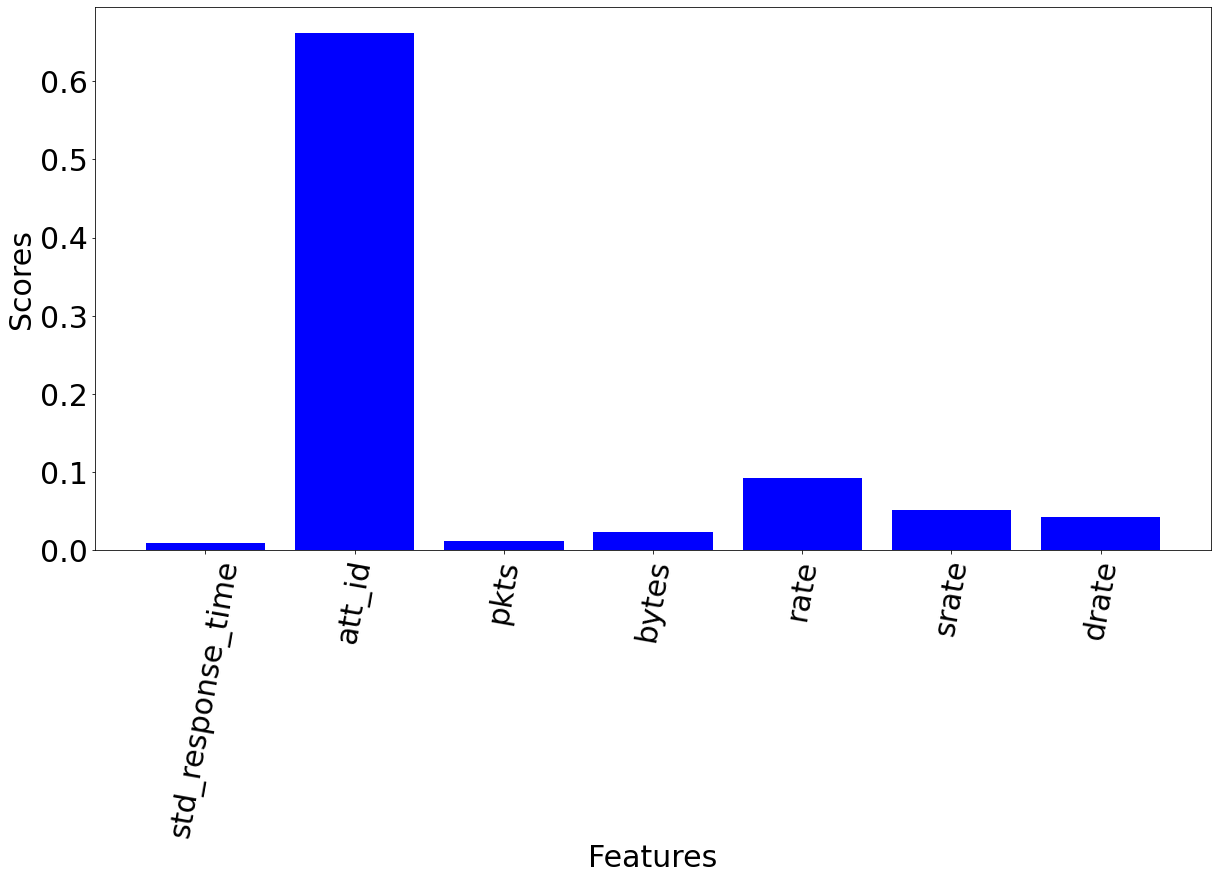

In [325]:
get_feature_importance__(nb_model_att_fit_model, train, train_z, target_att)

##K-Means

###Training Study

In [340]:
kmeans_model_att = KMeans(n_clusters = 5)
kmeans_y_pred_att = cvp(kmeans_model_att, train, cv = kfold, n_jobs = 1)

kmeans_y_pred_att

array([0, 4, 3, 3, 0, 0, 0, 0, 3, 4, 3, 4, 0, 0, 0, 3, 2, 3, 0, 4, 3, 2,
       4, 4, 0, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3, 3, 4, 4, 0, 4, 0, 2, 0, 1,
       3, 0, 4, 3, 4, 3, 4, 3, 4, 3, 4, 0, 0, 3, 0, 2, 0, 4, 0, 3, 4, 4,
       4, 4, 2, 4, 4, 3, 1, 0, 4, 3, 0, 3, 0, 0, 0, 4, 4, 3], dtype=int32)

In [341]:
print_scores(target_att, kmeans_y_pred_att, "Training", "K-Means")

---Training K-Means---

Accuracy: 22.6189
Precision: 19.6758
Recall: 22.6189
F1-Score: 19.0496


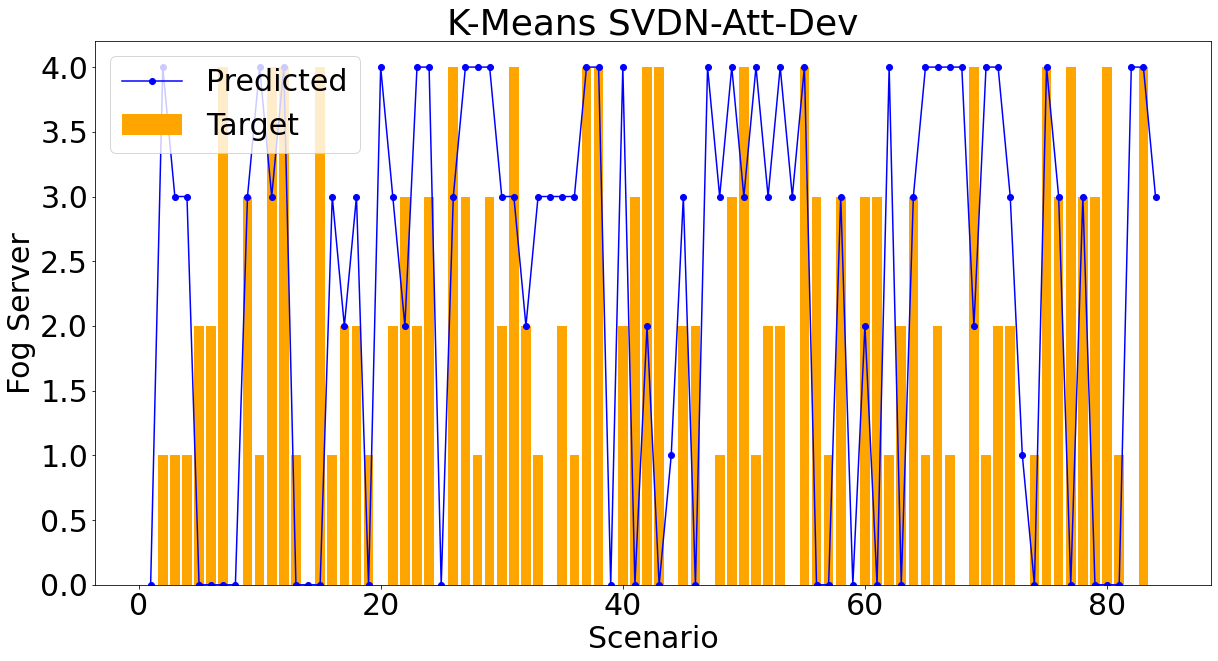

In [342]:
plot_predicted_and_target(target_att, kmeans_y_pred_att, 'K-Means SVDN-Att-Dev')

link_IS_latency_std: -0.014286
solution_resp_time: 0.002381


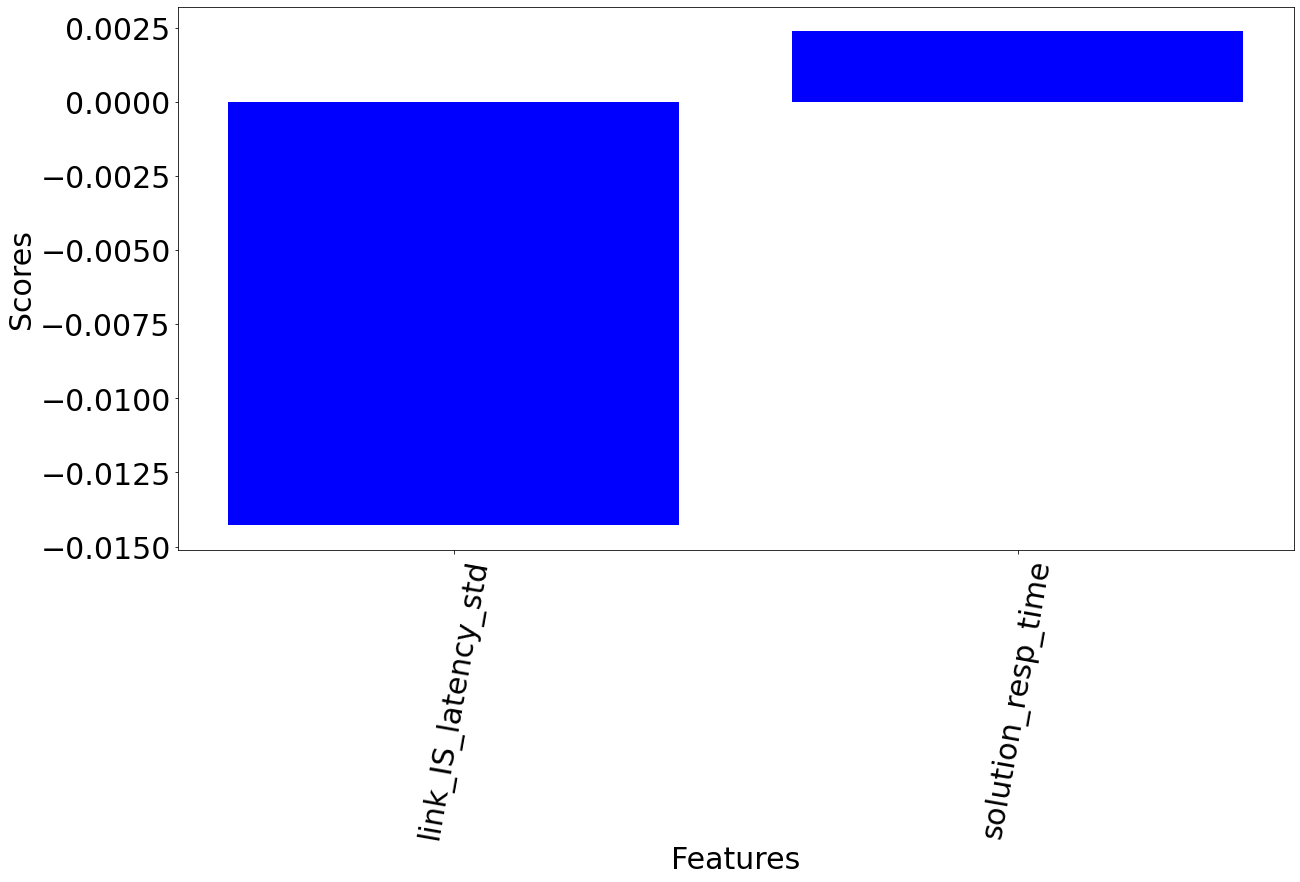

In [343]:
get_feature_importance__(kmeans_model_att, train, train_z, target_att)

###Testing Study

In [344]:
kmeans_model_att = KMeans(n_clusters = 5)
kmeans_model_att_fit_model = kmeans_model_att.fit(train)
kmeans_model_att_fit_y_pred = kmeans_model_att_fit_model.predict(test_predict)

kmeans_model_att_fit_y_pred

array([3, 4, 0, 3, 0, 4, 0, 3, 0, 3, 3, 3, 4, 0, 4, 0, 3, 0, 3, 3, 0, 4,
       0, 4, 4, 4, 4, 4, 3, 0, 3, 3, 0, 4, 0, 0, 1, 0, 0, 3, 0, 4, 0, 4,
       0, 3, 1], dtype=int32)

In [345]:
print_scores(test_target_att, kmeans_model_att_fit_y_pred, "Testing", "K-Means")

---Testing K-Means---

Accuracy: 6.3829
Precision: 25.6370
Recall: 6.3829
F1-Score: 5.0204


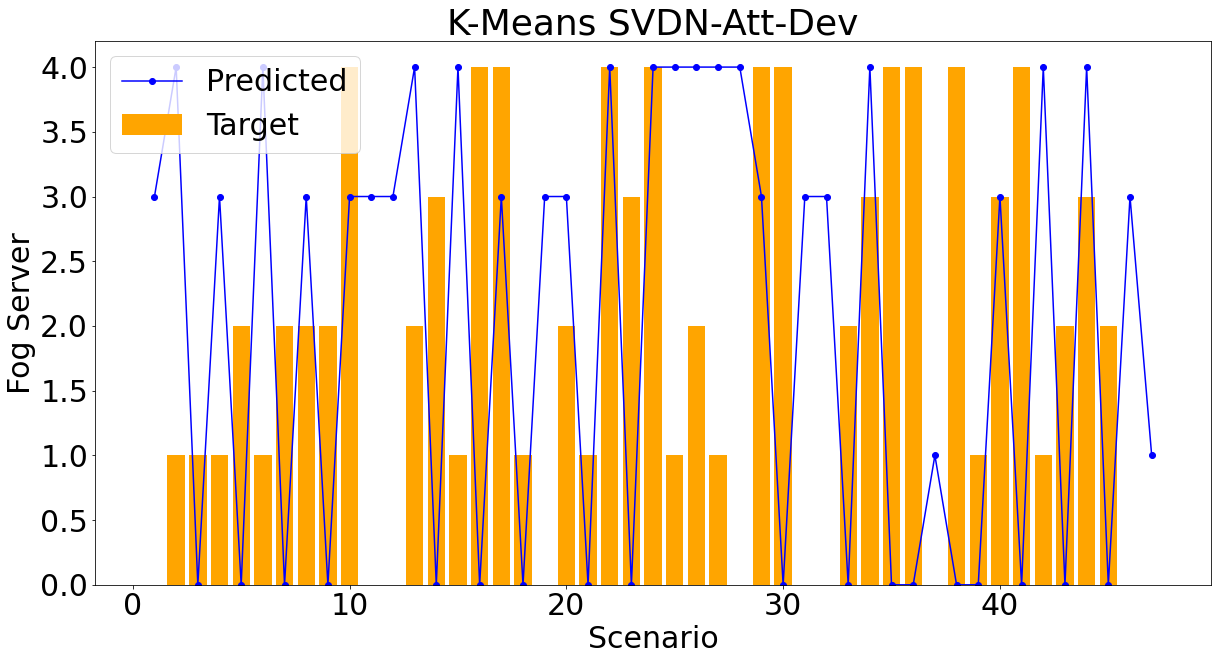

In [346]:
plot_predicted_and_target(test_target_att, kmeans_model_att_fit_y_pred, 'K-Means SVDN-Att-Dev')

iiot_nodes_count: -0.000000
fog_nodes_count: 0.002381
link_IS_latency_std: -0.000000
link_SF_latency_std: -0.000000
solution_resp_time: 0.007143
vnf_ram_consump: -0.002381


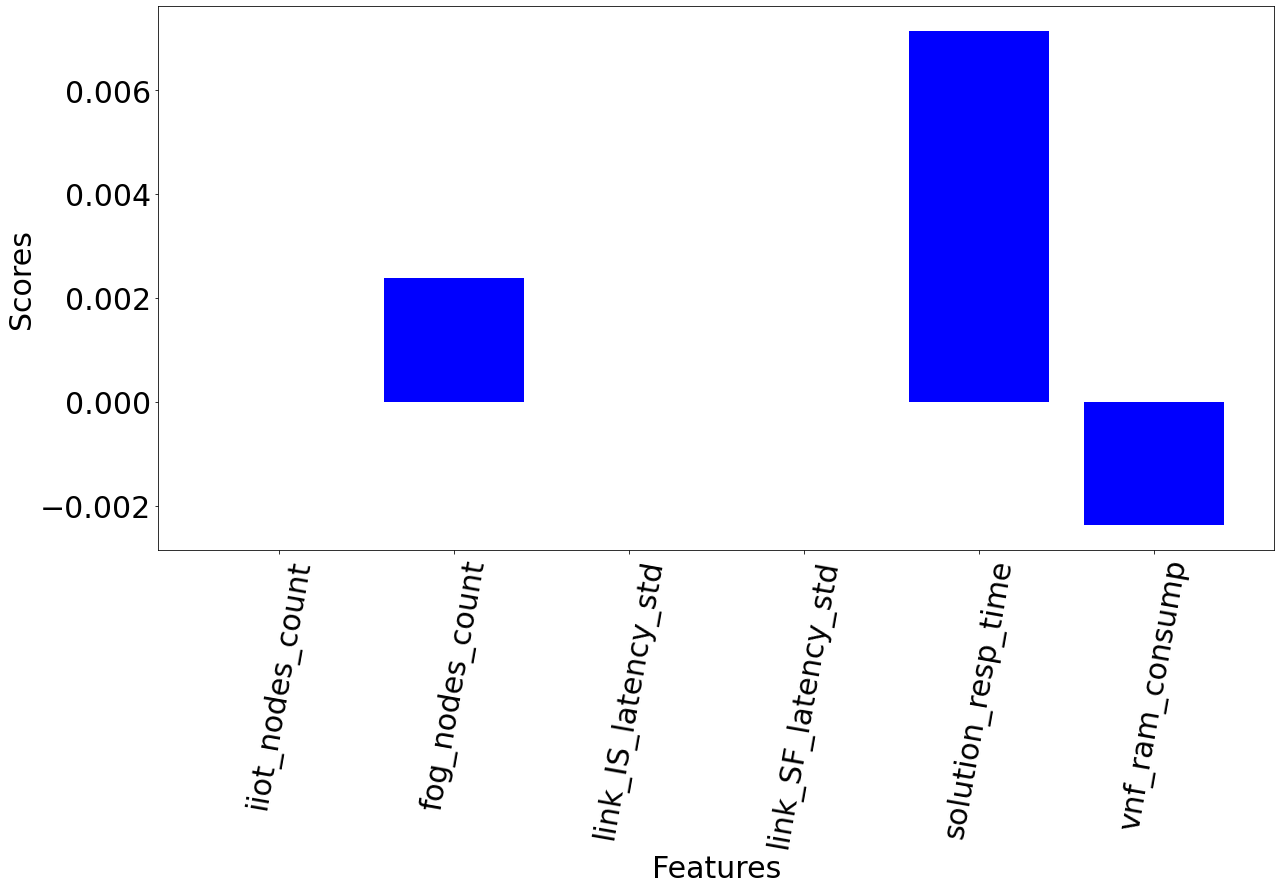

In [347]:
get_feature_importance__(kmeans_model_att_fit_model, train, train_z, target_att)

##Hierarchical Cluster

In [348]:
hc_model_att = AgglomerativeClustering(n_clusters = 5)
hc_y_pred_att = hc_model_att.fit_predict(train_z)

hc_y_pred_att

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 4, 4, 4, 4, 2,
       2, 2, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4])

In [349]:
print_scores(target_att, hc_y_pred_att, "Training and Testing", "HC")

---Training and Testing HC---

Accuracy: 29.7618
Precision: 40.0963
Recall: 29.7618
F1-Score: 27.8316


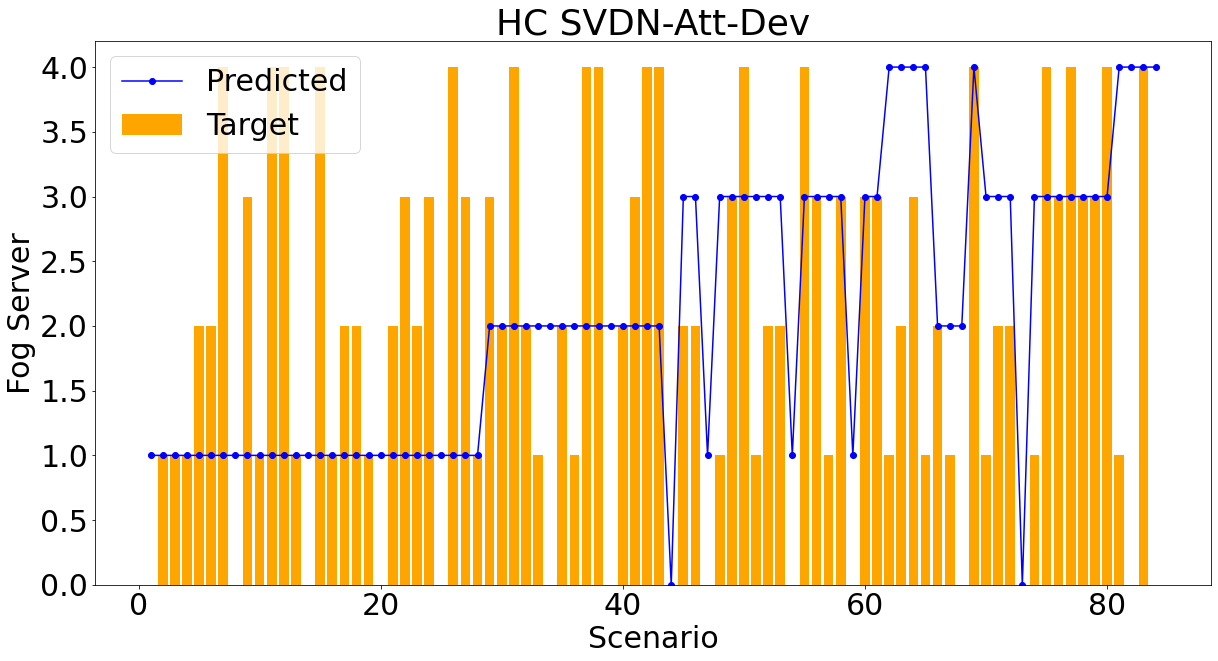

In [350]:
plot_predicted_and_target(target_att, hc_y_pred_att, 'HC SVDN-Att-Dev')

##Gaussian Mixture Model

In [351]:
gmm_model_att = GaussianMixture(n_components = 5)
gmm_y_pred_att = gmm_model_att.fit_predict(train_z)

gmm_y_pred_att

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [352]:
print_scores(target_att, gmm_y_pred_att, "Training and Testing", "GMM")

---Training and Testing GMM---

Accuracy: 20.2380
Precision: 30.4216
Recall: 20.2380
F1-Score: 17.3609


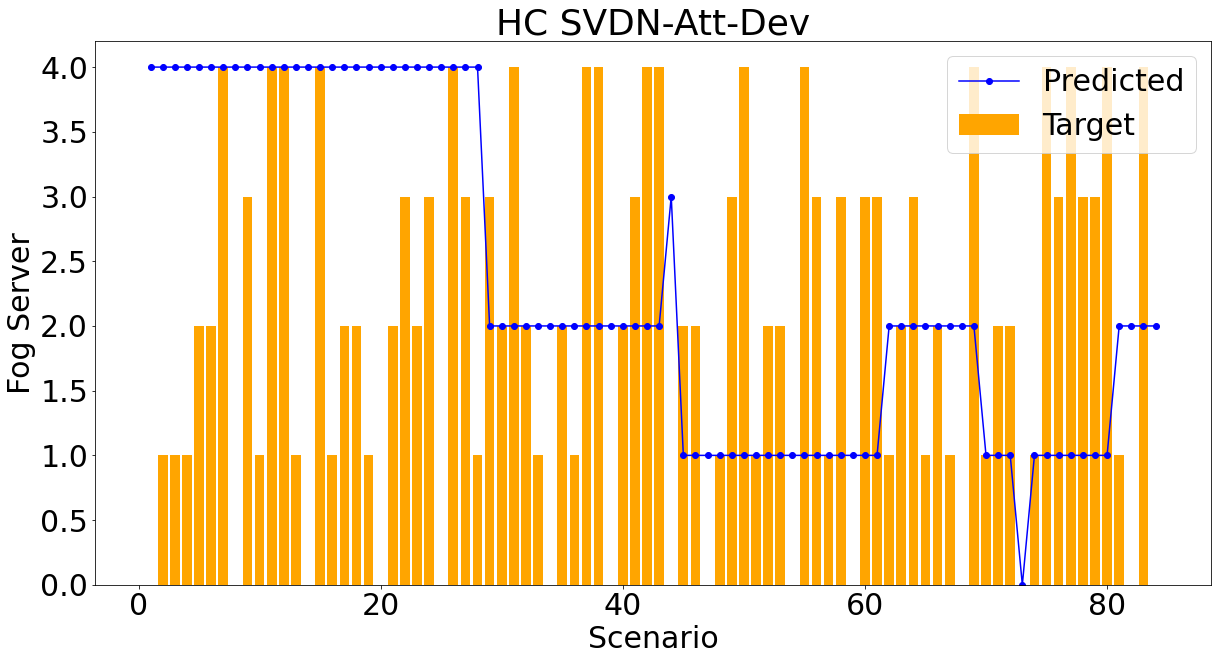

In [353]:
plot_predicted_and_target(target_att, gmm_y_pred_att, 'HC SVDN-Att-Dev')